# NLP Challenge

This is an analysis done as part of a challenge on an unknown dataset. From an initial look into the dataset, it seems to be a collection of news headlines. I do an exploratory analysis here trying to understand the entire data rather than go for bulding a predictive model. Personally speaking, a predictive model seems a bit unlikely for this dataset in the raw form. Maybe, after a bit of preprocessing of the upvotes into a categorical variable, we could go for a rating prediction of the articles. Also given the authors, there could be a relation to the kind of the articles they publish, so maybe a Naive Bayes classifier for author prediction from articles if we have enough data for some authors. But I will focus on the exploration here mostly.  

## Libraries and data imports

In [1]:
# import key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import wordnet,stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from textblob import TextBlob
import gensim
import re
import string

In [2]:
# In case I need GPU (unlikely since I am not training an ML model)
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='any')

In [3]:
# seed for REPRODUCIBILITY
SEED = 101  

In [4]:
# load the data
df = pd.read_csv('Eluvio_DS_Challenge.csv')
df.head()

time_created date_created  up_votes  down_votes  \
0    1201232046   2008-01-25         3           0   
1    1201232075   2008-01-25         2           0   
2    1201232523   2008-01-25         3           0   
3    1201233290   2008-01-25         1           0   
4    1201274720   2008-01-25         4           0   

                                             title  over_18    author  \
0                Scores killed in Pakistan clashes    False     polar   
1                 Japan resumes refuelling mission    False     polar   
2                  US presses Egypt on Gaza border    False     polar   
3     Jump-start economy: Give health care to all     False   fadi420   
4  Council of Europe bashes EU&UN terror blacklist    False  mhermans   

    category  
0  worldnews  
1  worldnews  
2  worldnews  
3  worldnews  
4  worldnews

In [5]:
df.isnull().sum()

time_created    0
date_created    0
up_votes        0
down_votes      0
title           0
over_18         0
author          0
category        0
dtype: int64

In [5]:
df.dtypes

time_created     int64
date_created    object
up_votes         int64
down_votes       int64
title           object
over_18           bool
author          object
category        object
dtype: object

In [6]:
df.head()

time_created date_created  up_votes  down_votes  \
0    1201232046   2008-01-25         3           0   
1    1201232075   2008-01-25         2           0   
2    1201232523   2008-01-25         3           0   
3    1201233290   2008-01-25         1           0   
4    1201274720   2008-01-25         4           0   

                                             title  over_18    author  \
0                Scores killed in Pakistan clashes    False     polar   
1                 Japan resumes refuelling mission    False     polar   
2                  US presses Egypt on Gaza border    False     polar   
3     Jump-start economy: Give health care to all     False   fadi420   
4  Council of Europe bashes EU&UN terror blacklist    False  mhermans   

    category  
0  worldnews  
1  worldnews  
2  worldnews  
3  worldnews  
4  worldnews

In [7]:
len(df)

509236

<AxesSubplot:xlabel='category', ylabel='count'>

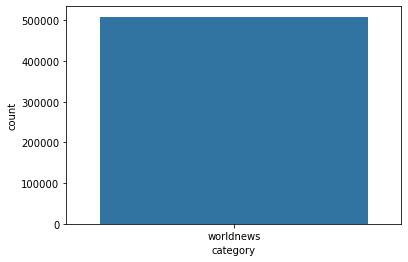

In [8]:
sns.countplot(x = 'category', data=df)

So, just one category, no need of the last column.

In [9]:
df.drop(['category'], axis=1, inplace=True)

<AxesSubplot:>

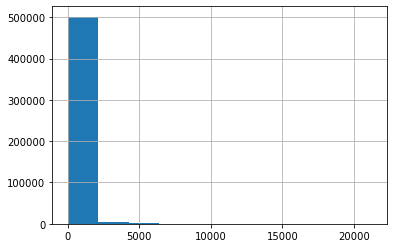

In [10]:
df.up_votes.hist(bins=10)

In [11]:
df.down_votes.value_counts()

0    509236
Name: down_votes, dtype: int64

In [12]:
# no need of the down_votes column, let's drop it
df.drop(['down_votes'], axis=1, inplace=True)

In [13]:
df.author.value_counts()

davidreiss666     8897
anutensil         5730
DoremusJessup     5037
maxwellhill       4023
igeldard          4013
                  ... 
GloriousHam          1
peaceistheword       1
TheYogi              1
GreenElite87         1
MarDeLib             1
Name: author, Length: 85838, dtype: int64

Thats a lot of authors. One idea could be to look at a few of the more popular ones and see what content each of them publish.

In [14]:
df.over_18.value_counts()

False    508916
True        320
Name: over_18, dtype: int64

**over_18** : Very imbalanced column. We will characterize these classes below. Before that, let's first pre-process the data a bit to get a better handle on it.

## Data pre-processing

**Stemming** or **Lemmatization** : Stemming is usually the easier of the two to implement. But it tends to produce some non-sensical words, for example 'economies' become 'economi', 'deputy' becomes 'deputi' and so on. Lemmatization, on the other hand, needs a bit of work to implement but produces the correct root of the words. So, I will implement lemmatization to each of our text. 

This is a huge dataset. Let's analyze a random subset of it, to start with. Once we have a general idea, we can expand the analysis to the entire dataset.

In [15]:
df2 = df.sample(100000, random_state=SEED).reset_index()

In [16]:
# First we need to find the POS (or parts of speech) tag for the words. We define this
# helper function to pass it our lemmatizer

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [17]:
# In the following function, I implement all the basic pre-processing tasks like stopwords
# removal, lemmatization, punctuation stripping and so on...

def process_text(text):
    """Process individual text.
    Input:
        text: a string representing individual rows of the 'title' column
    Output:
        texts_clean: a list of words containing the processed tweet

    """
    lemmatizer = WordNetLemmatizer()
    
    stopwords_english = stopwords.words('english')
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # finally lemmatizing. gensim.utils.simple_preprocess uses tokenize() internally and does lowercasing as well
    return [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in gensim.utils.simple_preprocess(text) if token not in stopwords_english and len(token) >= 2]

In [18]:
df2['title_processed'] = df2['title'].apply(process_text)

In [19]:
df2['title_processed_joined'] = df2['title_processed'].apply(lambda x: ' '.join(x))

In [20]:
df2.head(10)

index  time_created date_created  up_votes  \
0    2572    1207032715   2008-04-01         2   
1  174001    1365986500   2013-04-15         1   
2  279154    1401459395   2014-05-30         0   
3   59328    1277362604   2010-06-24         7   
4  361394    1429196161   2015-04-16         0   
5  234143    1386345508   2013-12-06      3986   
6   30112    1237489920   2009-03-19         0   
7    1355    1205734057   2008-03-17         0   
8   28711    1236150492   2009-03-04         2   
9  397182    1442518307   2015-09-17        17   

                                               title  over_18  \
0  Deputies say neglect caused boy to waste away ...    False   
1  Is your old t-shirt hurting African economies?...    False   
2  Indonesian authorities said they were testing ...    False   
3  New Australian PM announces her cabinet. Retai...    False   
4  China Suspends Rules on Tech Companies Serving...    False   
5  Japan passes a democracy-muzzling Patriot Act....    False   
6  Charlie Miller Wins Pwn2Own Again Thanks to Sa...    False   
7  Basic Greenhouse Equations  Totally Wrong  - W...    False   
8                    Blackwater Founder, CEO Resigns    False   
9  US plans to accept Russia offer to join milita...    False   

               author                                    title_processed  \
0              yorosa  [deputy, say, neglect, cause, boy, waste, away...   
1  bridgesfreezefirst  [old, tshirt, hurt, african, economy, tshirt, ...   
2         XKryptonite  [indonesian, authority, say, test, product, ma...   
3           shigawire  [new, australian, pm, announces, cabinet, reta...   
4          cyberogism  [china, suspends, rule, tech, company, serve, ...   
5       SubTerFuge666  [japan, pass, patriot, act, obamasupported, st...   
6              hotice  [charlie, miller, win, pwn, thanks, safari, fl...   
7           BravoLima  [basic, greenhouse, equation, totally, wrong, ...   
8          bananatalk                [blackwater, founder, ceo, resigns]   
9               emwac  [u, plan, accept, russia, offer, join, militar...   

                              title_processed_joined  
0  deputy say neglect cause boy waste away pound ...  
1  old tshirt hurt african economy tshirt may qui...  
2  indonesian authority say test product make bri...  
3  new australian pm announces cabinet retains pr...  
4        china suspends rule tech company serve bank  
5  japan pass patriot act obamasupported state se...  
6  charlie miller win pwn thanks safari flaw repo...  
7   basic greenhouse equation totally wrong surprise  
8                     blackwater founder ceo resigns  
9  u plan accept russia offer join military talk ...

## Exploratory analysis

Let's begin exporing our dataset now. First let's check the popular words in the **over_18** classes

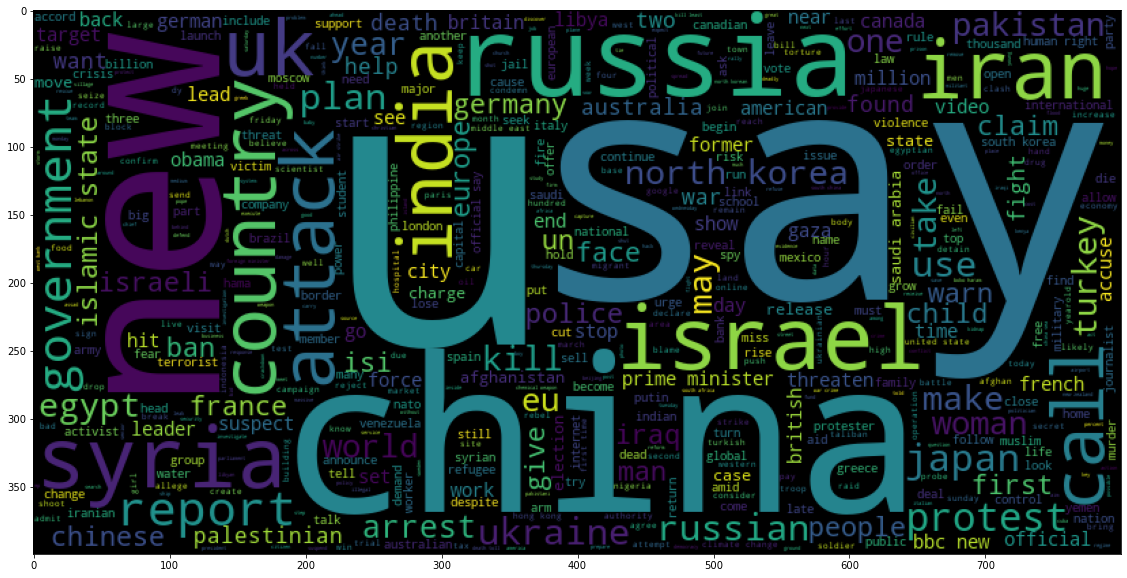

In [21]:
plt.figure(figsize=(20,10))
wc = WordCloud(max_words=500, width = 800, height = 400).generate(' '.join(df2.loc[df2['over_18'] == False, 'title_processed_joined']))
plt.imshow(wc)

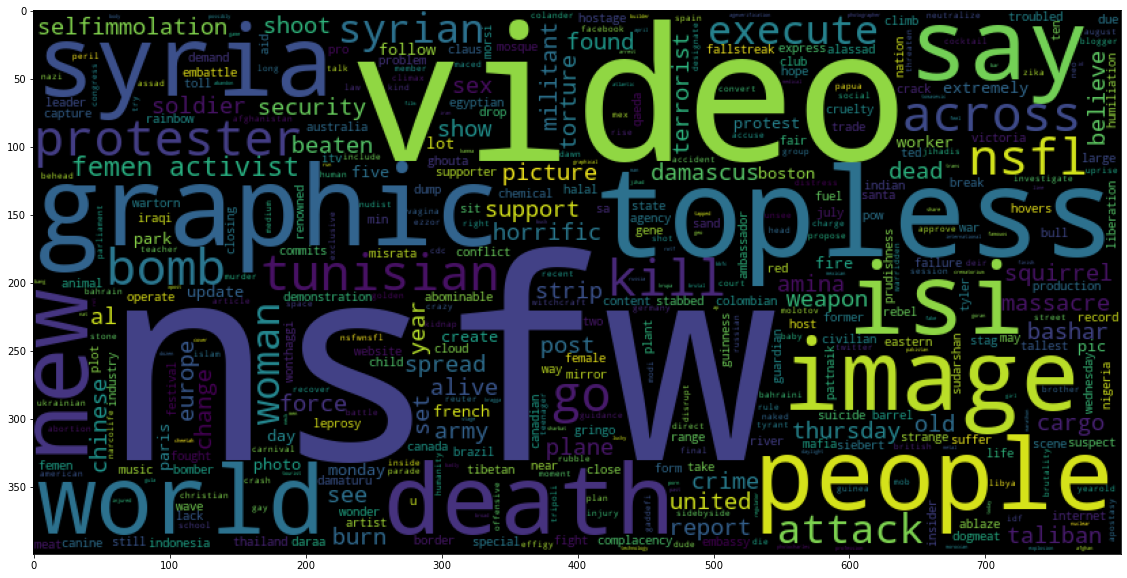

In [22]:
plt.figure(figsize=(20,10))
wc1 = WordCloud(max_words=500, width = 800, height = 400).generate(' '.join(df2.loc[df2['over_18'] == True, 'title_processed_joined']))
plt.imshow(wc1)

**NSFW** (not safe for work), **topless**, etc. clearly demonstrates the kind of content that is marked over_18.

Next, it will be interesting to see how the up_votes really capture the sentiment in the news. Or is there actually any such correlation? To do that, let's use a pre_trained sentiment classifier to classify the sentiments in the text and compare it against the up_votes

In [23]:
df2['sentiment'] = df2['title_processed_joined'].apply(lambda x: TextBlob(x).sentiment.polarity)
df2.head()

index  time_created date_created  up_votes  \
0    2572    1207032715   2008-04-01         2   
1  174001    1365986500   2013-04-15         1   
2  279154    1401459395   2014-05-30         0   
3   59328    1277362604   2010-06-24         7   
4  361394    1429196161   2015-04-16         0   

                                               title  over_18  \
0  Deputies say neglect caused boy to waste away ...    False   
1  Is your old t-shirt hurting African economies?...    False   
2  Indonesian authorities said they were testing ...    False   
3  New Australian PM announces her cabinet. Retai...    False   
4  China Suspends Rules on Tech Companies Serving...    False   

               author                                    title_processed  \
0              yorosa  [deputy, say, neglect, cause, boy, waste, away...   
1  bridgesfreezefirst  [old, tshirt, hurt, african, economy, tshirt, ...   
2         XKryptonite  [indonesian, authority, say, test, product, ma...   
3           shigawire  [new, australian, pm, announces, cabinet, reta...   
4          cyberogism  [china, suspends, rule, tech, company, serve, ...   

                              title_processed_joined  sentiment  
0  deputy say neglect cause boy waste away pound ...  -0.200000  
1  old tshirt hurt african economy tshirt may qui...   0.125000  
2  indonesian authority say test product make bri...   0.000000  
3  new australian pm announces cabinet retains pr...   0.068182  
4        china suspends rule tech company serve bank   0.000000

<AxesSubplot:>

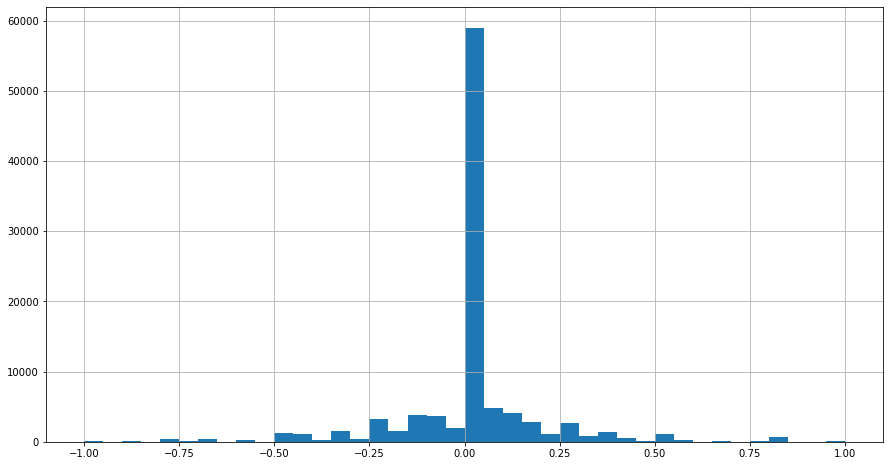

In [24]:
df2.sentiment.hist(bins=40,figsize=(15,8))

In [25]:
len(df2.loc[(df2['sentiment'] > 0.2) | (df2['sentiment'] < -0.2),:])

16293

In [26]:
df2.loc[(df2['sentiment'] > 0.2) | (df2['sentiment'] < -0.2),:].sample(10)

index  time_created date_created  up_votes  \
86159  334796    1420900671   2015-01-10        11   
69069  440551    1455975258   2016-02-20        23   
77483  227159    1383946370   2013-11-08      2455   
96230  433475    1453824901   2016-01-26         4   
79107  430238    1452743820   2016-01-14         7   
31723   40523    1248357717   2009-07-23         0   
74425  424936    1450716486   2015-12-21        10   
51041    6755    1211191114   2008-05-19         1   
70921  252227    1392124765   2014-02-11         9   
58468  372923    1433342902   2015-06-03         2   

                                                   title  over_18  \
86159  South Korea deports US woman accused of praisi...    False   
69069  Authorities issued an expulsion order Friday f...    False   
77483  Myanmar is preparing to adopt the Metric syste...    False   
96230  Saudi Civil Status Department has started issu...    False   
79107  Strong earthquake shakes northern Japan; no ts...    False   
31723  Swine Flu infects 100,000 in past week in the ...    False   
74425   ISIS proves vulnerable to its own ‘ghost armies’    False   
51041  Rochester s Omega Laser, One of the World s Mo...    False   
70921   Donald Trump loses Aberdeen Bay wind farm battle    False   
58468   A horrific case of mistaken identity  Man jai...    False   

                author                                    title_processed  \
86159          ionised  [south, korea, deports, u, woman, accuse, prai...   
69069    madazzahatter  [authority, issue, expulsion, order, friday, h...   
77483  aerospacemonkey  [myanmar, prepare, adopt, metric, system, leav...   
96230    AmeliaBodelia  [saudi, civil, status, department, start, issu...   
79107      njfloss2002  [strong, earthquake, shake, northern, japan, t...   
31723          ajehals              [swine, flu, infects, past, week, uk]   
74425       mhaseeb123               [isi, prof, vulnerable, ghost, army]   
51041     digitalfever  [rochester, omega, laser, one, world, powerful...   
70921       mondoennui  [donald, trump, loses, aberdeen, bay, wind, fa...   
58468       Carysanwen  [horrific, case, mistaken, identity, man, jail...   

                                  title_processed_joined  sentiment  
86159  south korea deports u woman accuse praise nort...   0.500000  
69069  authority issue expulsion order friday hundred...   0.400000  
77483  myanmar prepare adopt metric system leave usa ...  -0.500000  
96230  saudi civil status department start issue fami...   0.250000  
79107  strong earthquake shake northern japan tsunami...   0.433333  
31723                     swine flu infects past week uk  -0.250000  
74425                     isi prof vulnerable ghost army  -0.500000  
51041  rochester omega laser one world powerful recei...   0.300000  
70921   donald trump loses aberdeen bay wind farm battle  -0.300000  
58468  horrific case mistaken identity man jail life ...  -0.668750

Pretty neutral dataset sentiment-wise. Some of the more polarised news texts(positive or negative) are sampled above. We will focus more on the characterizing the general topics here. The up_votes distribution as shown below is also quite skewed to the left.

<AxesSubplot:>

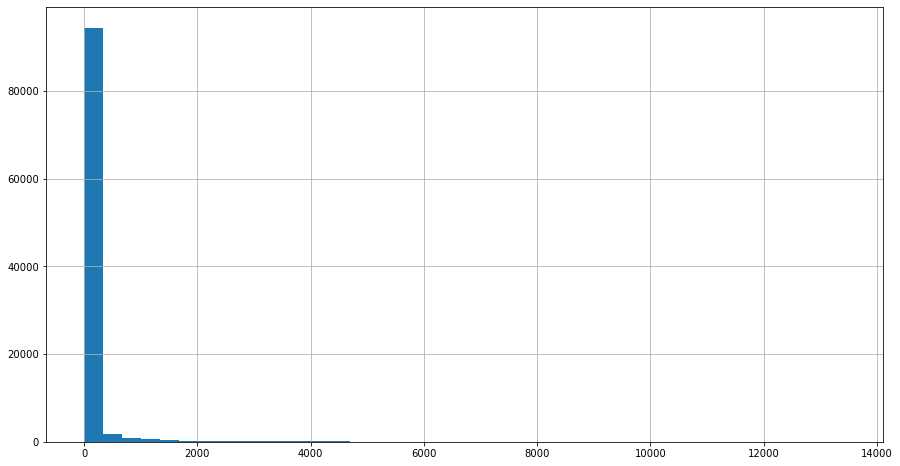

In [27]:
df2.up_votes.hist(bins=40,figsize=(15,8))

In [28]:
df2[df2['up_votes']<=5].up_votes.count()

54187

In [29]:
df2[(df2['up_votes']>5) & (df2['up_votes']<=20)].up_votes.count()

24256

In [30]:
df2[(df2['up_votes']>20) & (df2['up_votes']<=100)].up_votes.count()

11788

In [31]:
df2[(df2['up_votes']>100) & (df2['up_votes']<=500)].up_votes.count()

5346

In [32]:
df2[df2['up_votes'] > 500].up_votes.count()

4423

Let's create a categorical feature from the up_votes column to characterize the distribution better.

In [33]:
ratings = []

for i in range(len(df2)):
    if df2.loc[i, 'up_votes'] > 500:
        ratings.append(5)
    elif df2.loc[i, 'up_votes'] > 100:
        ratings.append(4)
    elif df2.loc[i, 'up_votes'] > 20:
        ratings.append(3)
    elif df2.loc[i, 'up_votes'] > 5:
        ratings.append(2)
    else:
        ratings.append(1)

In [34]:
df2['ratings'] = ratings

In [35]:
df2.head()

index  time_created date_created  up_votes  \
0    2572    1207032715   2008-04-01         2   
1  174001    1365986500   2013-04-15         1   
2  279154    1401459395   2014-05-30         0   
3   59328    1277362604   2010-06-24         7   
4  361394    1429196161   2015-04-16         0   

                                               title  over_18  \
0  Deputies say neglect caused boy to waste away ...    False   
1  Is your old t-shirt hurting African economies?...    False   
2  Indonesian authorities said they were testing ...    False   
3  New Australian PM announces her cabinet. Retai...    False   
4  China Suspends Rules on Tech Companies Serving...    False   

               author                                    title_processed  \
0              yorosa  [deputy, say, neglect, cause, boy, waste, away...   
1  bridgesfreezefirst  [old, tshirt, hurt, african, economy, tshirt, ...   
2         XKryptonite  [indonesian, authority, say, test, product, ma...   
3           shigawire  [new, australian, pm, announces, cabinet, reta...   
4          cyberogism  [china, suspends, rule, tech, company, serve, ...   

                              title_processed_joined  sentiment  ratings  
0  deputy say neglect cause boy waste away pound ...  -0.200000        1  
1  old tshirt hurt african economy tshirt may qui...   0.125000        1  
2  indonesian authority say test product make bri...   0.000000        1  
3  new australian pm announces cabinet retains pr...   0.068182        2  
4        china suspends rule tech company serve bank   0.000000        1

In [36]:
set(df2['ratings'])

{1, 2, 3, 4, 5}

<AxesSubplot:ylabel='ratings'>

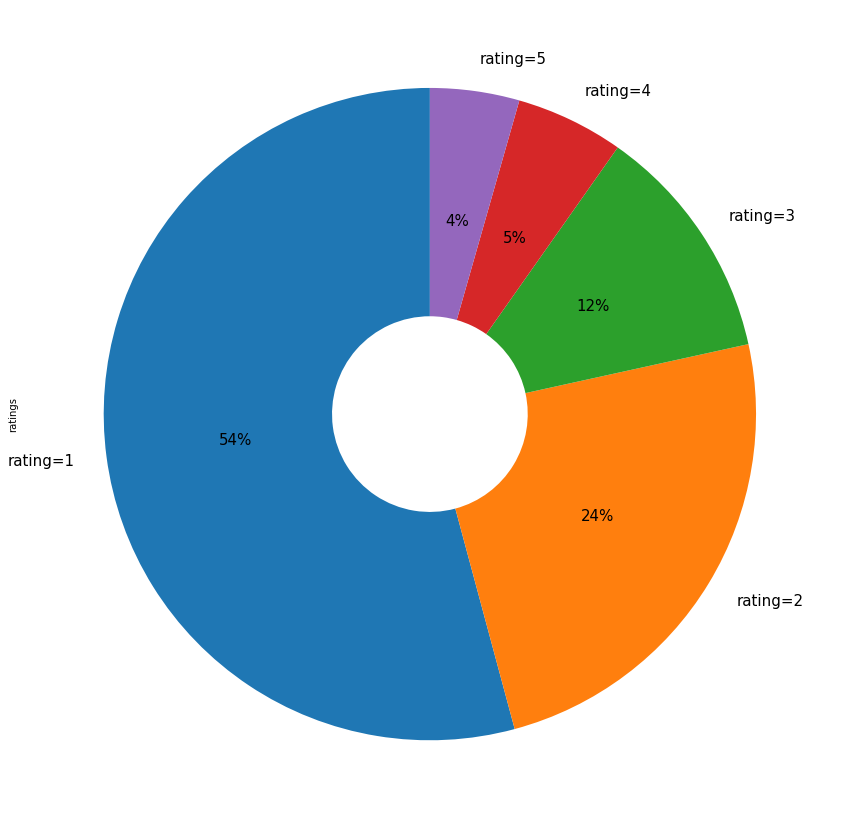

In [37]:
df2.ratings.value_counts().plot(kind='pie', 
                labels = ['rating=1','rating=2', 'rating=3', 'rating=4', 'rating=5'],
                wedgeprops=dict(width=.7),
                autopct='%1.0f%%', startangle= 90, 
                textprops={'fontsize': 15},
                figsize = (30,15))

**Let's use a word cloud to show the 50 most common words for each rating.**

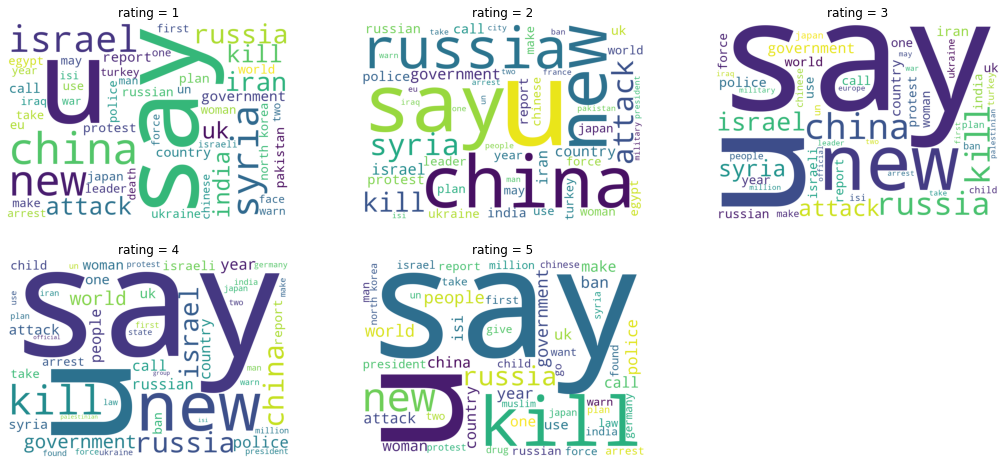

In [38]:
ncols = 3
nrows = 2
fig = plt.gcf()
fig.set_size_inches(ncols*6, nrows*4)
for idx , rating in enumerate(set(df2['ratings'])):
    plt.subplot(nrows,ncols,idx+1).axis('Off')
    plt.title(f'rating = {rating}')
    plt.imshow(WordCloud(max_words=50, width = 1000, height = 700, background_color='white').generate(' '.join(df2.loc[df2['ratings'] == rating, 'title_processed_joined'])))

#plt.subplots_adjust(wspace=0.90, hspace=0.3)
plt.show()

In [39]:
# Let's filter the word 'say' which appears to cloud the other important words

def remove_say(words_list):
    return [token for token in words_list if token != 'say']

df_filtered = df2.copy()
df_filtered['title_processed'] = df_filtered['title_processed'].apply(remove_say)
df_filtered['title_processed_joined'] = df_filtered['title_processed'].apply(lambda x: ' '.join(x))

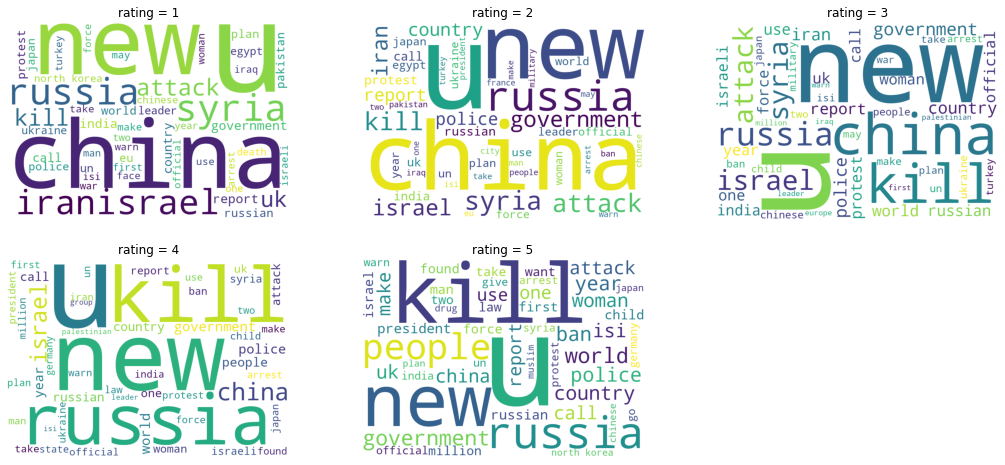

In [40]:
# Let's plot it again

ncols = 3
nrows = 2
fig = plt.gcf()
fig.set_size_inches(ncols*6, nrows*4)
for idx , rating in enumerate(set(df_filtered['ratings'])):
    plt.subplot(nrows,ncols,idx+1).axis('Off')
    plt.title(f'rating = {rating}')
    plt.imshow(WordCloud(max_words=50, width = 1000, height = 700, background_color='white').generate(' '.join(df_filtered.loc[df_filtered['ratings'] == rating, 'title_processed_joined'])))

#plt.subplots_adjust(wspace=0.90, hspace=0.3)
plt.show()

**Some conclusions** :
<br>
1. Lower rated news seem to be centered around words like new, China and the word 'u' which actually is US if we check back the un-processed texts. 
2. The word 'new' could be related to something new happening around the world like a 'new' law passed somewhere or a new president/prime minister elected and so on.
3. Higher rated or news with most upvotes belong to the words like 'kill', 'russia', etc apart from the previously seen words from lower rated news like 'u' and 'new'. 'kill' is probably related to killings related to terrorism mostly given that these seem to be mostly global news.

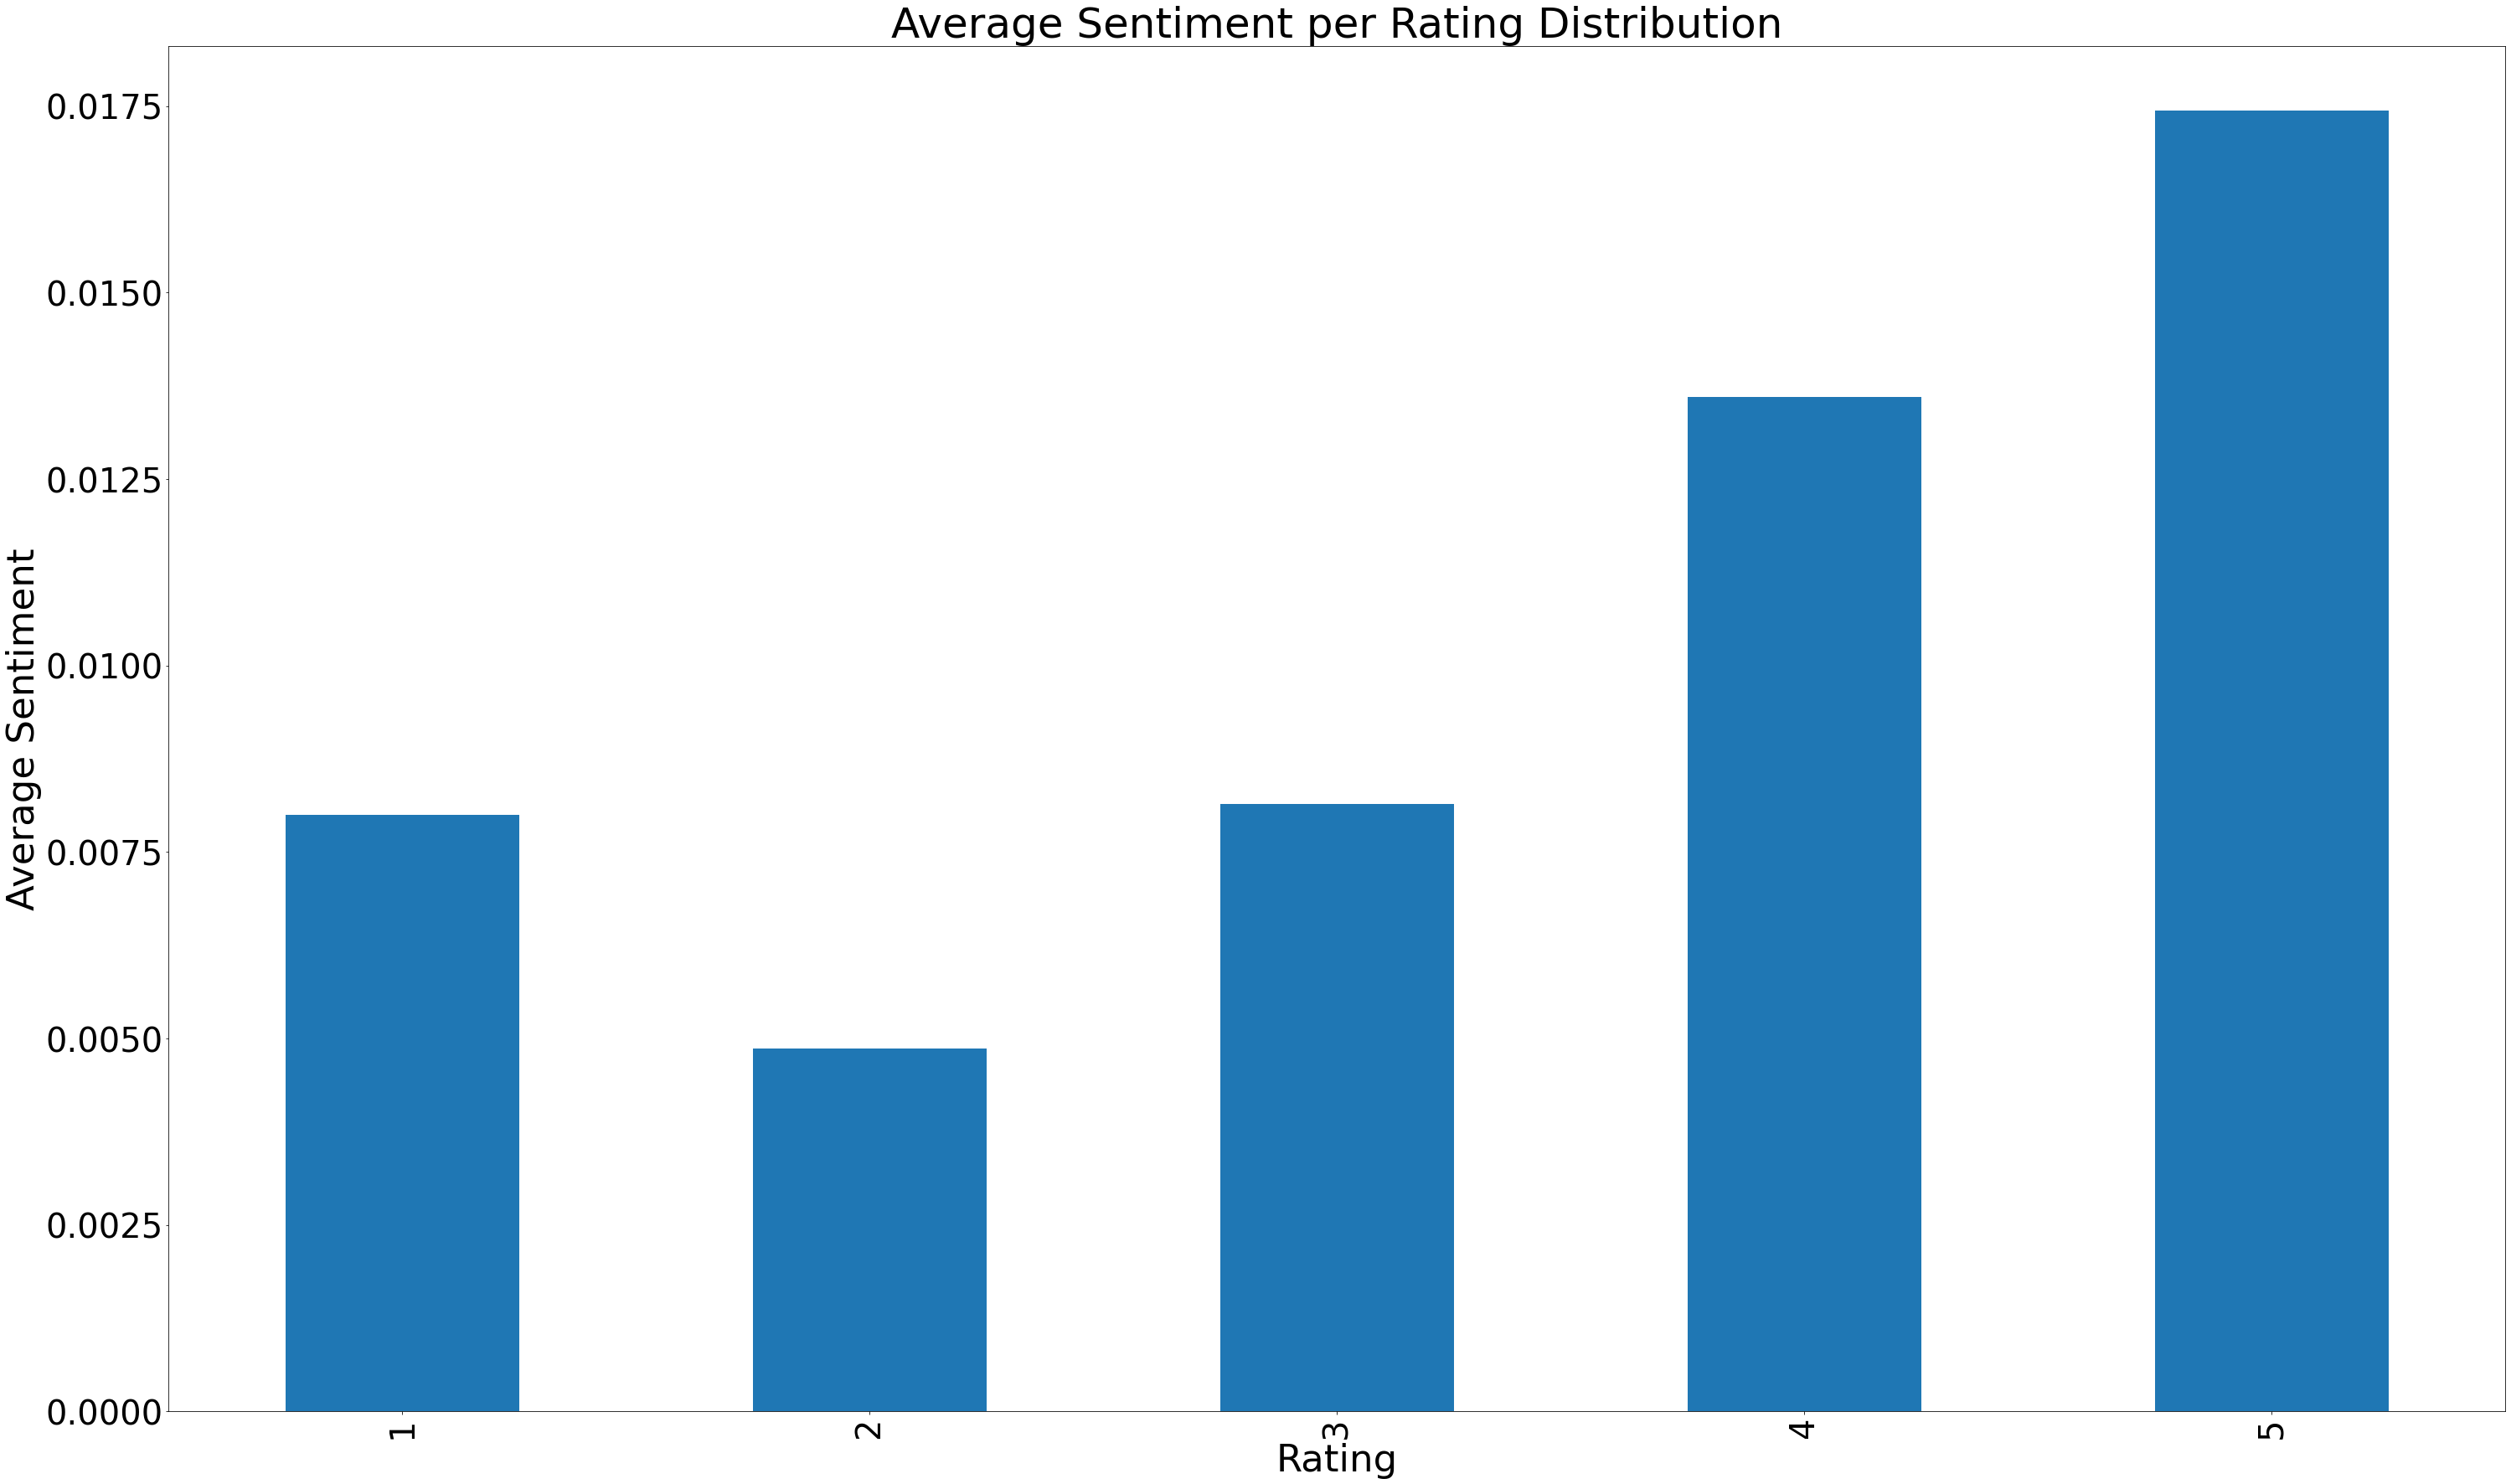

In [41]:
## Average sentiment polarity per rating
## Probably not a lot to be extracted given that the dataset appears to be pretty neutral sentiment-wise

polarity_avg = df_filtered.groupby('ratings')['sentiment'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Rating Distribution', fontsize=50)
plt.show()

Even though there is a positive sentiment for all of them with the rating 5 taking the lead, this does not tell us much since the differences in the polarities as well as the polarity values themselves are quite tiny. 

How about the number of words in each of these classes of ratings? Could there be any correlation of that to the ratings? Let's see

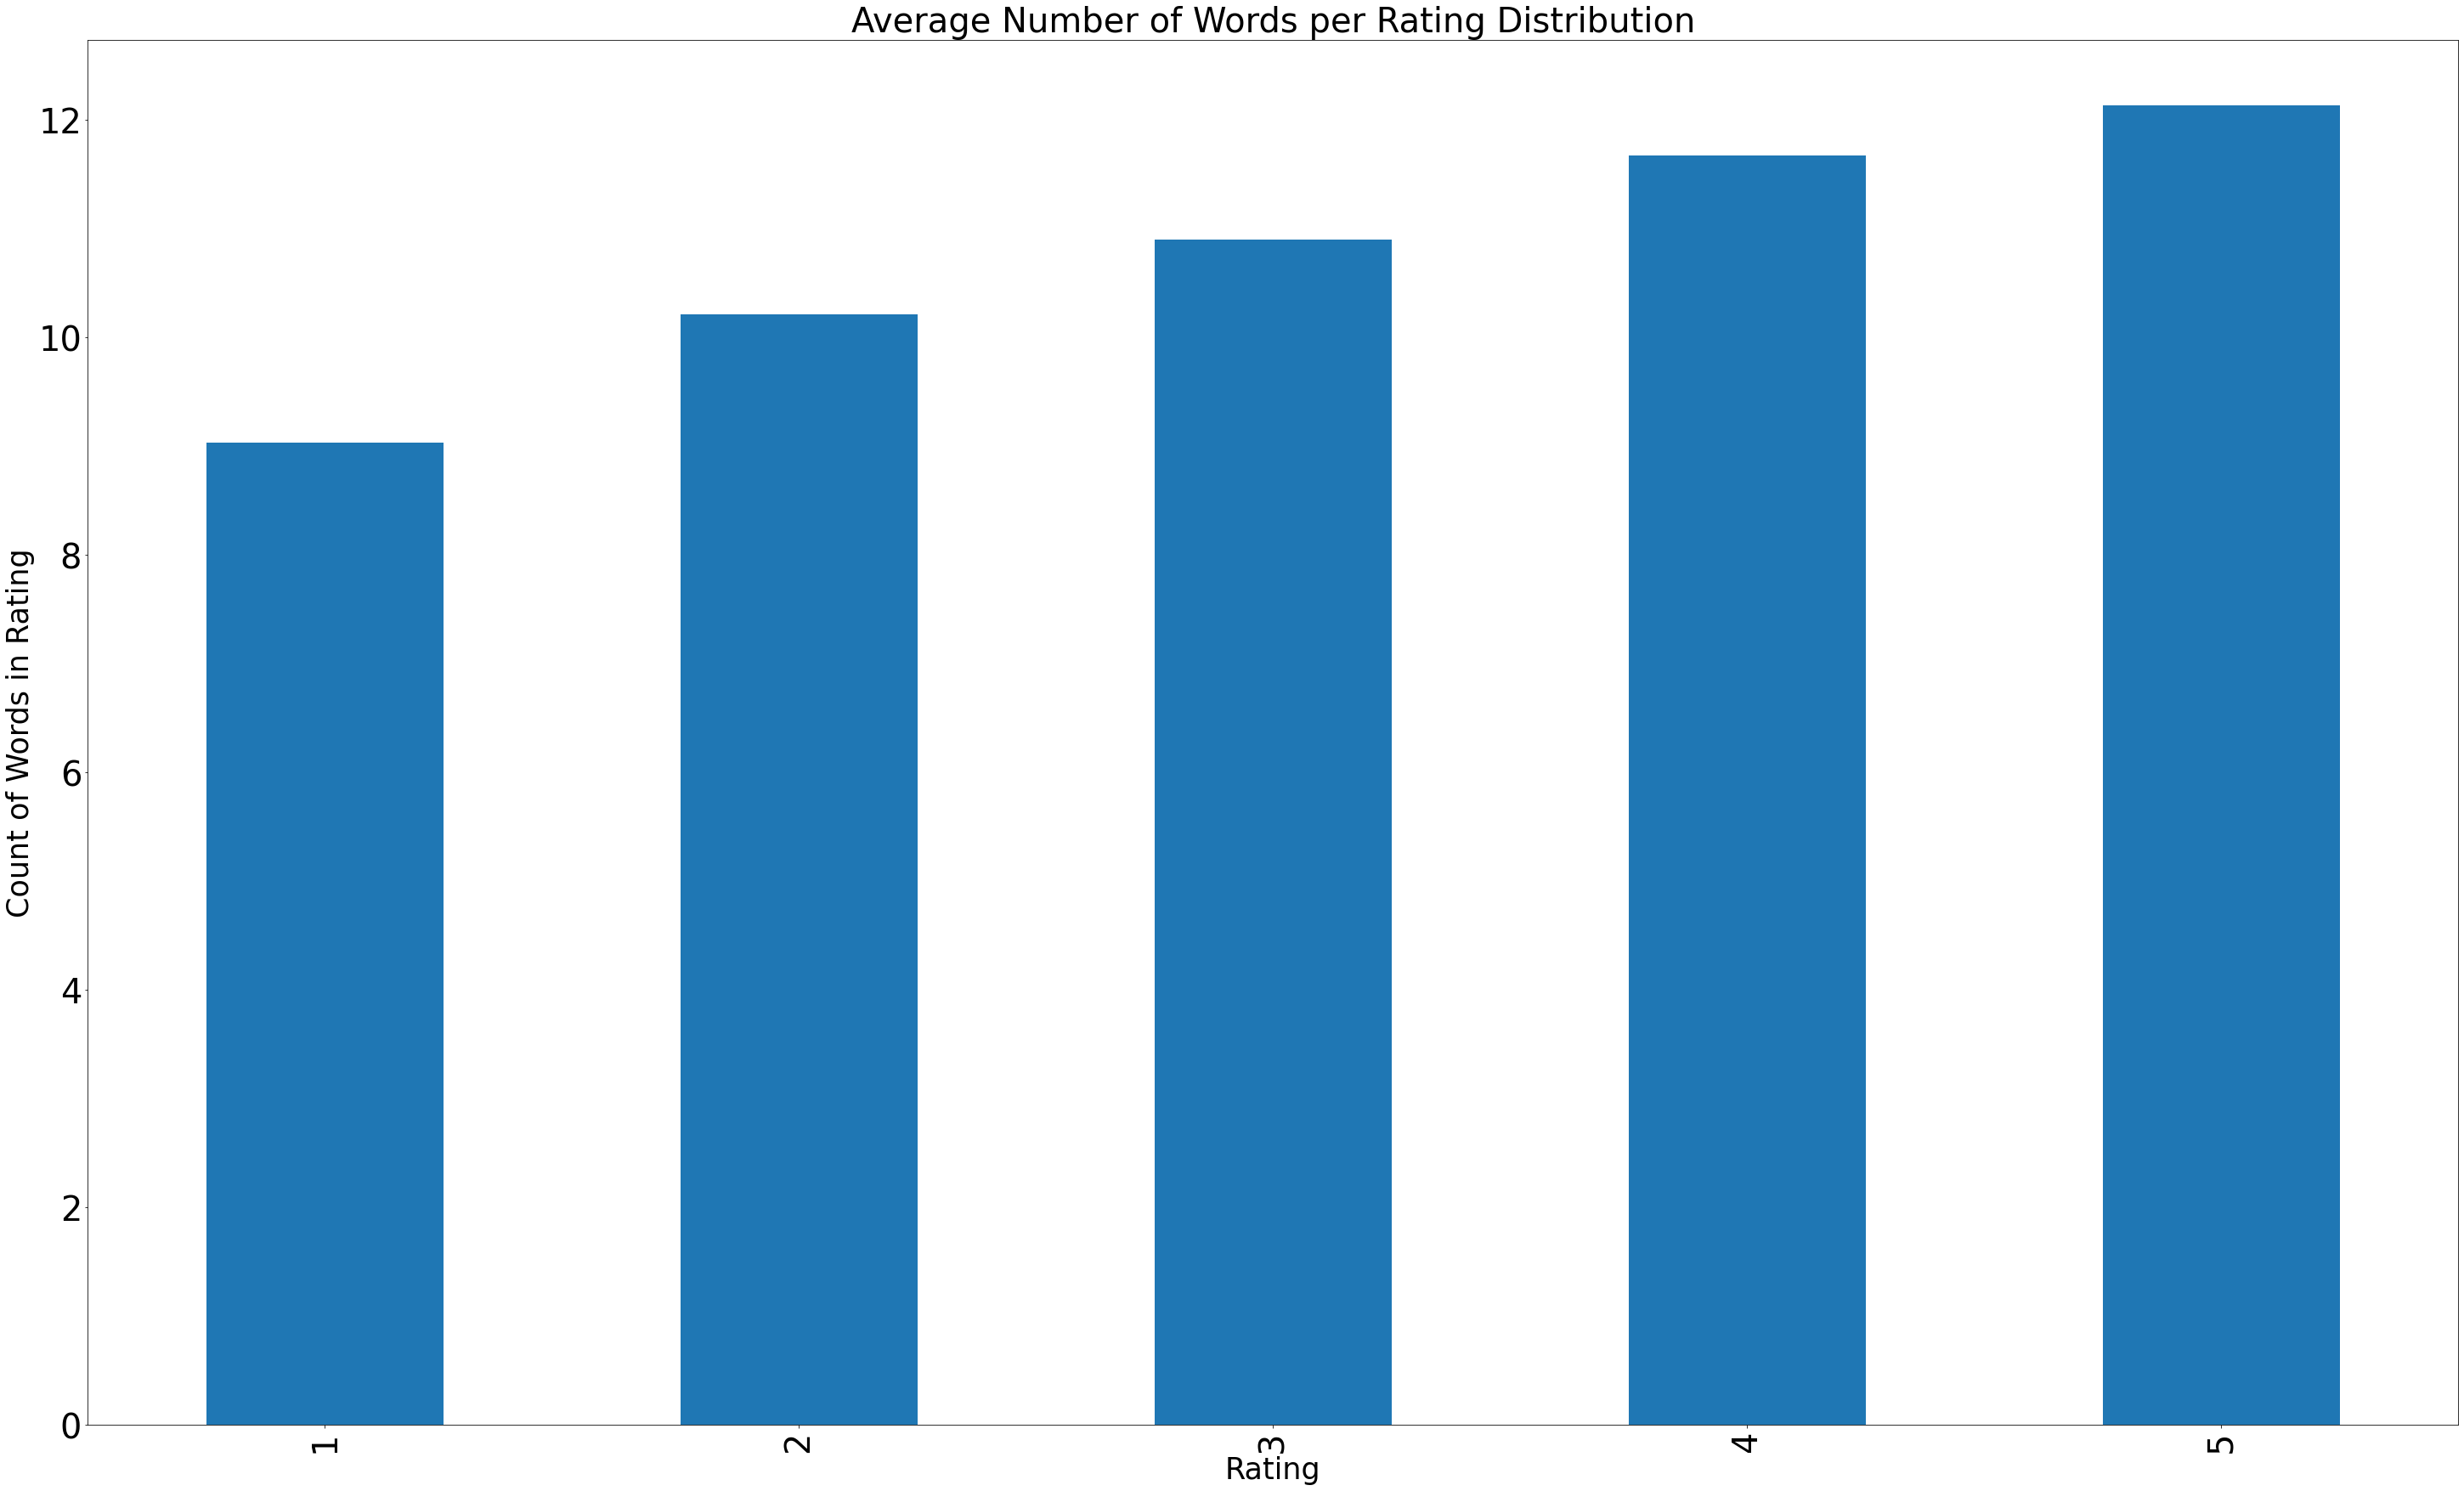

In [42]:
## First have to find the word count for each rating..
df2['word_count'] = df2['title_processed'].apply(lambda x:len(x))

## let's plot the mean number of words
word_avg = df2.groupby('ratings')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Words in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Rating Distribution', fontsize=40)
plt.show()

**High rated news texts seem to be having more words on average. Even though there isn't a big difference, there is a clear trend of this increase in news (or headline) length with upvotes.**

## Topic Modeling

Now comes the most interesting part (at least for me 😊) . Here, we will extract the most frequently discussed topics from the texts provided. We will use non-negative matrix factorization for this purpose where the basic idea is to achieve a dimensionalty reduction of the entire feature matrix for all the samples through its factorization. We will use the decomposition module in sklearn for this. But first we need to create a features matrix using the TfidfVectorizer that uses TF-IDF internally to find the weightage of each feature (an n-gram).

In [43]:
# Max_df=0.9 will remove words that appear in more than 90% of the reviews. 
# Min_df=25 will remove words that appear in less than 25 reviews.
# Will use the default Frobenius objective function to minimize 

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000)
tfidf = tfidf_vectorizer.fit_transform(df2['title_processed_joined'])

In [44]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))

In [45]:
doc_term_matrix_tfidf.sample(10)

abandon  abbas  abbott  abc    abduct  abduction  abdullah  abe  \
49767      0.0    0.0     0.0  0.0  0.000000        0.0       0.0  0.0   
44628      0.0    0.0     0.0  0.0  0.000000        0.0       0.0  0.0   
13608      0.0    0.0     0.0  0.0  0.000000        0.0       0.0  0.0   
89854      0.0    0.0     0.0  0.0  0.000000        0.0       0.0  0.0   
19990      0.0    0.0     0.0  0.0  0.000000        0.0       0.0  0.0   
36908      0.0    0.0     0.0  0.0  0.000000        0.0       0.0  0.0   
65905      0.0    0.0     0.0  0.0  0.643707        0.0       0.0  0.0   
51458      0.0    0.0     0.0  0.0  0.000000        0.0       0.0  0.0   
54931      0.0    0.0     0.0  0.0  0.000000        0.0       0.0  0.0   
13151      0.0    0.0     0.0  0.0  0.000000        0.0       0.0  0.0   

       ability  able  ...  yuan  zealand  zero  zika  zimbabwe  zimbabwean  \
49767      0.0   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0   
44628      0.0   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0   
13608      0.0   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0   
89854      0.0   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0   
19990      0.0   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0   
36908      0.0   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0   
65905      0.0   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0   
51458      0.0   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0   
54931      0.0   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0   
13151      0.0   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0   

       zionist  zone  zoo  zuma  
49767      0.0   0.0  0.0   0.0  
44628      0.0   0.0  0.0   0.0  
13608      0.0   0.0  0.0   0.0  
89854      0.0   0.0  0.0   0.0  
19990      0.0   0.0  0.0   0.0  
36908      0.0   0.0  0.0   0.0  
65905      0.0   0.0  0.0   0.0  
51458      0.0   0.0  0.0   0.0  
54931      0.0   0.0  0.0   0.0  
13151      0.0   0.0  0.0   0.0  

[10 rows x 4550 columns]

In [46]:
# function to show the top 10 topics from the dataset based on the NMF analysis

def display_topics(model, feature_names, num_top_words):
    for topic_id, topic in enumerate(model.components_):
        print(f'Topic : {topic_id}')
        print(' '.join([feature_names[i]
                          for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [47]:
nmf = NMF(n_components=10, alpha=.05, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, 10)

Topic : 0
new world year news government uk protest first woman police
Topic : 1
korea north south korean missile nuclear test launch kim un
Topic : 2
kill least people bomb pakistan strike suicide soldier blast militant
Topic : 3
china sea south chinese japan dispute island military beijing taiwan
Topic : 4
syria state islamic syrian rebel isi war iraq fight weapon
Topic : 5
iran nuclear deal talk saudi sanction power obama plant arabia
Topic : 6
russia ukraine putin russian sanction eu crimea military crisis nato
Topic : 7
say official minister un president report group right chief may
Topic : 8
israel palestinian gaza israeli hamas un war bank west rocket
Topic : 9
attack police suspect arrest paris terror dead terrorist suicide bomb


/Users/jyotisman/miniforge3/envs/nlp_env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


We can now deduce the topics with a lit bit of intuition. I label them as follows. Topic 7 is a bit hard to tell but maybe a mapping to the actual news texts will tell us what it is.
<br>

**Topic 0** : Unknown1? 
<br>
**Topic 1** : North and South Korea tensions
<br>
**Topic 2** : Terrorism in Pakistan
<br>
**Topic 3** : China Japan territory dispute
<br>
**Topic 4** : Syria and ISI
<br>
**Topic 5** : Iran nuclear sanctions
<br>
**Topic 6** : Russia-Ukraine dispute (sanctions on Russia)
<br>
**Topic 7** : Unknown2?
<br>
**Topic 8** : Israel-Palestine war
<br>
**Topic 9** : Paris terrorism incidents

In [48]:
nmf_topic_values = nmf.transform(tfidf)
df2['nmf_topics'] = nmf_topic_values.argmax(axis=1)

In [49]:
nmf_map = {0: 'Unknown1?', 1: 'North and South Korea tensions', 2: 'Terrorism in Pakistan', 3: 'China Japan territory dispute', 
             4: 'Syria and ISI', 5: 'Iran nuclear sanctions', 6: 'Russia-Ukraine dispute (sanctions on Russia)', 7: ' Unknown2?', 
             8: 'Israel-Palestine war', 9: 'Paris terrorism incidents'}
df2['nmf_topics'] = df2['nmf_topics'].map(nmf_map)

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

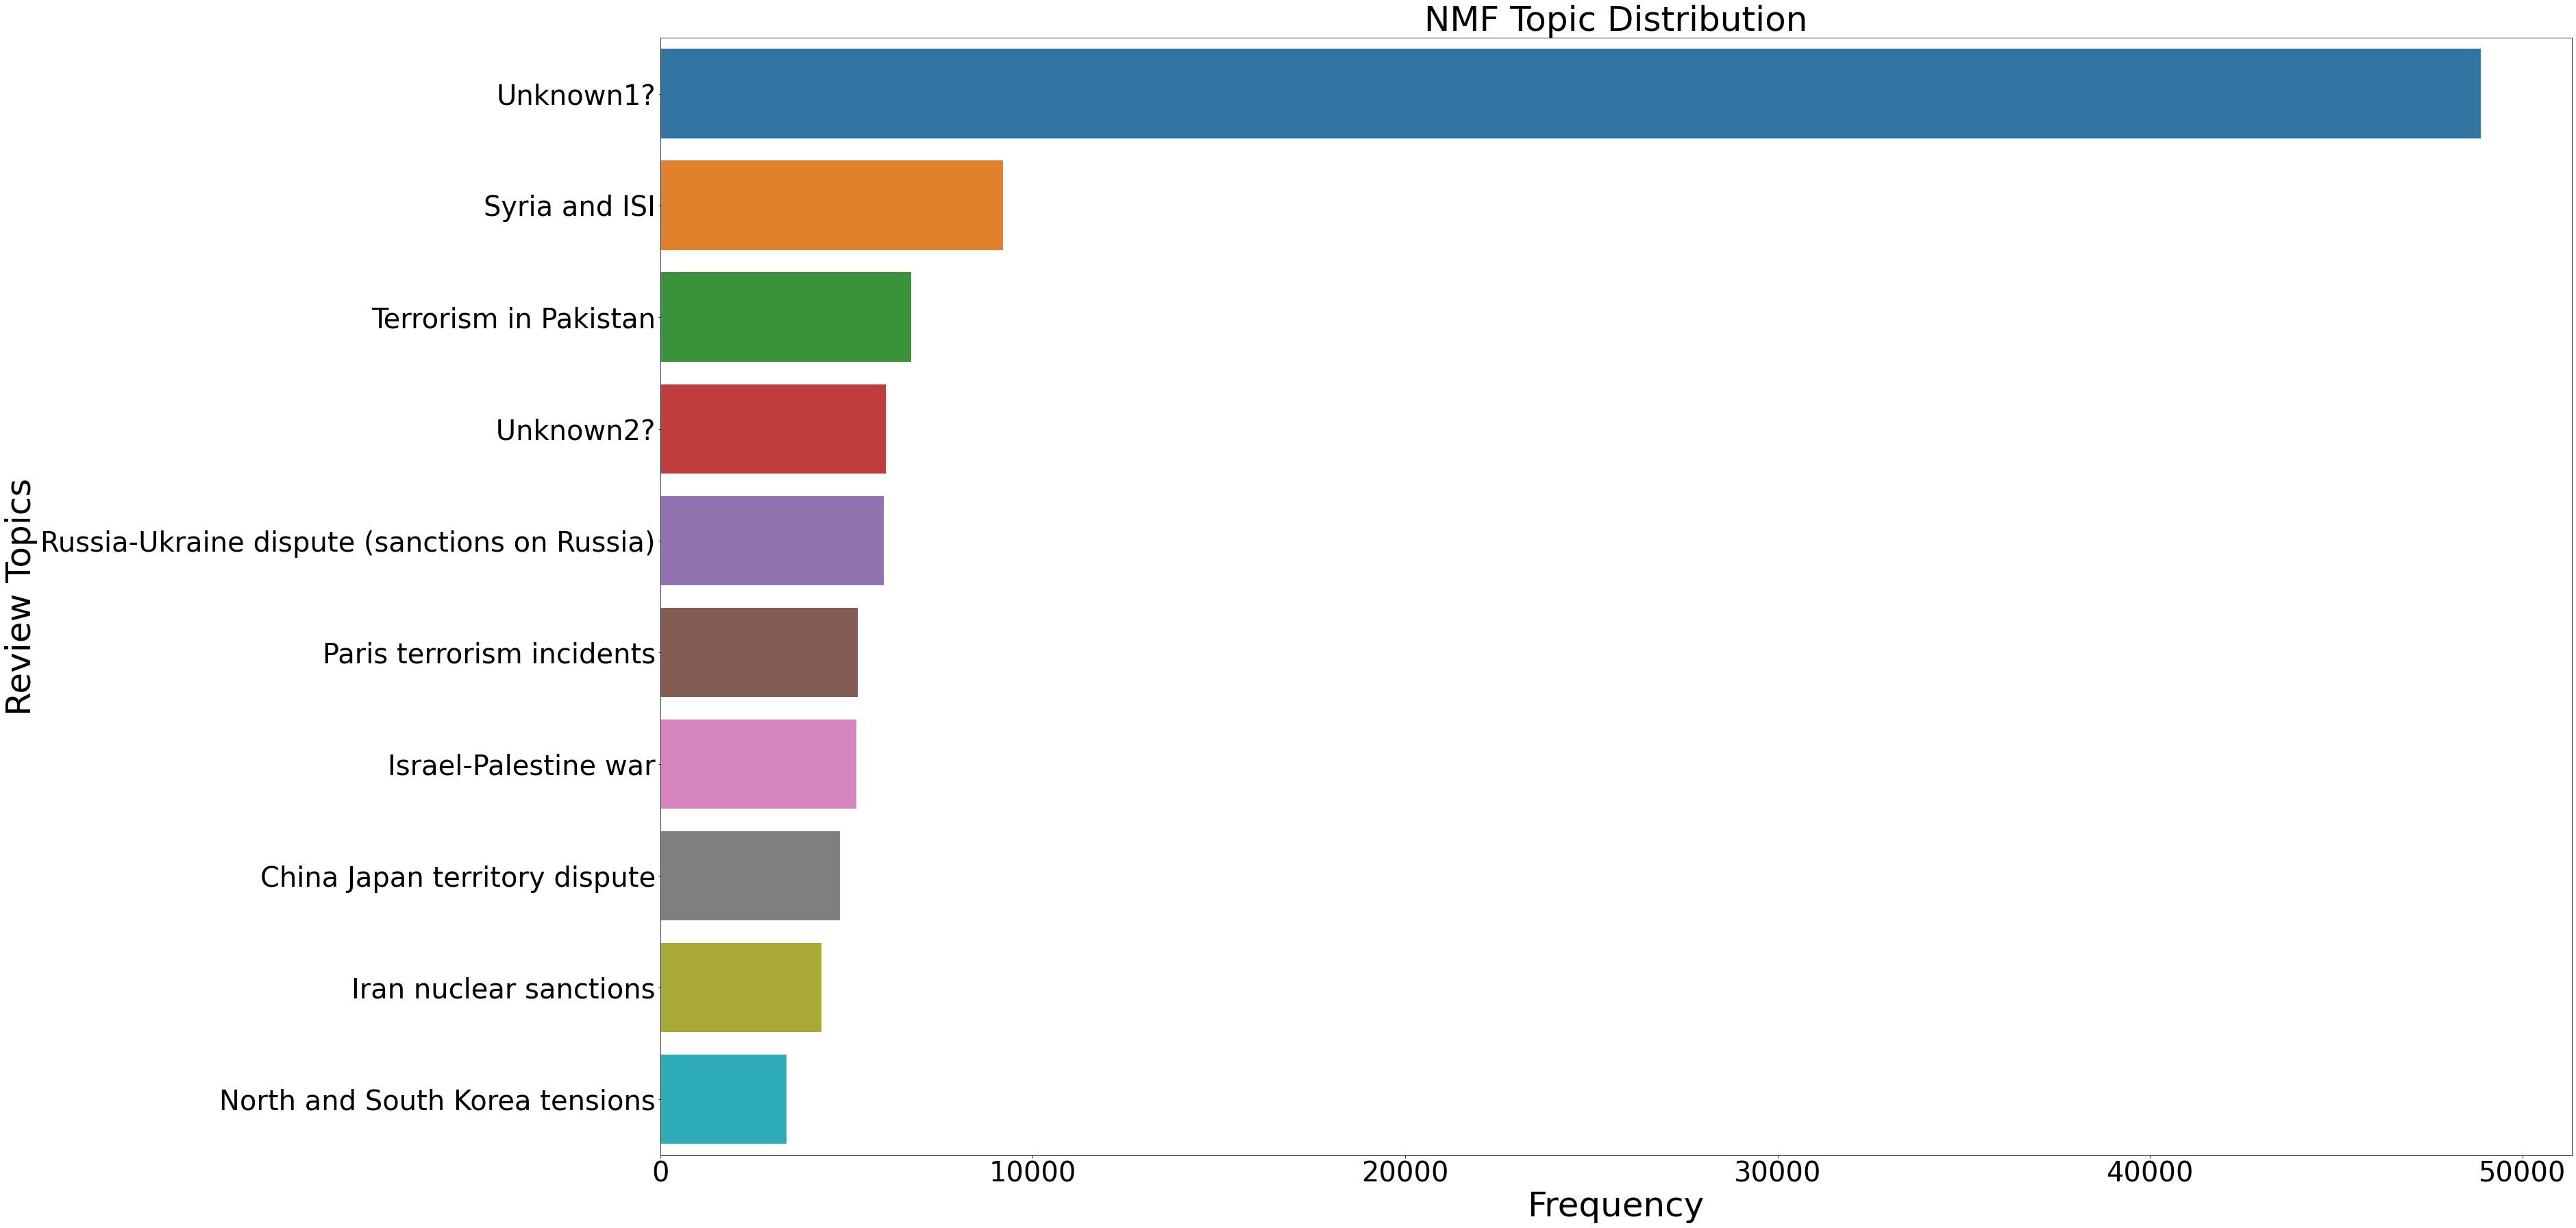

In [50]:
nmf_x = df2['nmf_topics'].value_counts()
nmf_y = list(nmf_x.index)
plt.figure(figsize=(50,30))
sns.barplot(x = nmf_x, y = nmf_y)
plt.title("NMF Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

In [51]:
df2.sample(10)

index  time_created date_created  up_votes  \
59407  489153    1472801867   2016-09-02       205   
63691  353912    1426585191   2015-03-17         2   
93960  120618    1334991499   2012-04-21         9   
47186  352710    1426247726   2015-03-13        31   
25385  118809    1333448808   2012-04-03         4   
34123   65113    1285887279   2010-09-30         4   
24249  209803    1378142427   2013-09-02         3   
24944  149767    1355128156   2012-12-10         0   
30463  392502    1440784423   2015-08-28         1   
82057  406104    1445291525   2015-10-19         4   

                                                   title  over_18  \
59407  Christian neighborhood, courts targeted in twi...    False   
63691  British Airways flight forced to land early du...    False   
93960  China has freed 21 Vietnamese fishermen detain...    False   
47186  NASA launches four spacecraft to solve magneti...    False   
25385  Syria promises to pull forces from population ...    False   
34123       Protesting police throw Ecuador into chaos      False   
24249  The FDLR in North and South Kivu: A State with...    False   
24944  BBC News - Duchess hoax: Australian presenters...    False   
30463  Colombia and Venezuela recall ambassadors amid...    False   
82057      Pet dogs originated in Nepal, Mongolia: study    False   

                author                                    title_processed  \
59407    petergiovanni  [christian, neighborhood, court, target, twin,...   
63691      AdrianBlake  [british, airway, flight, force, land, early, ...   
93960      geoinformer  [china, freed, vietnamese, fisherman, detain, ...   
47186       EvilPundit  [nasa, launch, four, spacecraft, solve, magnet...   
25385     Bookworm1979  [syria, promise, pull, force, population, cent...   
34123         soupdawg           [protest, police, throw, ecuador, chaos]   
24249            99red  [fdlr, north, south, kivu, state, within, stat...   
24944         scellend  [bbc, news, duchess, hoax, australian, present...   
30463     isaacbonyuet  [colombia, venezuela, recall, ambassador, amid...   
82057  HeinieKaboobler      [pet, dog, originate, nepal, mongolia, study]   

                                  title_processed_joined  sentiment  ratings  \
59407  christian neighborhood court target twin attac...   0.000000        4   
63691  british airway flight force land early due par...   0.035417        1   
93960  china freed vietnamese fisherman detain last m...   0.050000        2   
47186  nasa launch four spacecraft solve magnetic mys...   0.000000        3   
25385  syria promise pull force population center cnncom  -0.100000        1   
34123                 protest police throw ecuador chaos   0.000000        1   
24249  fdlr north south kivu state within state under...   0.000000        1   
24944  bbc news duchess hoax australian presenter gut...   0.000000        1   
30463  colombia venezuela recall ambassador amid bord...   0.000000        1   
82057             pet dog originate nepal mongolia study   0.000000        1   

       word_count                      nmf_topics  
59407           7       Paris terrorism incidents  
63691          10                       Unknown1?  
93960          15   China Japan territory dispute  
47186           7  North and South Korea tensions  
25385           7                   Syria and ISI  
34123           5                       Unknown1?  
24249           9  North and South Korea tensions  
24944           8                       Unknown1?  
30463           7                       Unknown1?  
82057           6                       Unknown1?

**We capture some topics while miss some others quite badly.** 

## Yearwise Topic modeling with NMF

Even though we are able to capture the right topic for some news, we are way off in some other categories. The reason being that there are way too many categories than 10. A better characterization would come from doing the same but now yearwise since we have a datetime column. Let's see how that works out.

In [52]:
df['date_created'] =  pd.to_datetime(df['date_created'])
df['year'] = df.date_created.dt.year

In [53]:
df.year.value_counts()

2015    94621
2014    92030
2013    88231
2016    81892
2012    42643
2011    38886
2009    25115
2010    23313
2008    22505
Name: year, dtype: int64

In [54]:
# process the entire dataset now. Does take some time. Could use some parallelism later to speed it up (like swifter or a spark dataframe).
# Maybe for later. Certainly need to use it for a larger dataset. We also filter the word 'say' from the entire dataset.

df['title_processed'] = df['title'].apply(process_text).apply(remove_say)

df['title_processed_joined'] = df['title_processed'].apply(lambda x: ' '.join(x))

In [55]:
df.loc[df['year']==2016,'title_processed_joined']

427344    dubai new year firework go ahead fire engulfs ...
427345    iran denies fire rocket near u warship gulf co...
427346    geneediting injection could one day offer hope...
427347    south china sea teen camp dispute land young a...
427348    china jail activist support hong kong democrac...
                                ...                        
509231    heil trump donald trump altright white nationa...
509232              people speculate could madeleine mccann
509233             professor receives arab researcher award
509234    nigel farage attack response trump ambassador ...
509235    palestinian wield knife shot dead west bank is...
Name: title_processed_joined, Length: 81892, dtype: object

Let's first look at the **most common words** in worldnews yearwise to get a quick idea about the topics

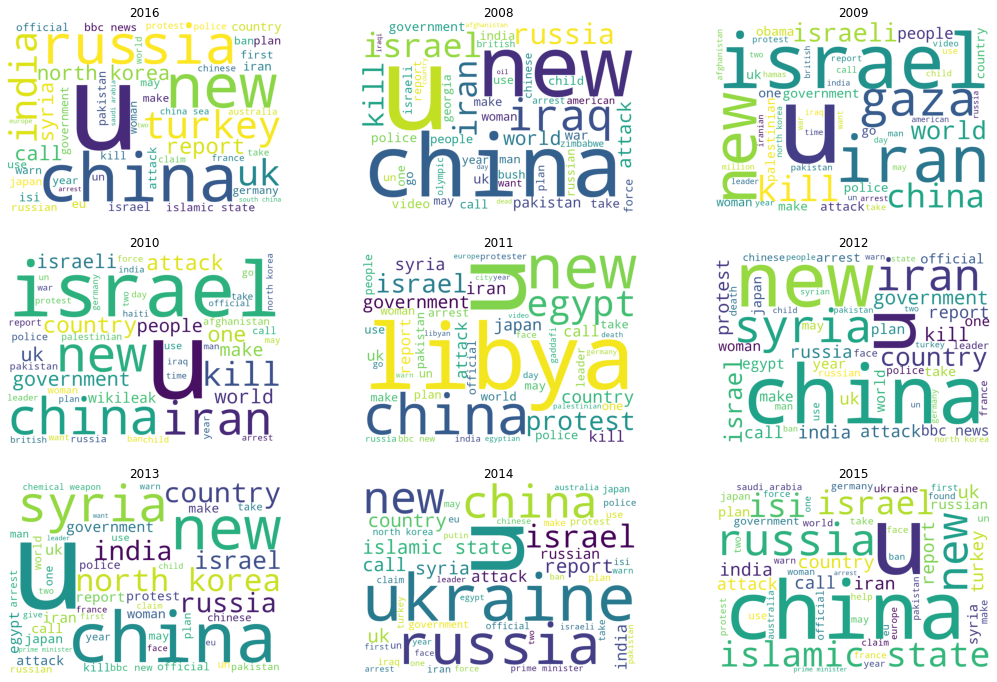

In [56]:
ncols = 3
nrows = 3
fig = plt.gcf()
fig.set_size_inches(ncols*6, nrows*4)
for idx , year in enumerate(set(df.year)):
    plt.subplot(nrows,ncols,idx+1).axis('Off')
    plt.title(f'{year}')
    plt.imshow(WordCloud(max_words=50, width = 1000, height = 700, background_color='white').generate(' '.join(df.loc[df['year'] == year, 'title_processed_joined'])))

#plt.subplots_adjust(wspace=0.90, hspace=0.3)
plt.show()

Now we will go a step ahead and try to find some popular news topics each year. First let's defne some functions we will use for plotting. 

In [57]:
# Taken from -
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [58]:
# Apart from plotting the frequently used words, we use the upvotes column to look at the popularity of each topic.

def plot_popular_topics(nmf, tfidf_feature_names, n_top_words, title, year):
    
    plot_top_words(nmf, tfidf_feature_names, 10,
               title)

    df_copy = df.loc[df['year']==year,:].reset_index()
    nmf_topic_values = nmf.transform(tfidf)
    df_copy['nmf_topics'] = nmf_topic_values.argmax(axis=1)

    nmf_remap = {0: 'Topic 1', 1: 'Topic 2', 2: 'Topic 3', 3: 'Topic 4', 
                 4: 'Topic 5', 5: 'Topic 6', 6: 'Topic 7', 7: 'Topic 8', 
                 8: 'Topic 9', 9: 'Topic 10'}
    df_copy['nmf_topics'] = df_copy['nmf_topics'].map(nmf_remap)

    nmf_x = df_copy.groupby('nmf_topics')['up_votes'].mean().sort_values(ascending=False)
    nmf_y = list(nmf_x.index)
    plt.figure(figsize=(50,30))
    sns.barplot(x = nmf_x, y = nmf_y)
    plt.title("NMF Topic popularities", fontsize=50)
    plt.ylabel('Topics', fontsize=50)
    plt.yticks(fontsize=40)
    plt.xlabel('Mean up_votes', fontsize=50)
    plt.xticks(fontsize=40)
    plt.show()

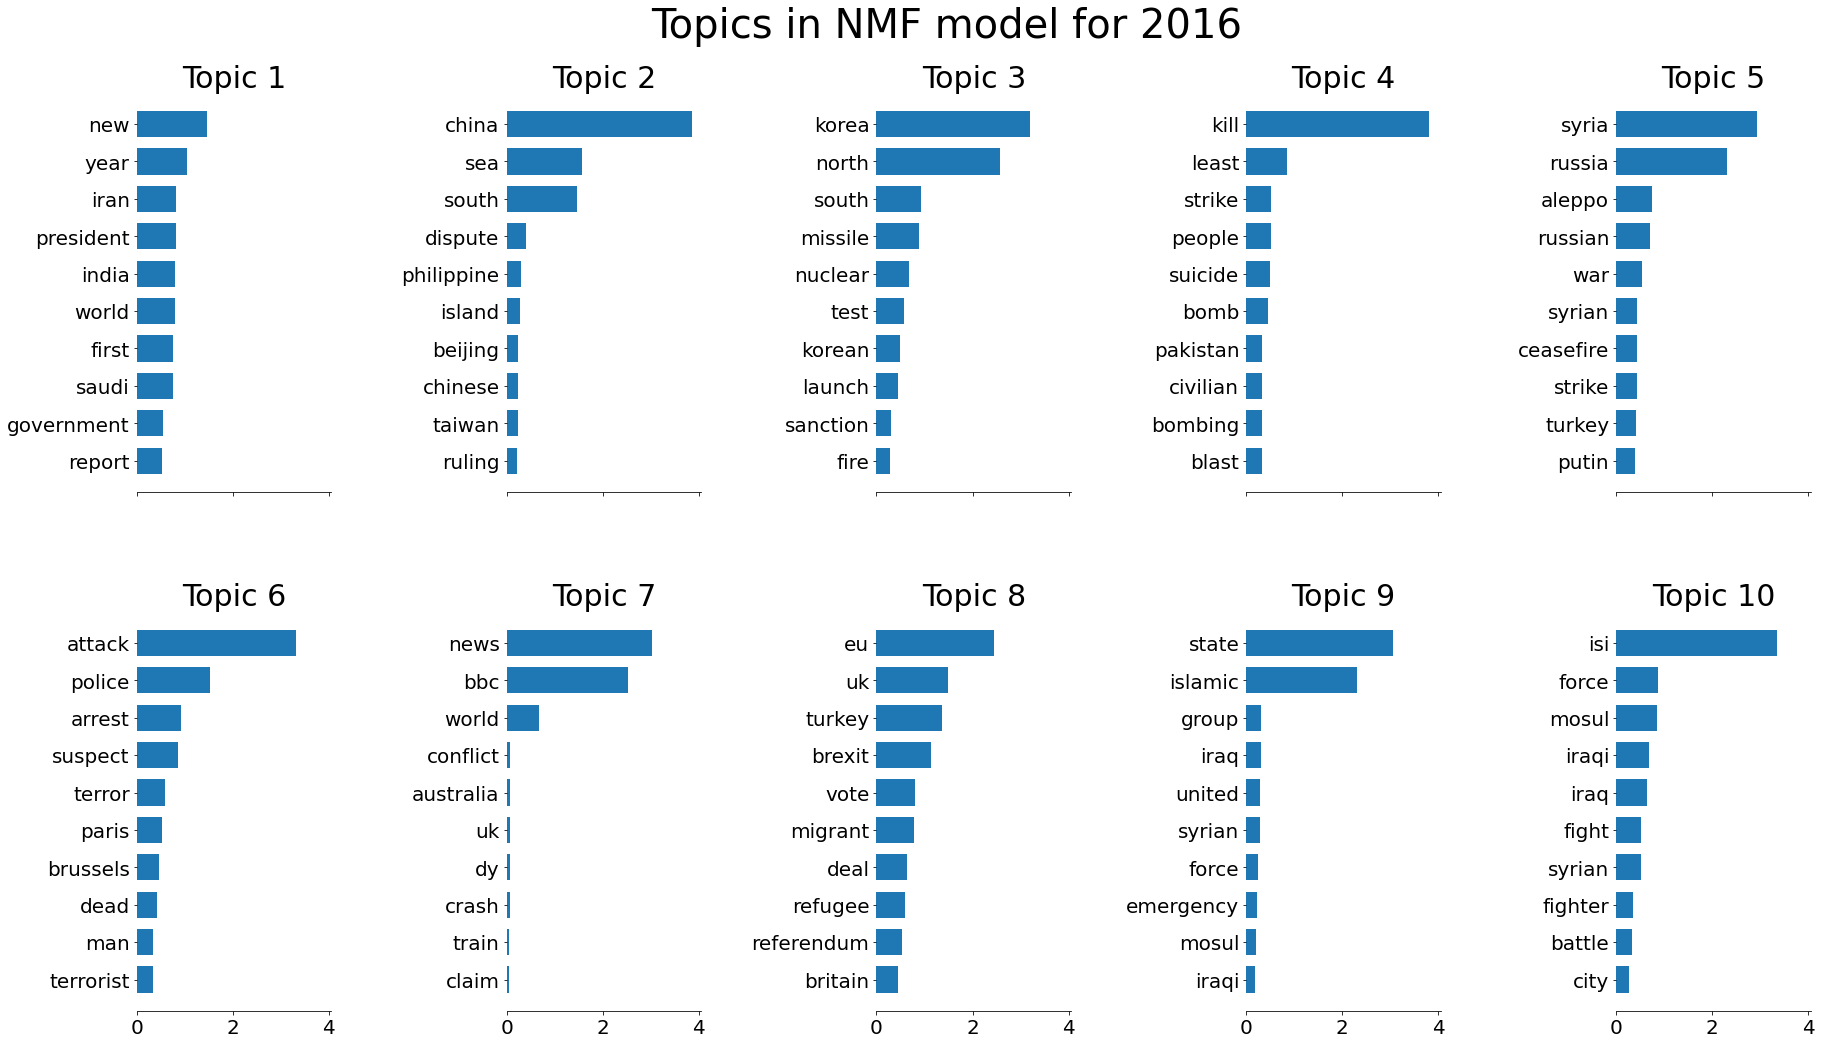

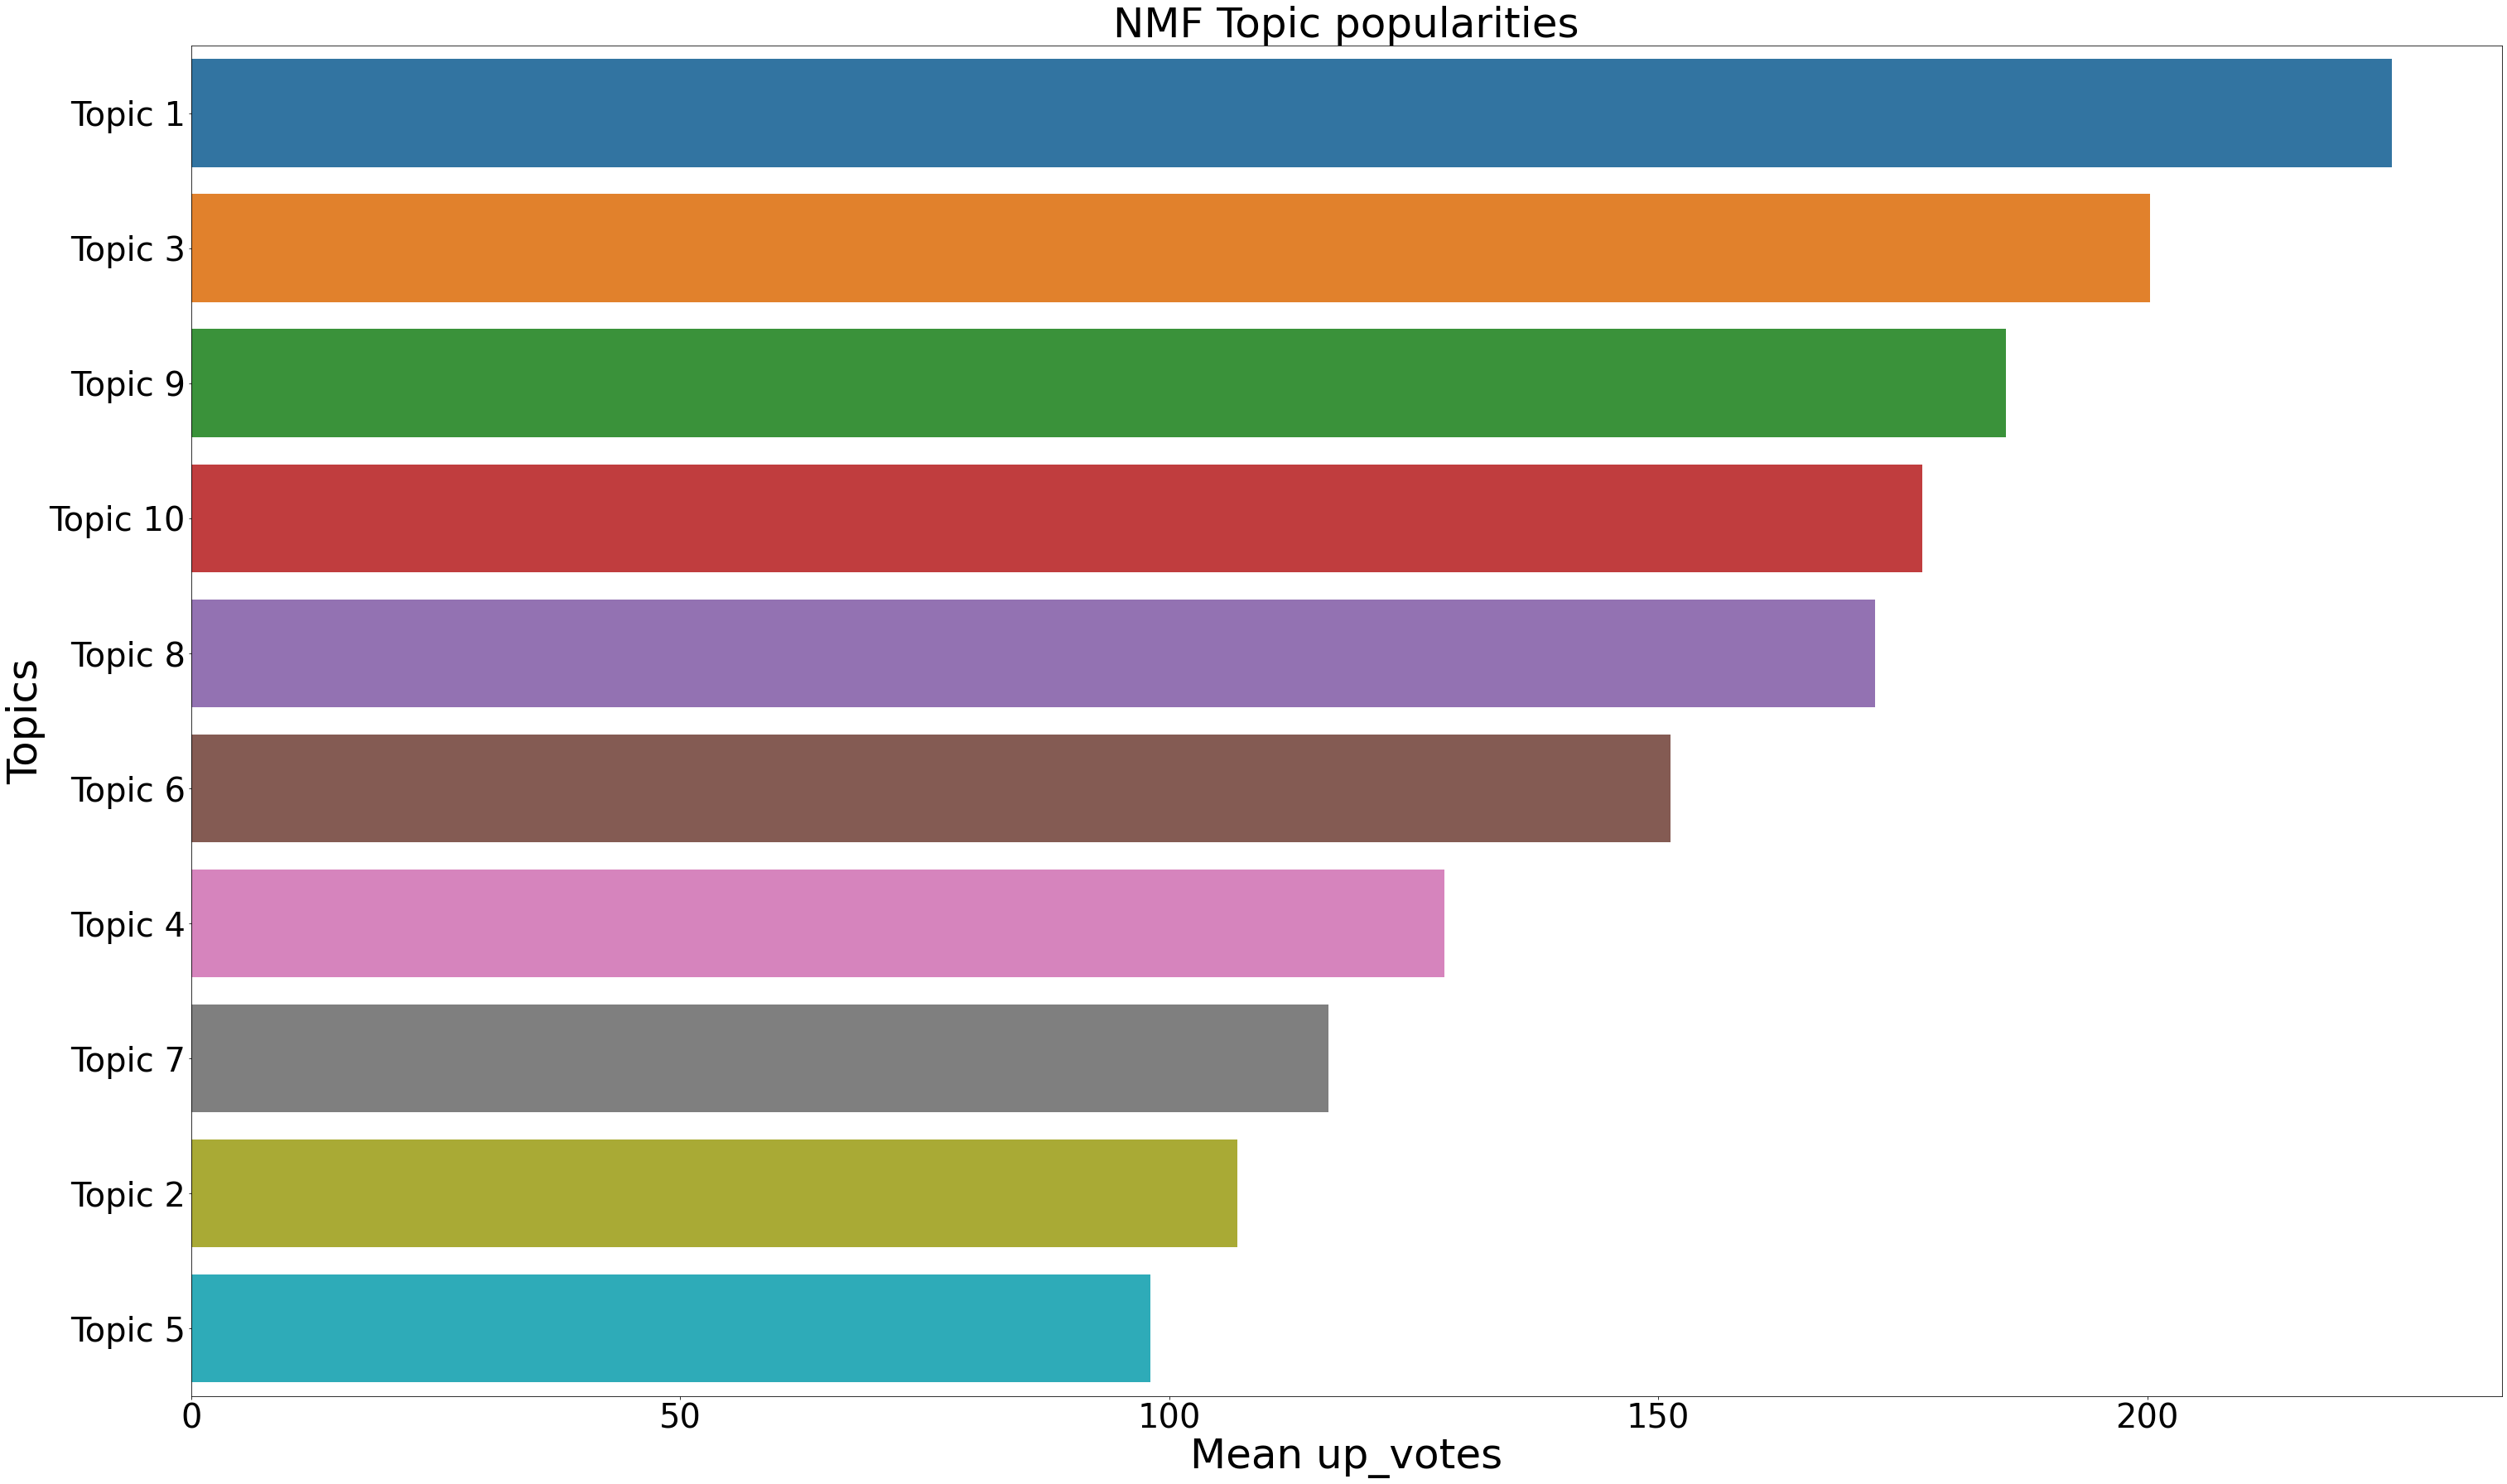

In [59]:
year = 2016

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =20, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year}', year)

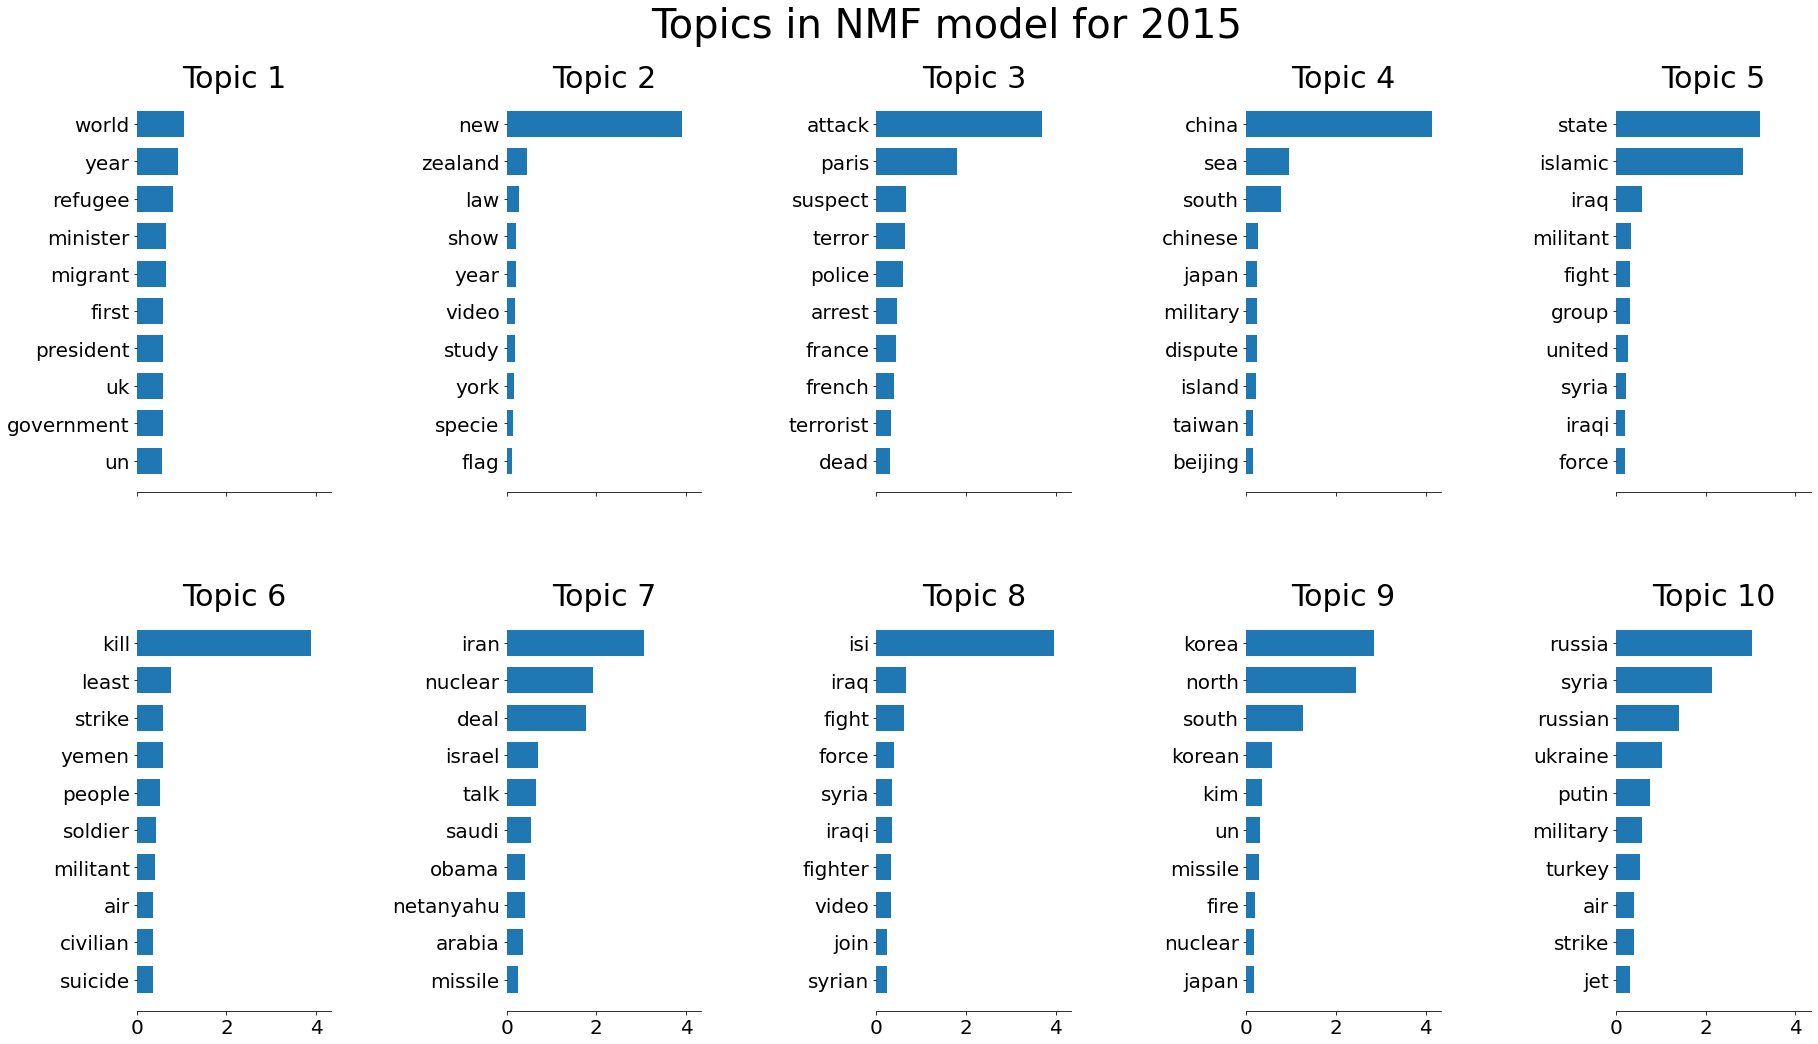

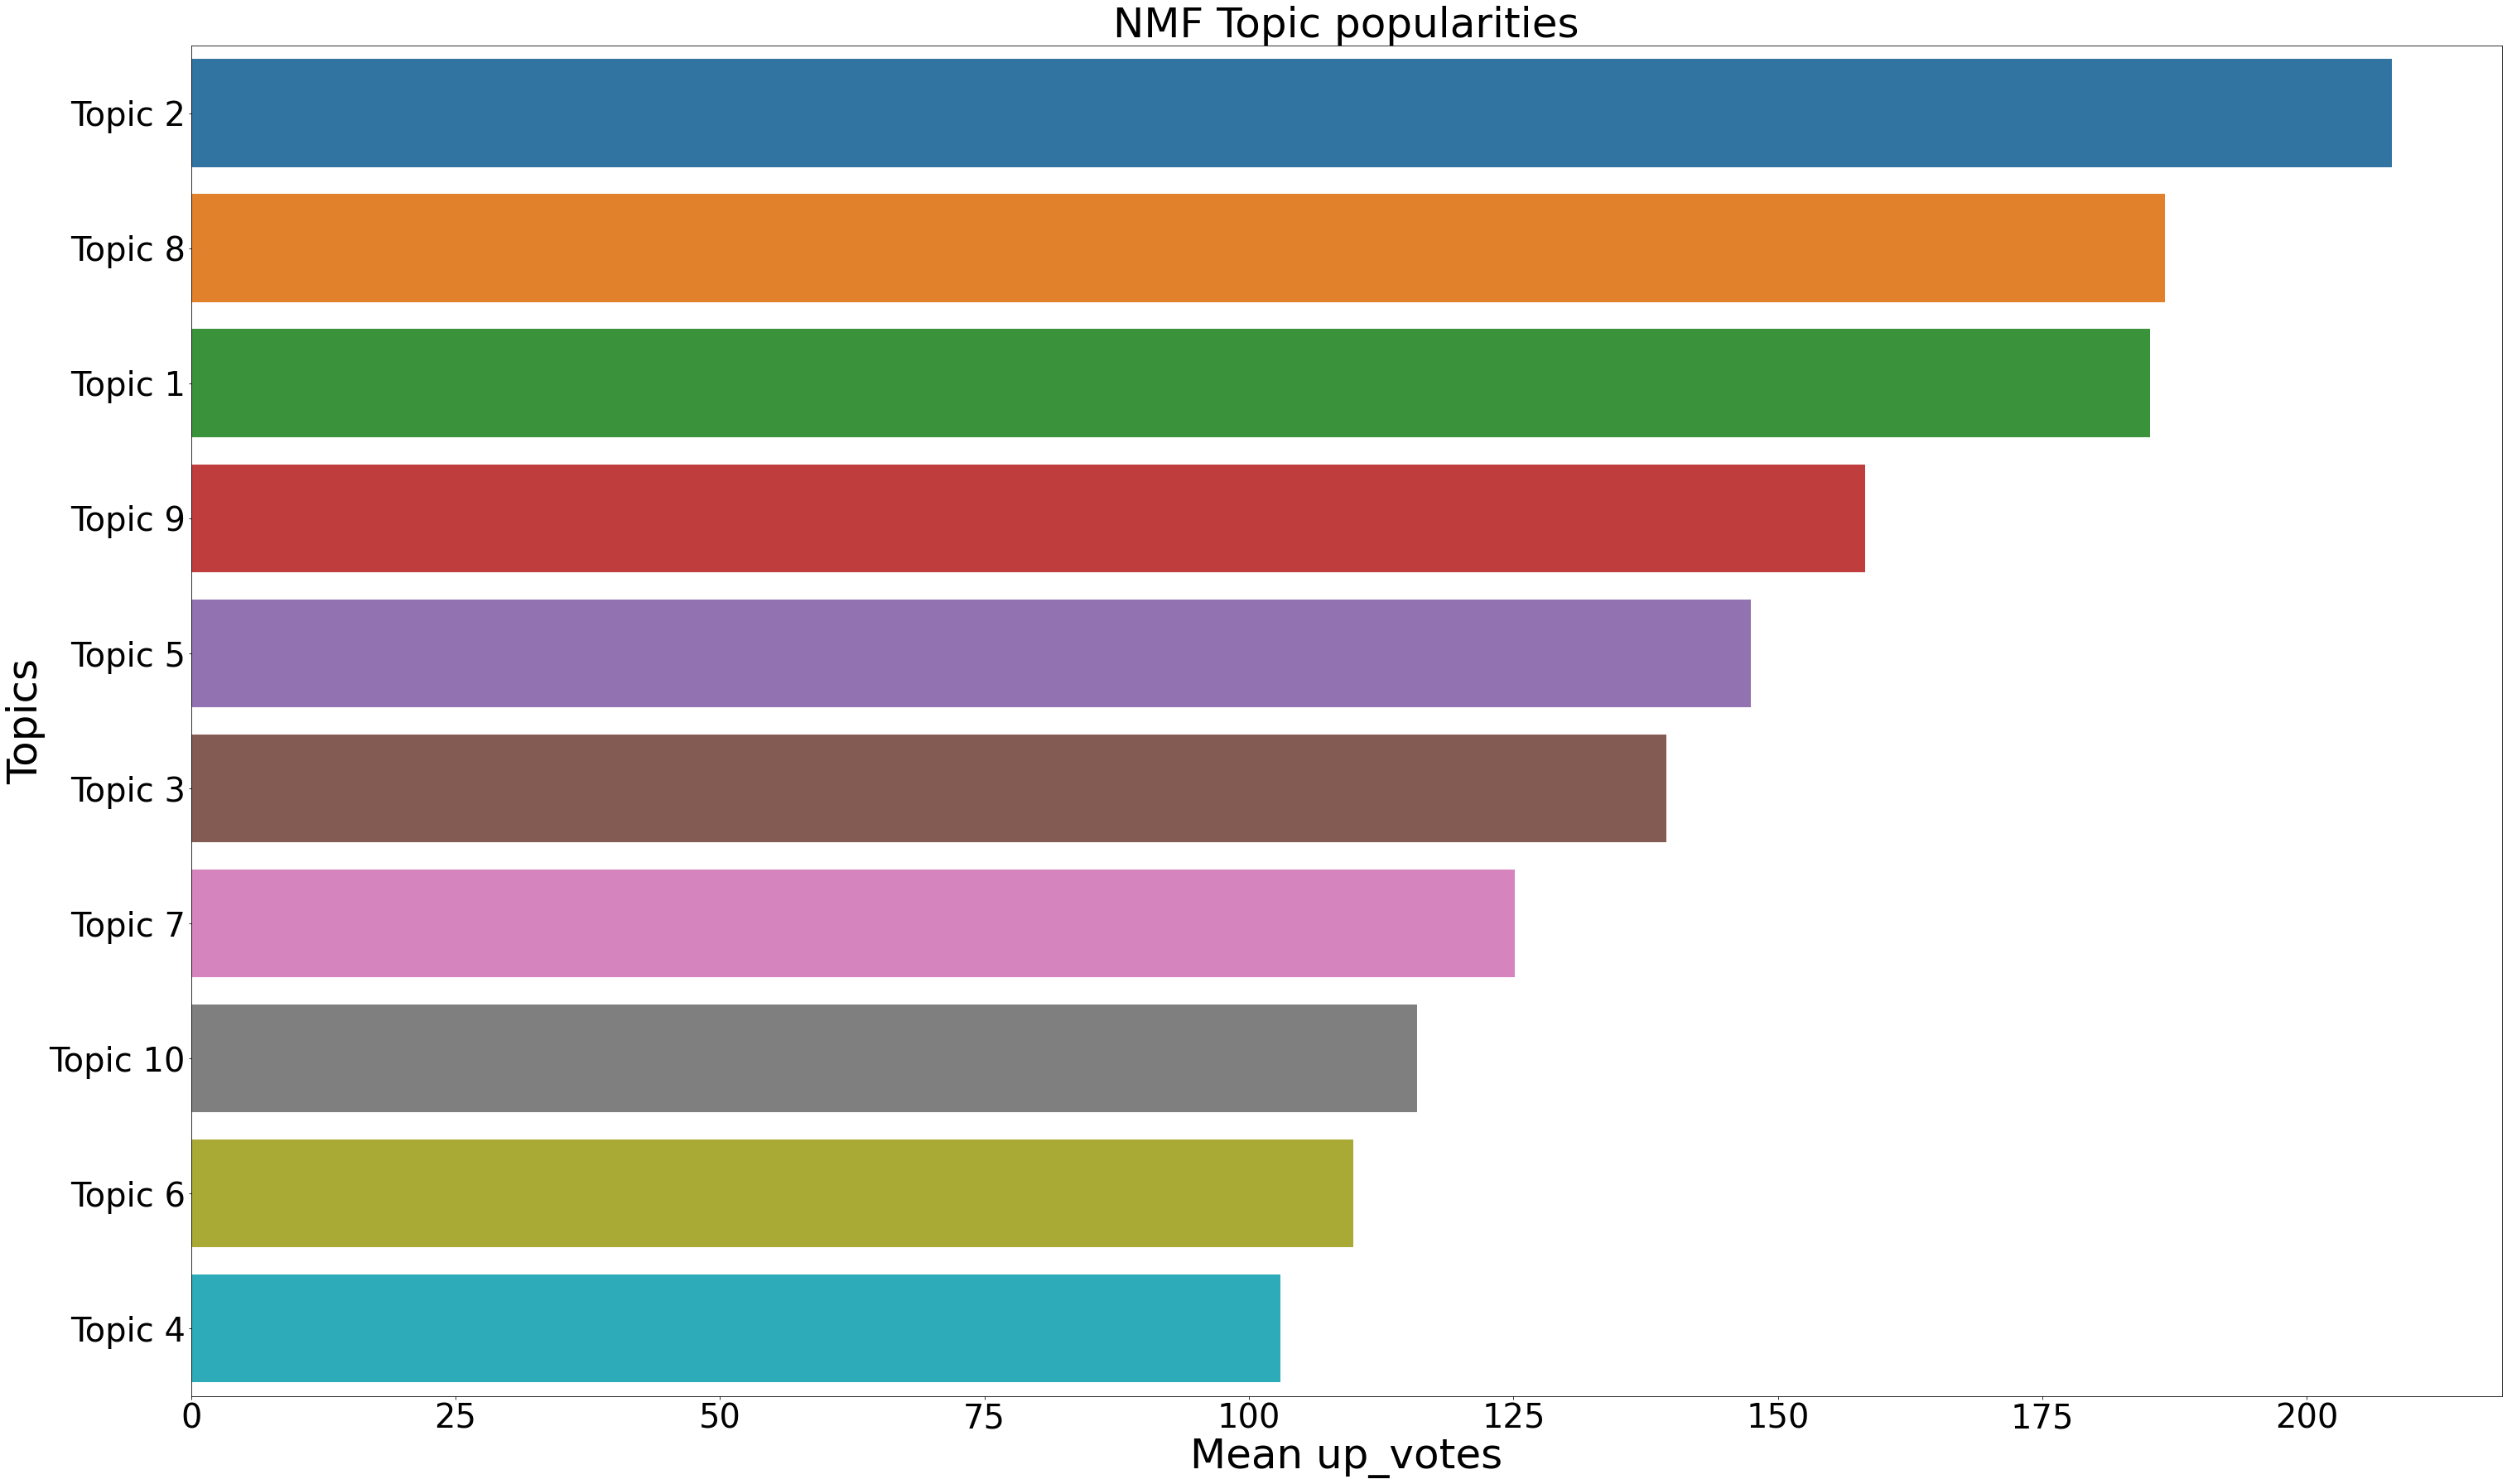

In [60]:
year = 2015

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =20, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year}', year)

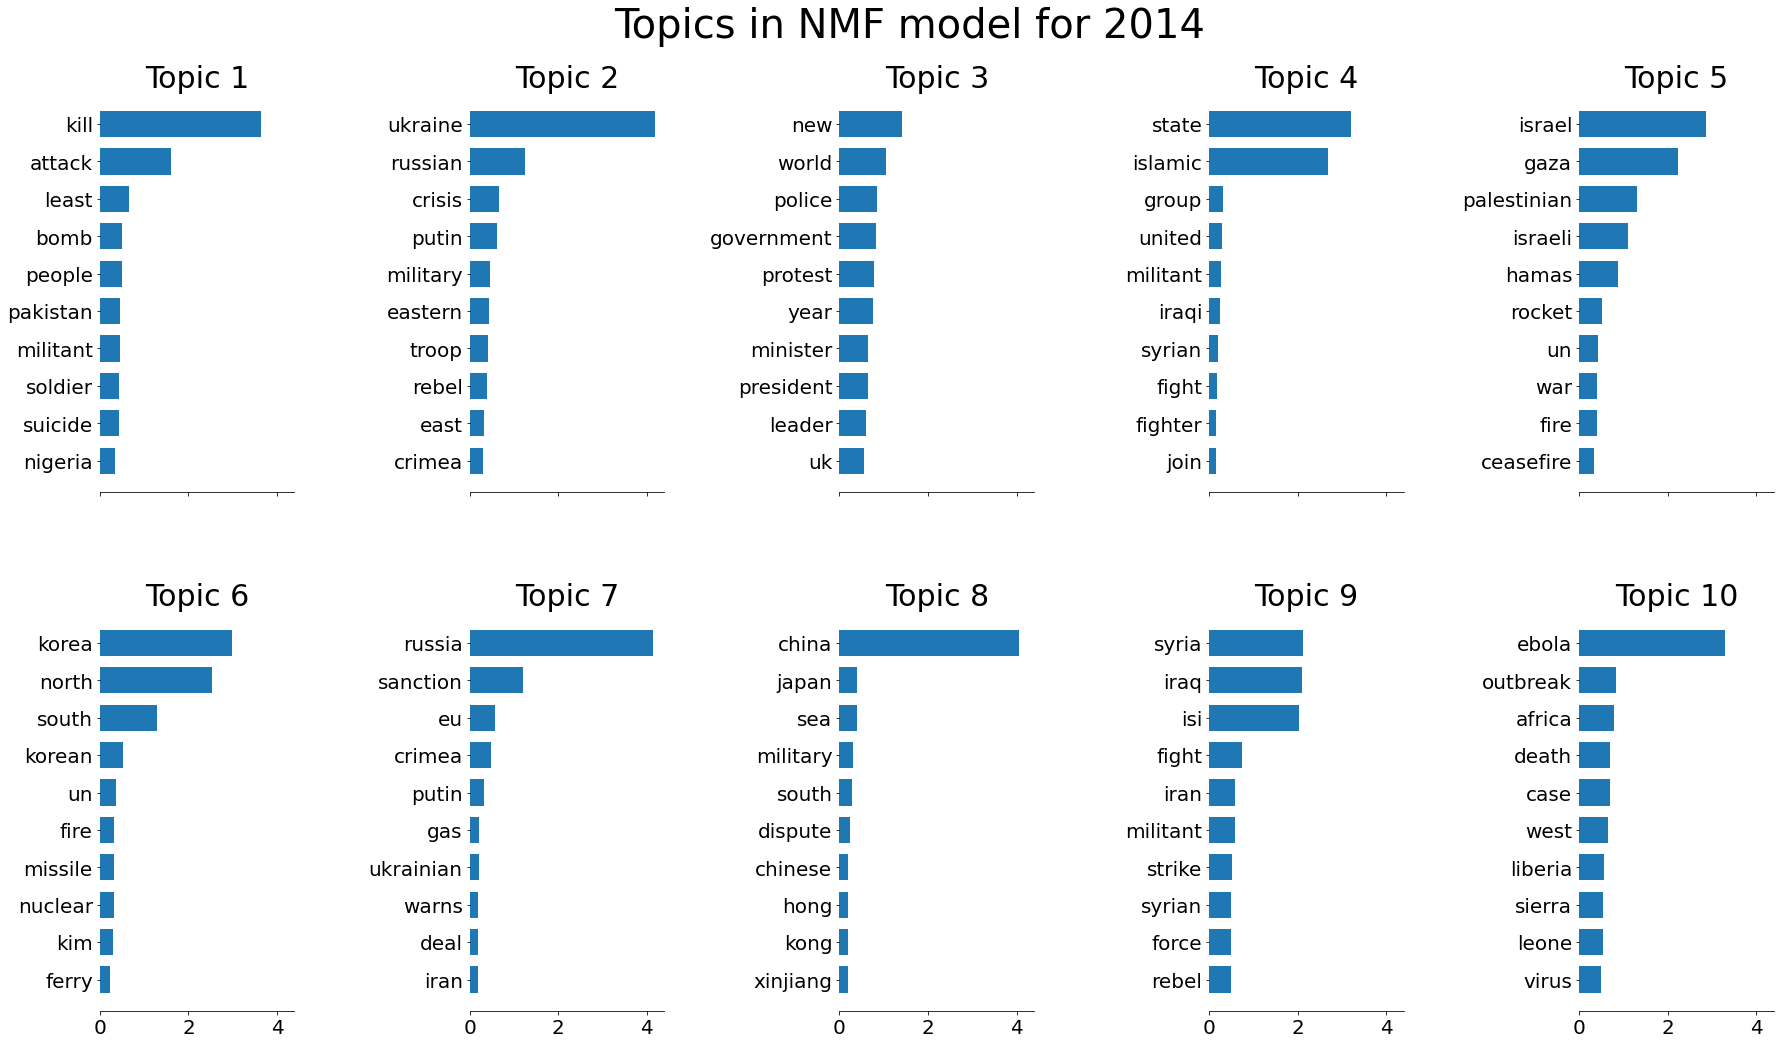

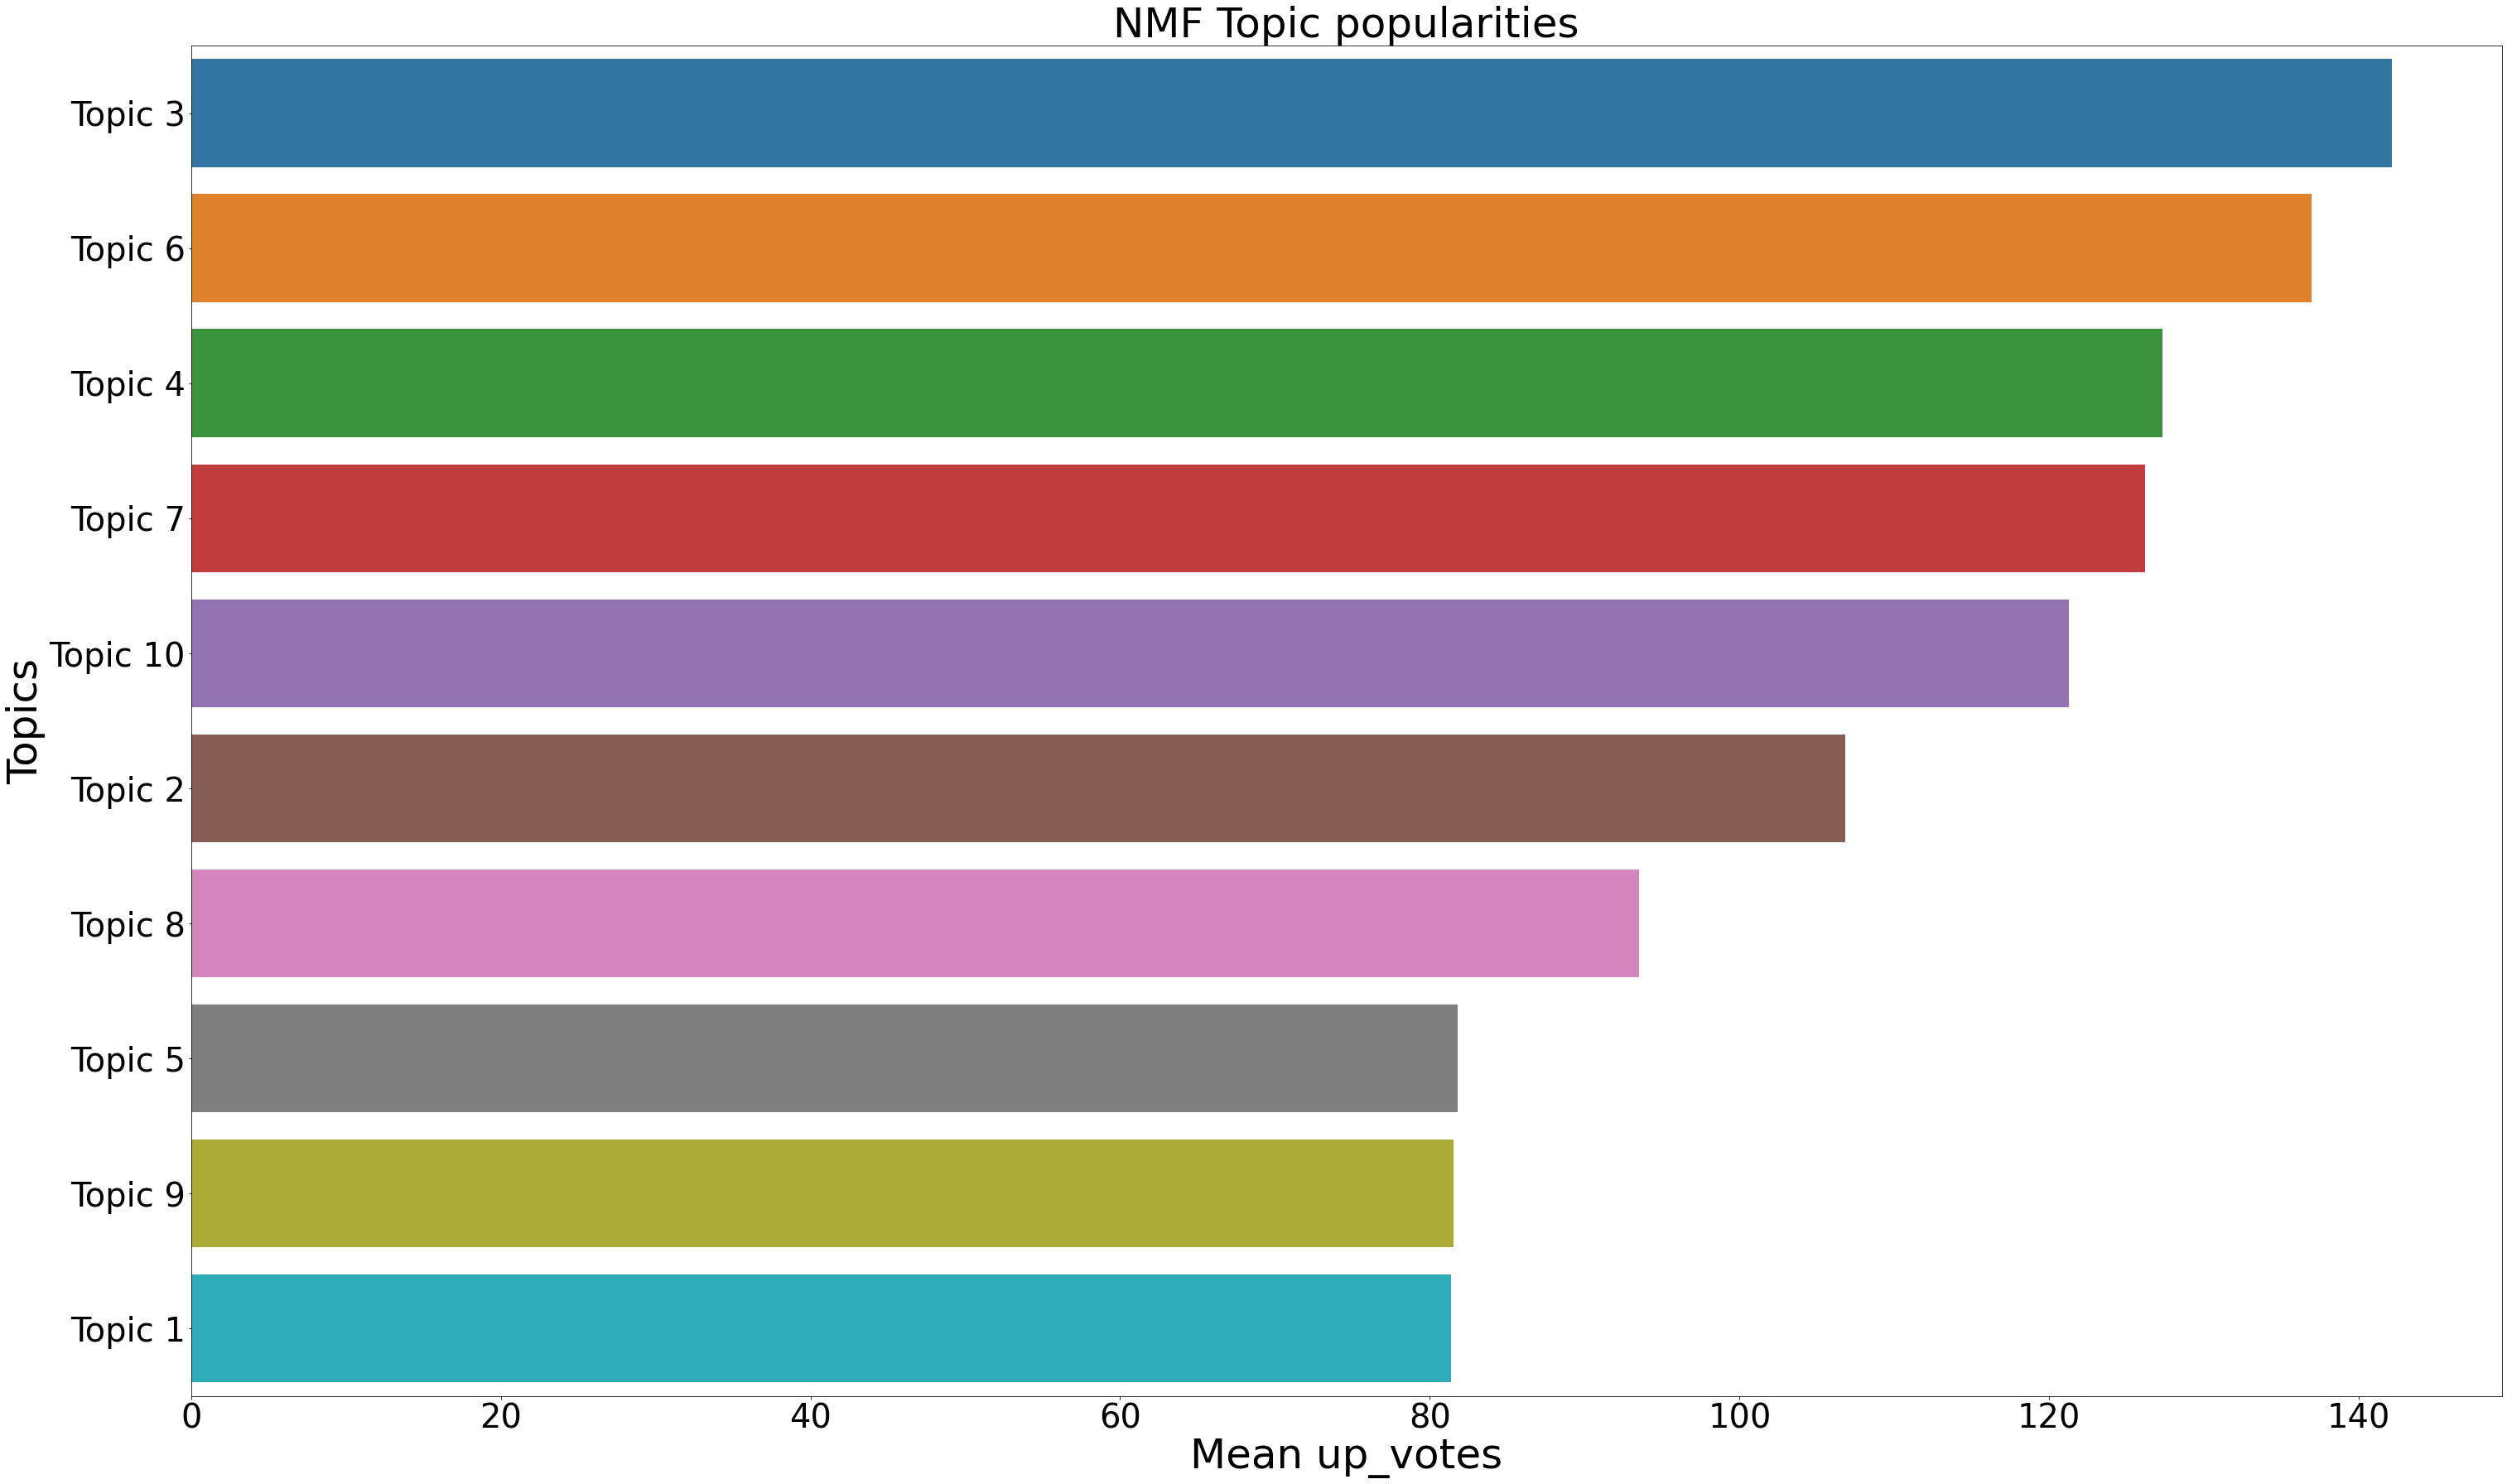

In [61]:
year = 2014

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =20, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year}', year)

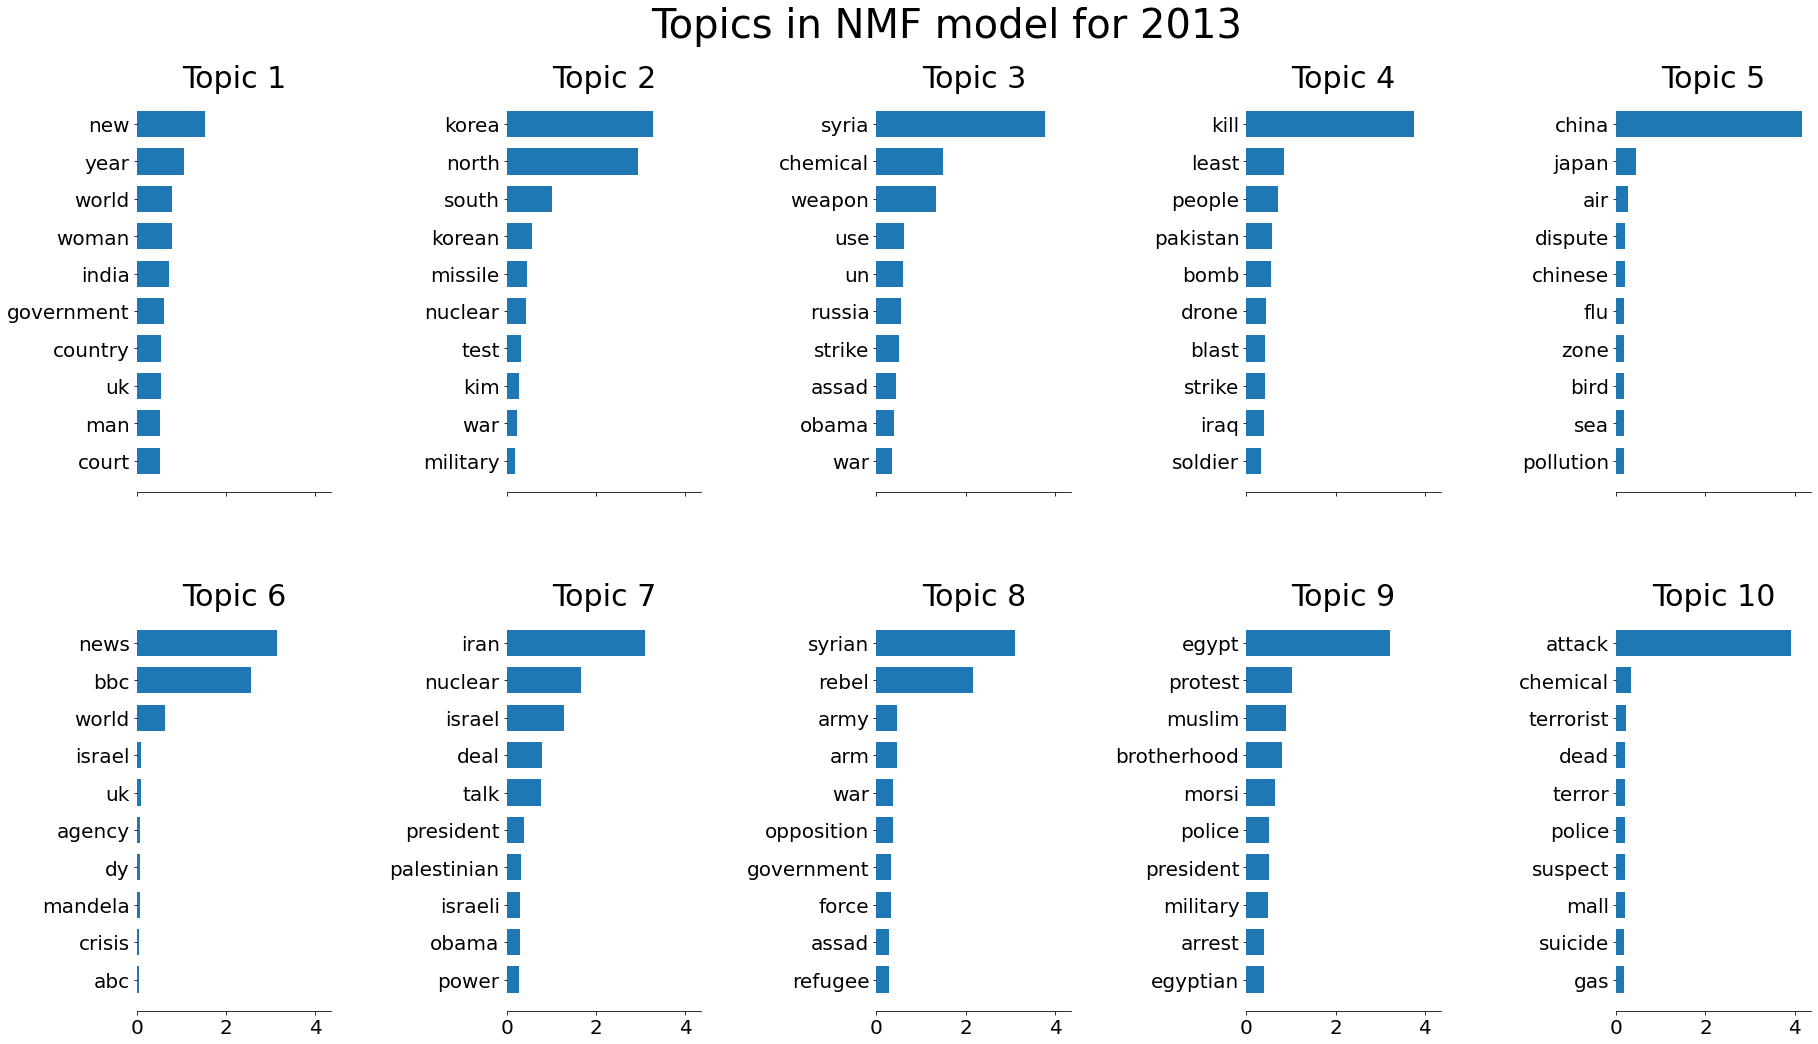

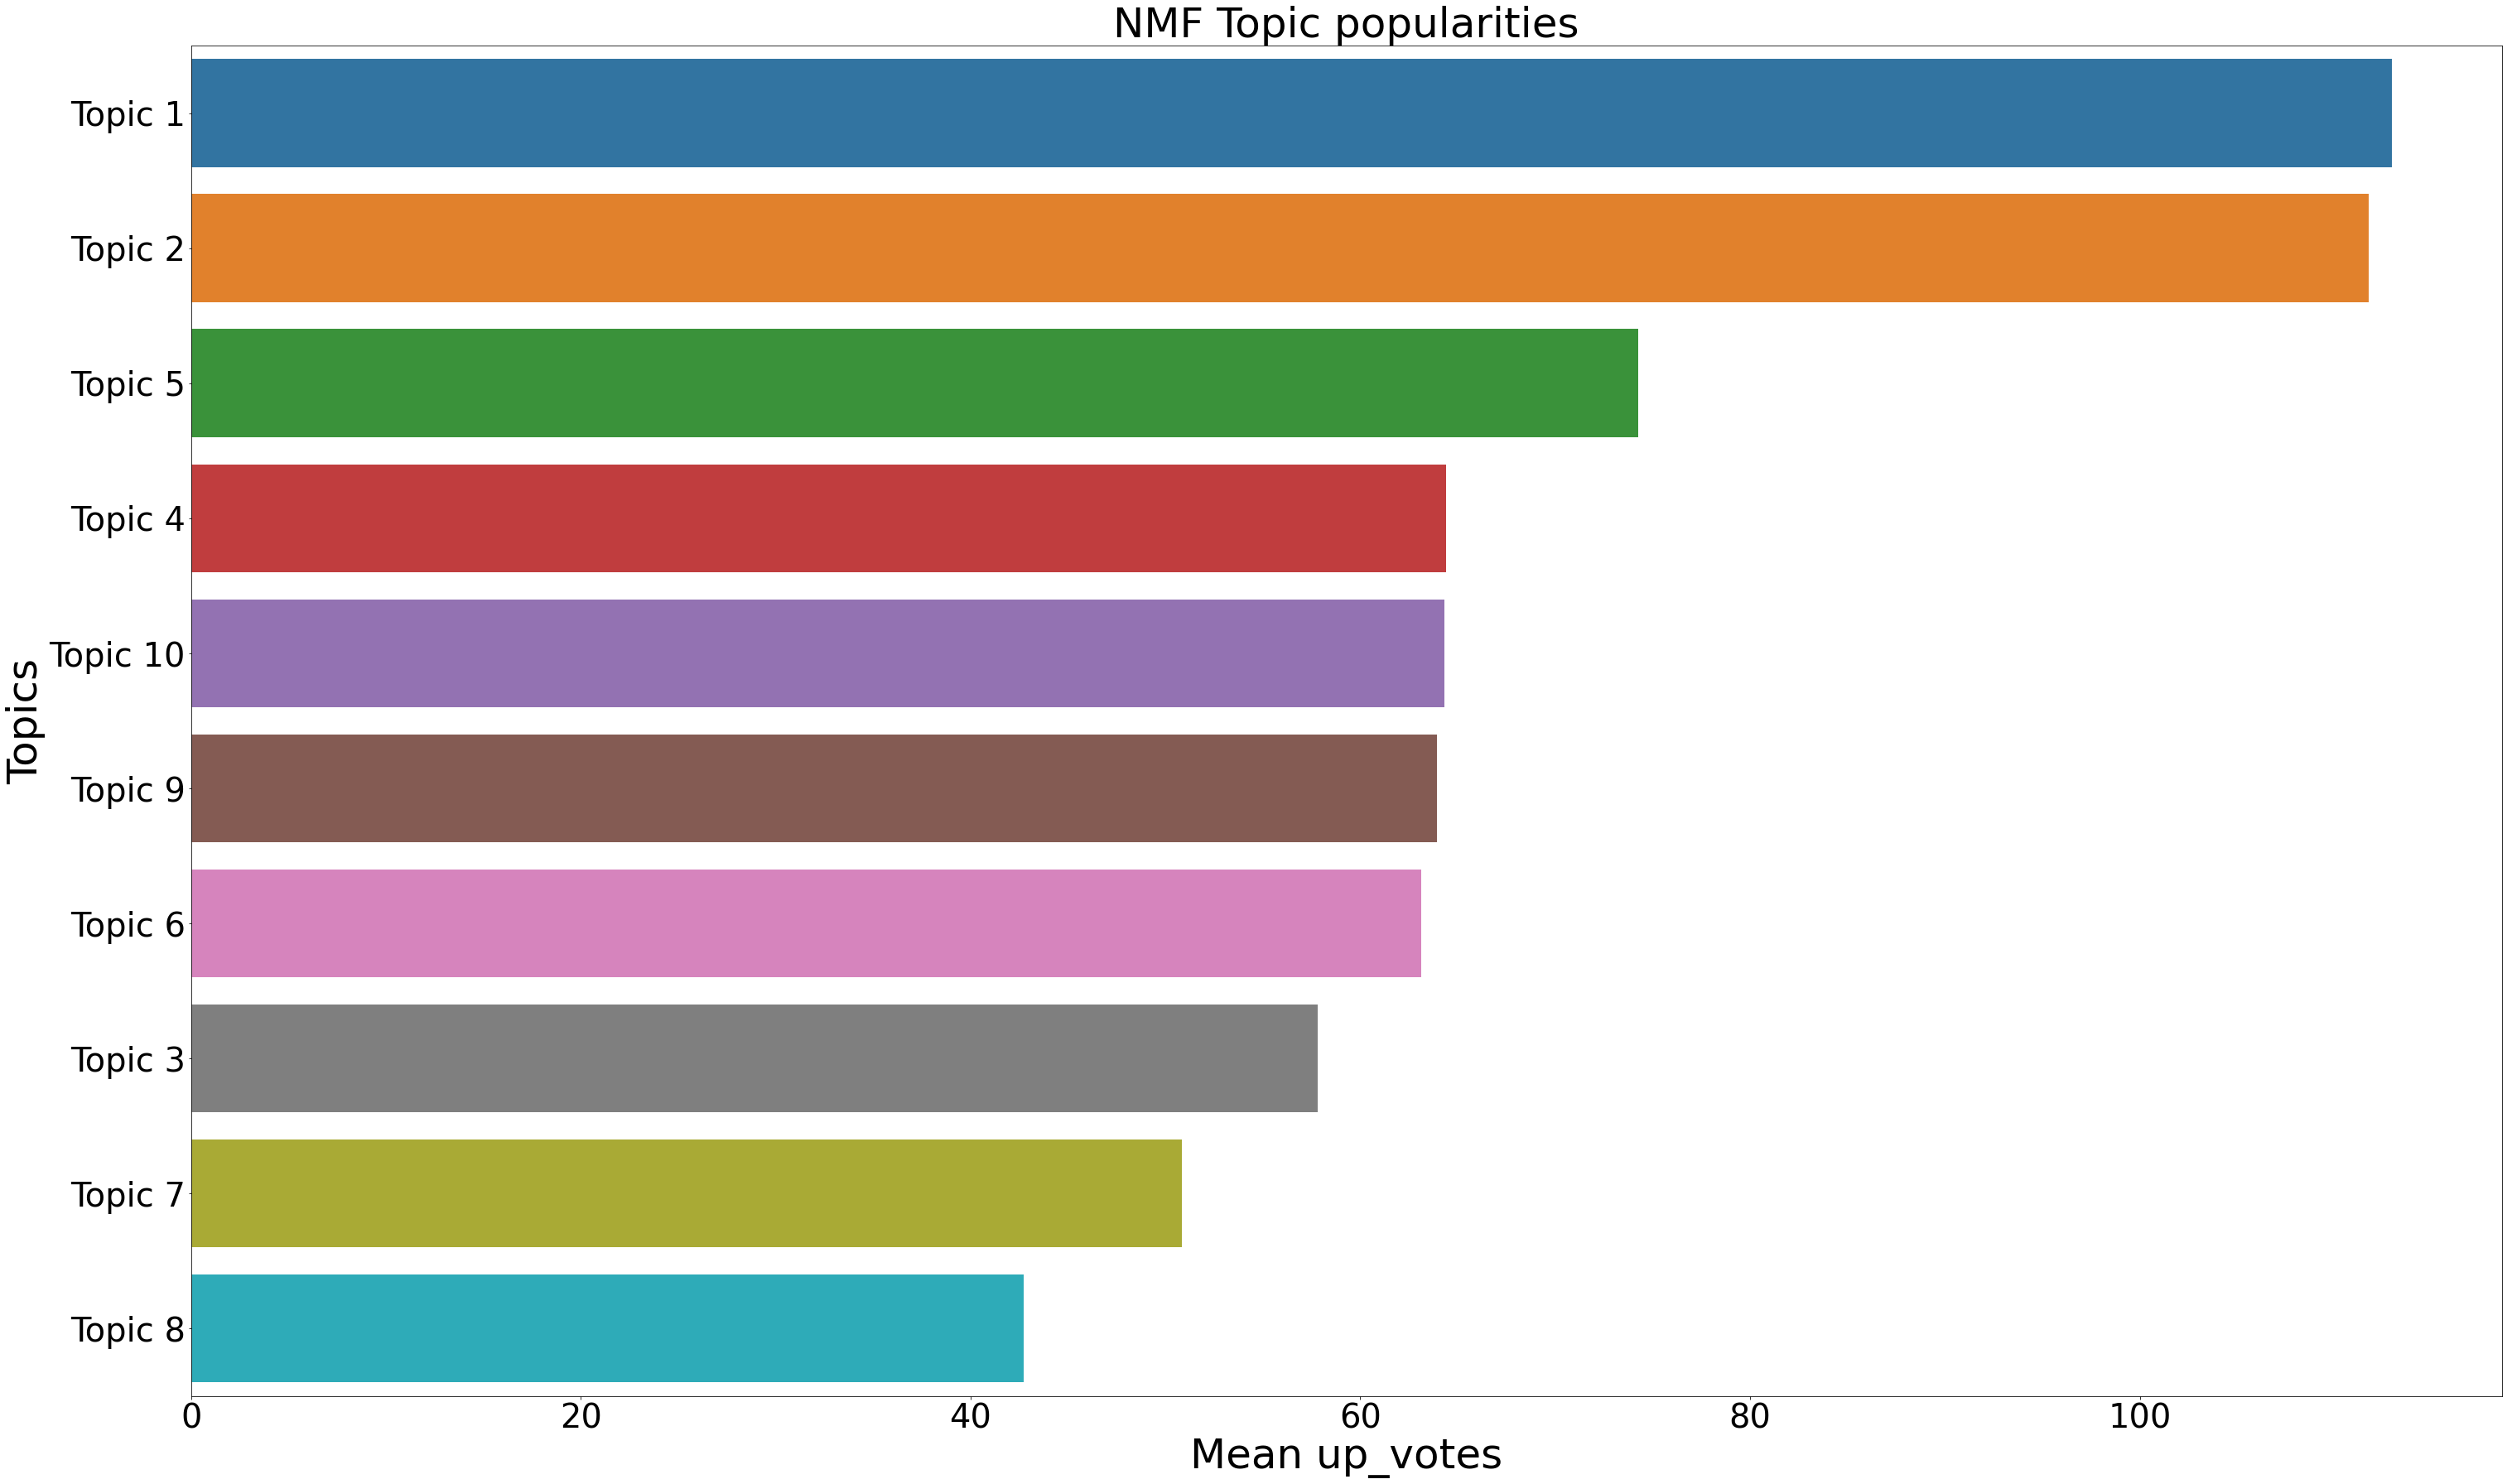

In [62]:
year = 2013

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =20, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year}', year)

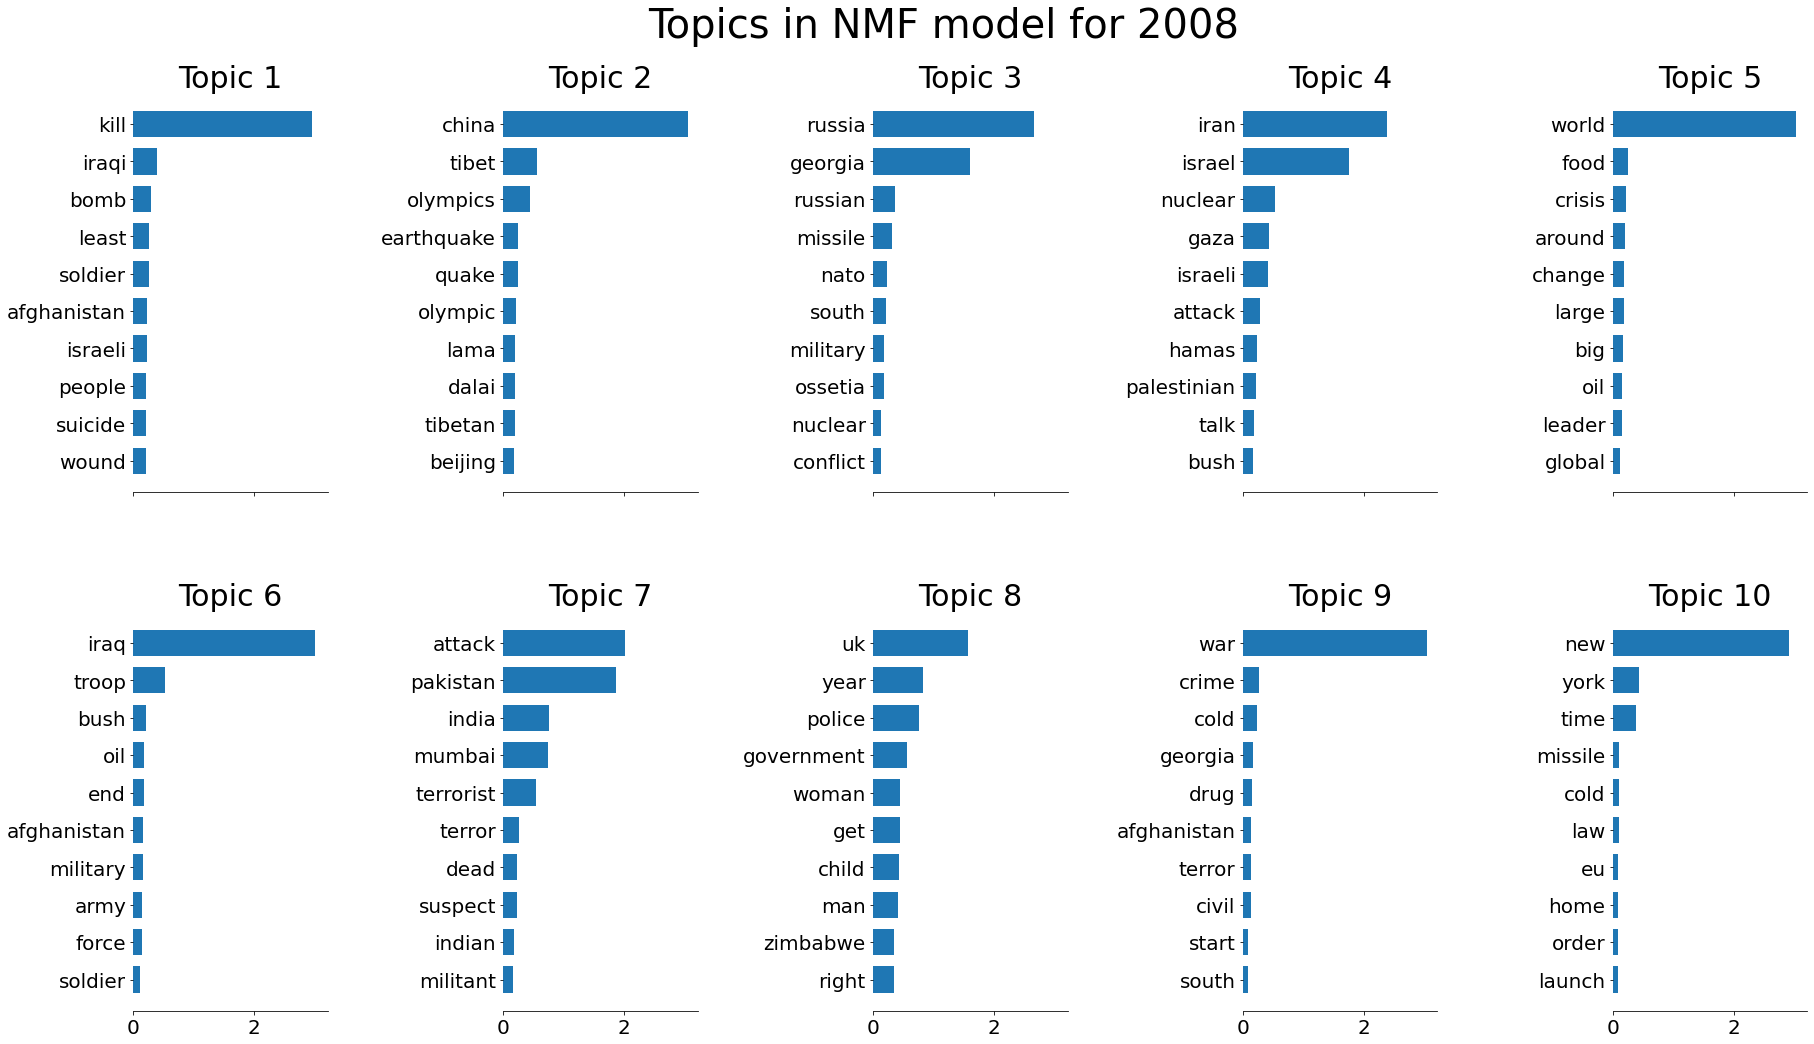

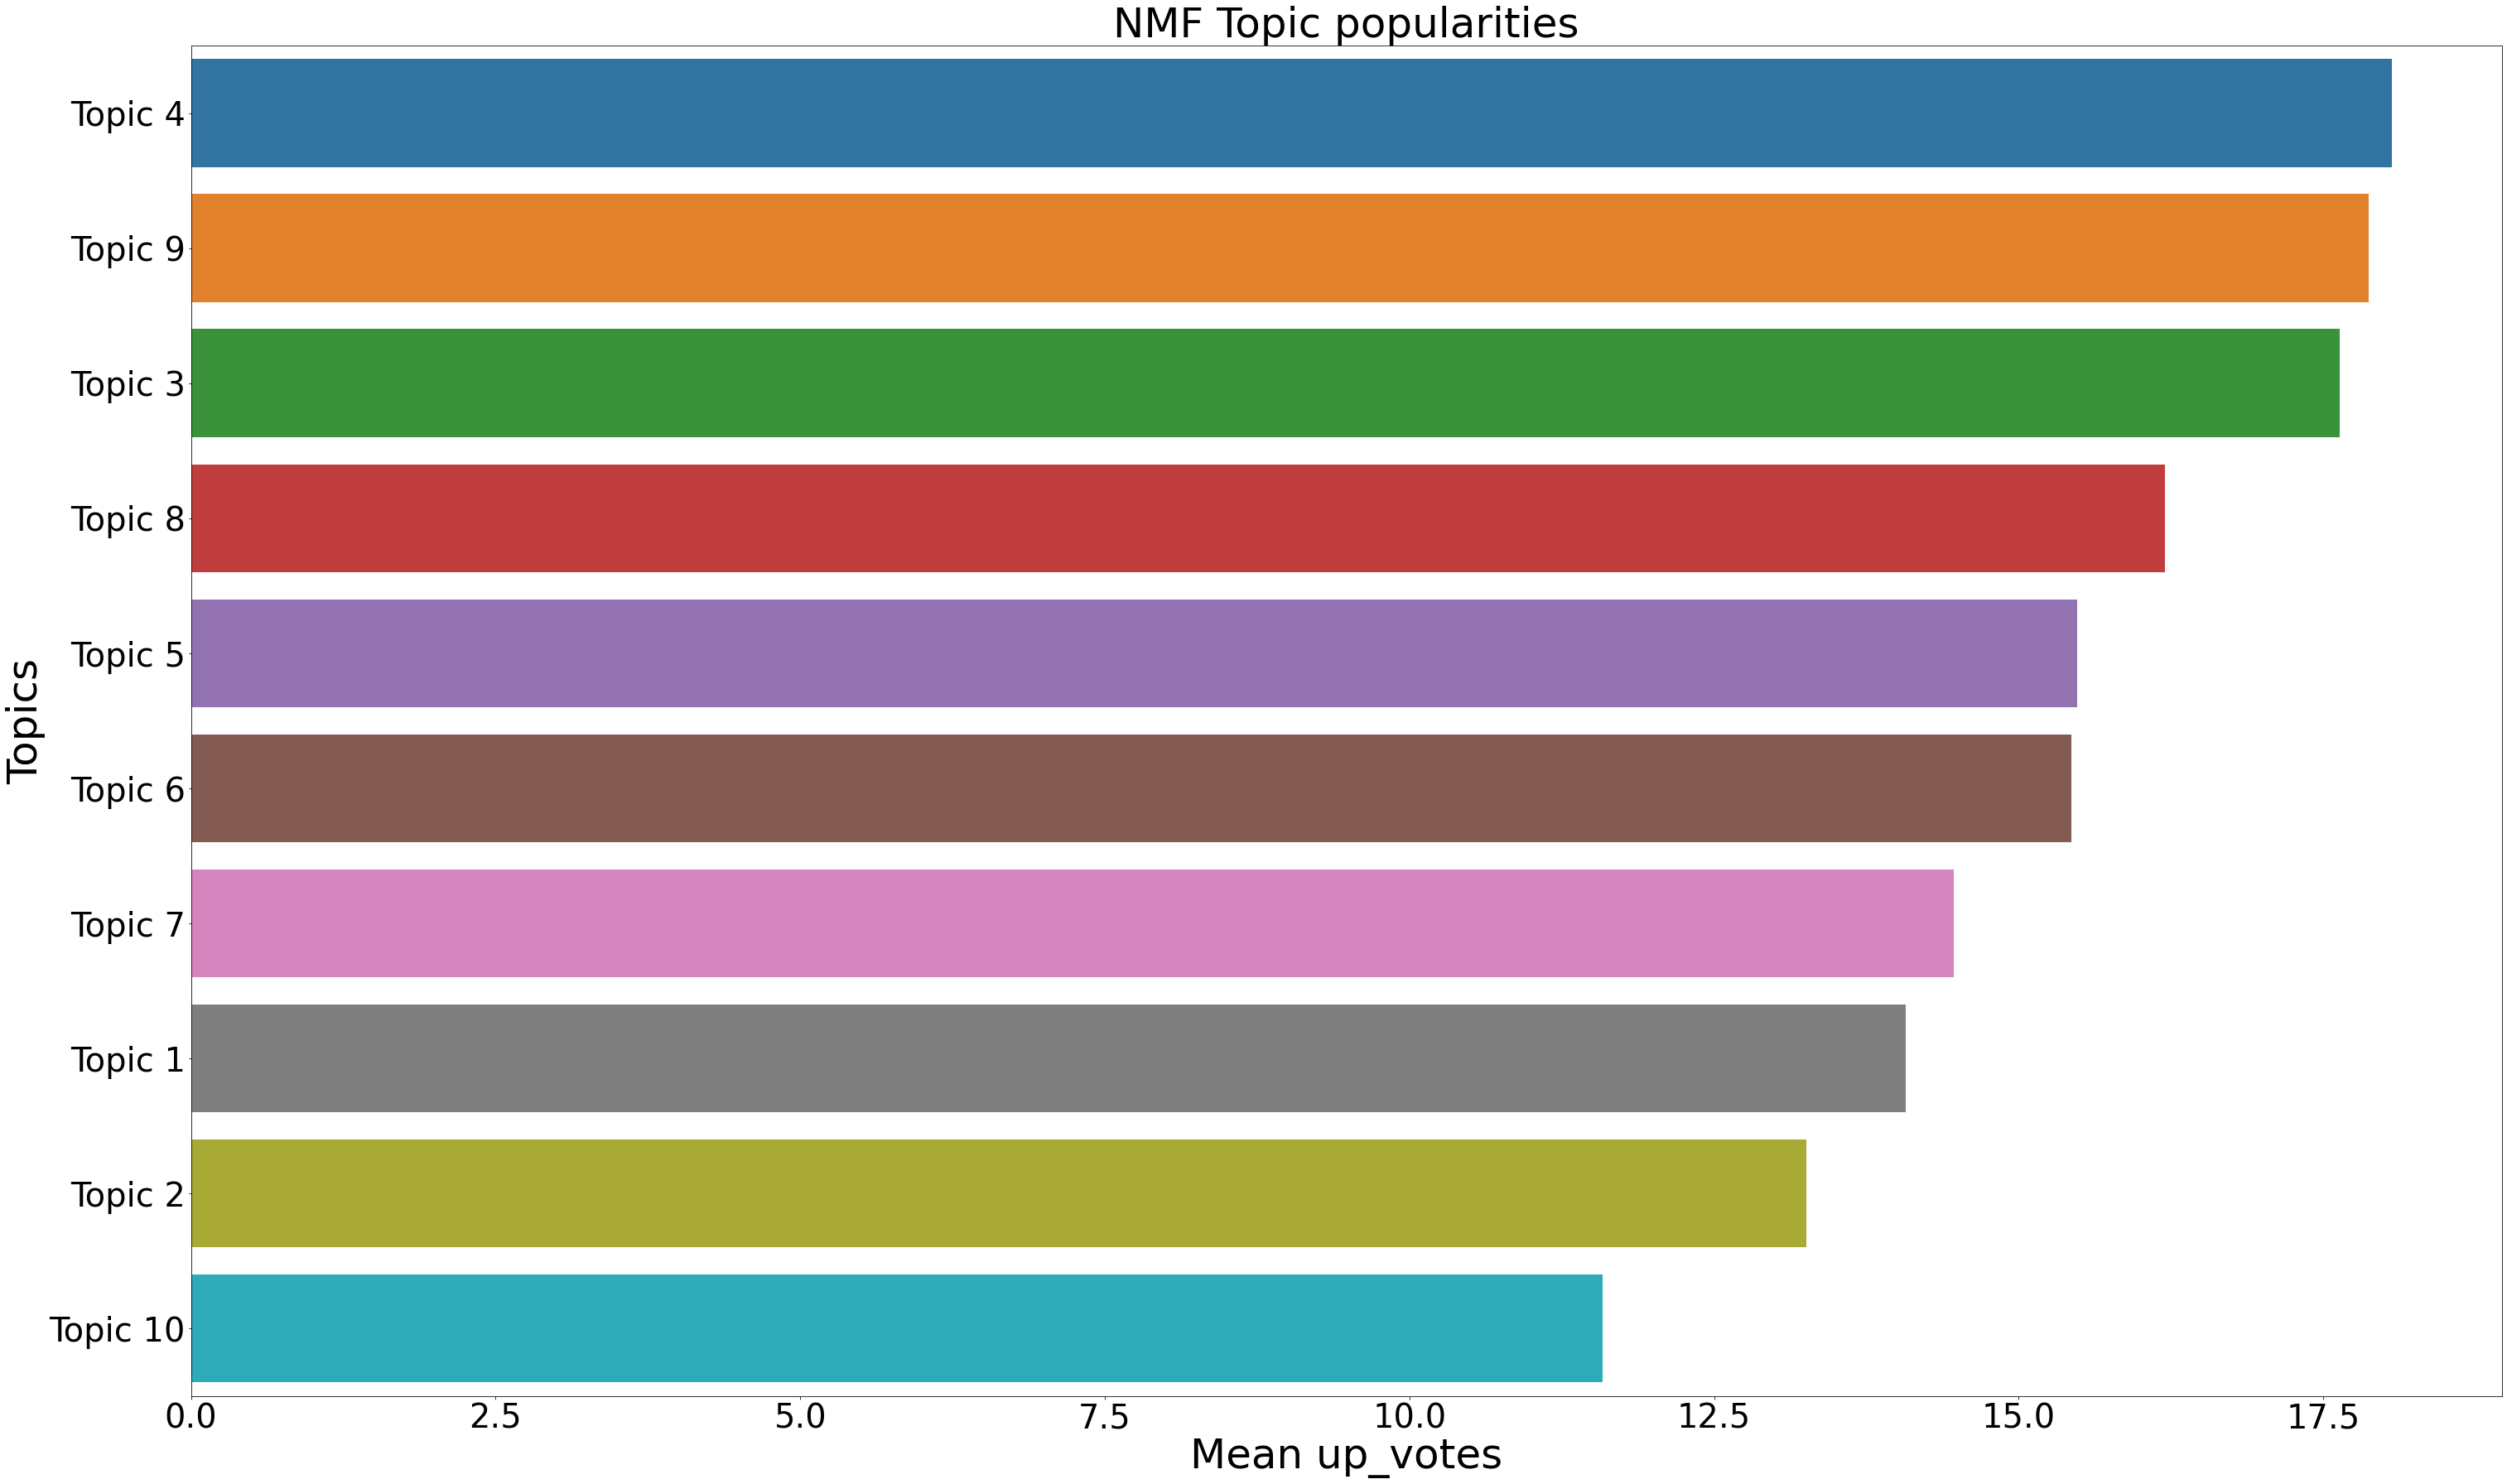

In [63]:
year = 2008

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =20, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year}', year)

## Can inclusion of bi-grams tell us something different?

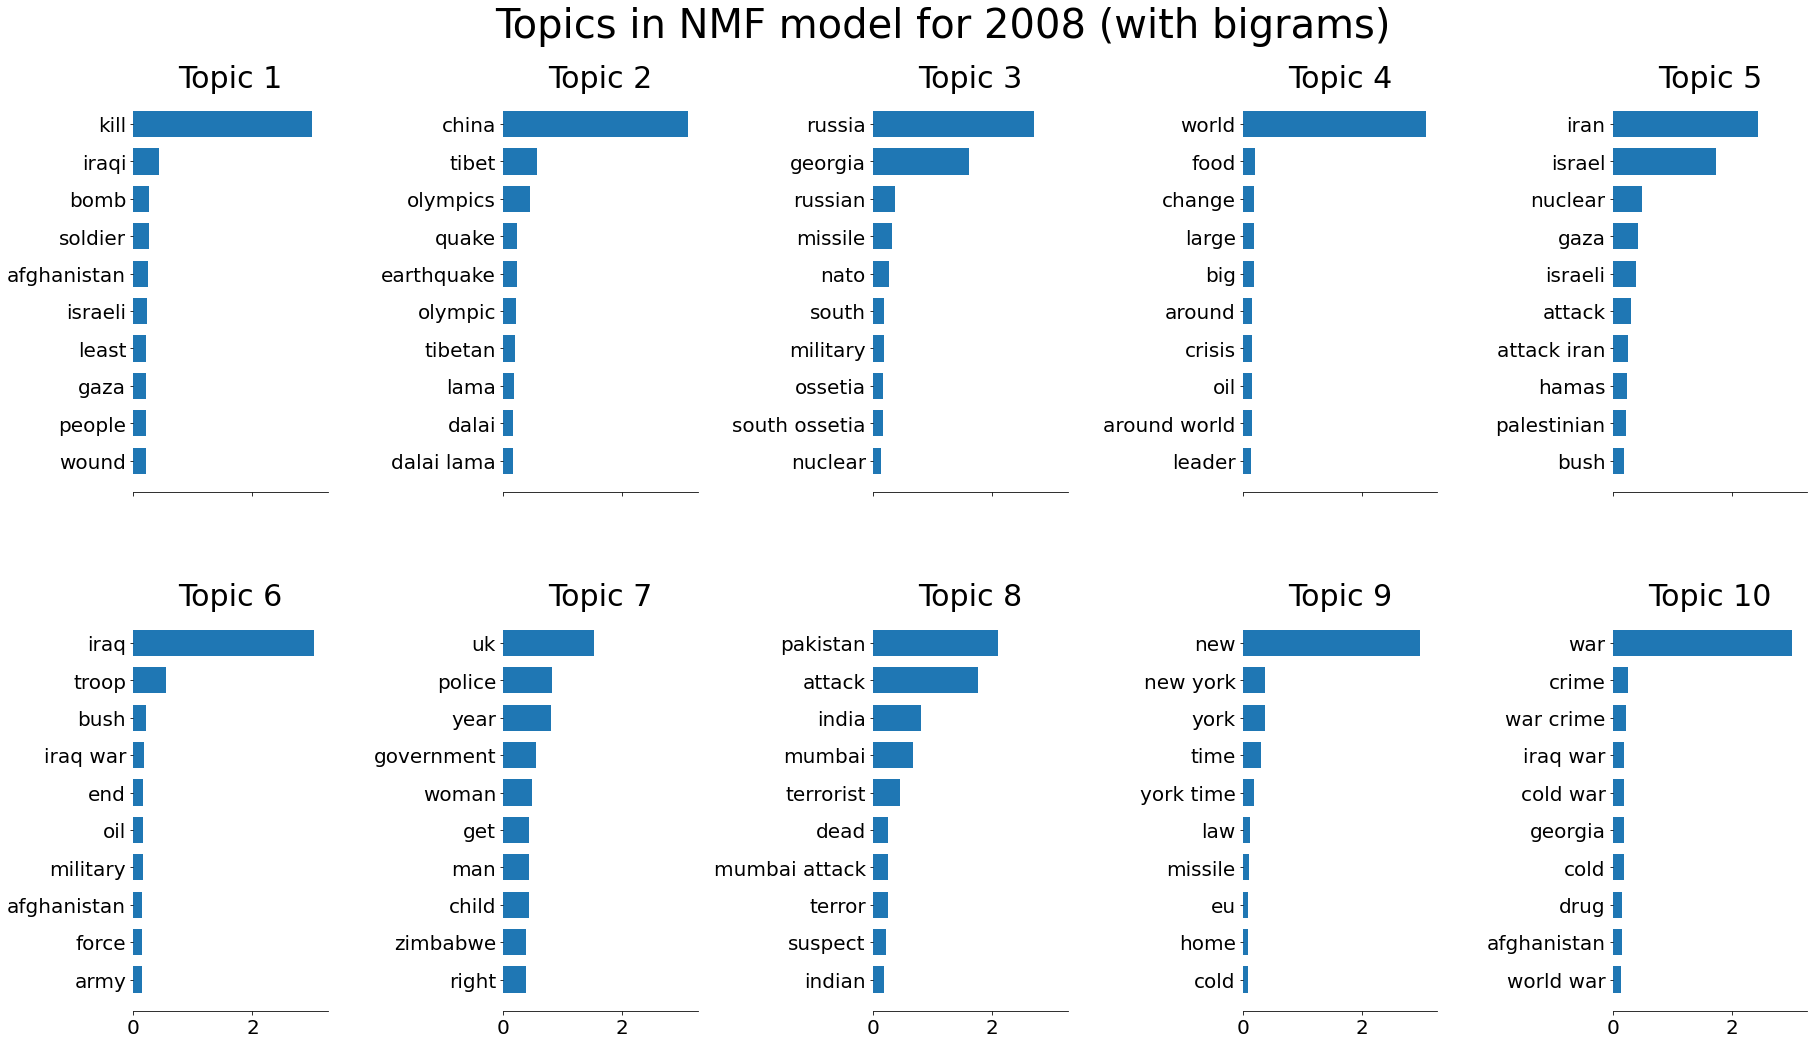

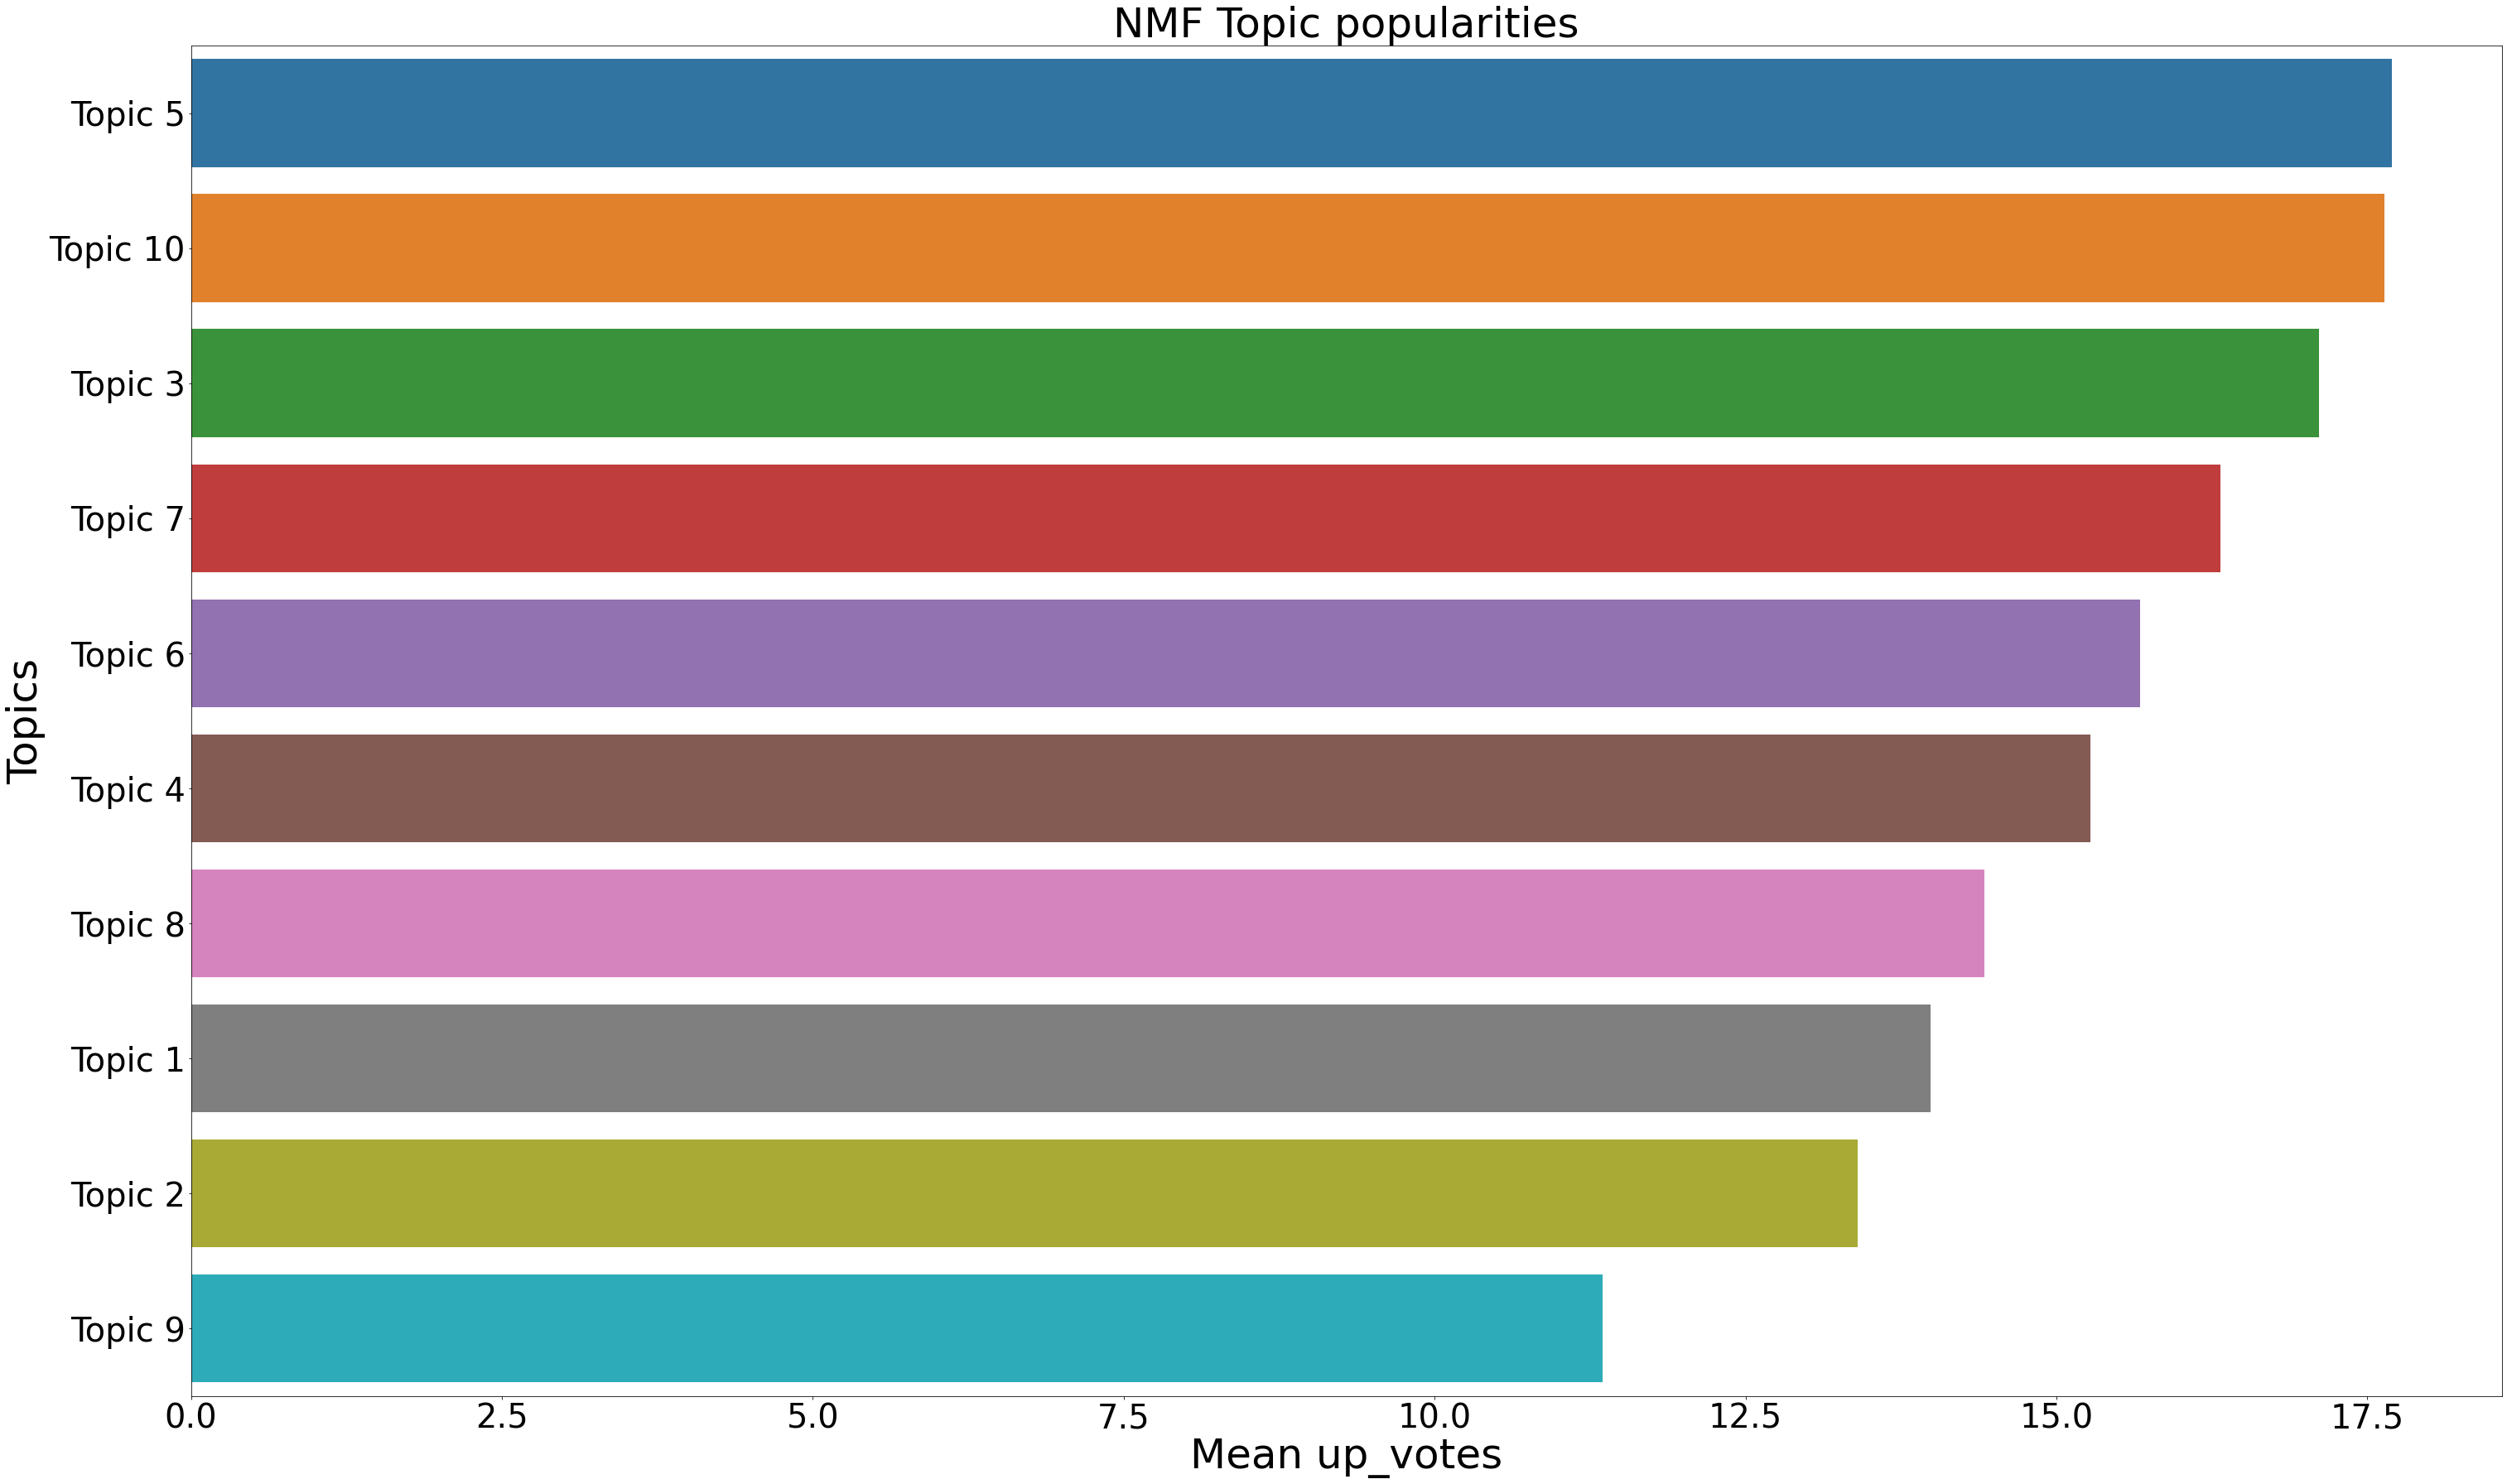

In [64]:
# Let's take a look at 2008
year = 2008

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with bigrams)', year)

**There are some changes in the popularity even though the topics are largely the same.**

/Users/jyotisman/miniforge3/envs/nlp_env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


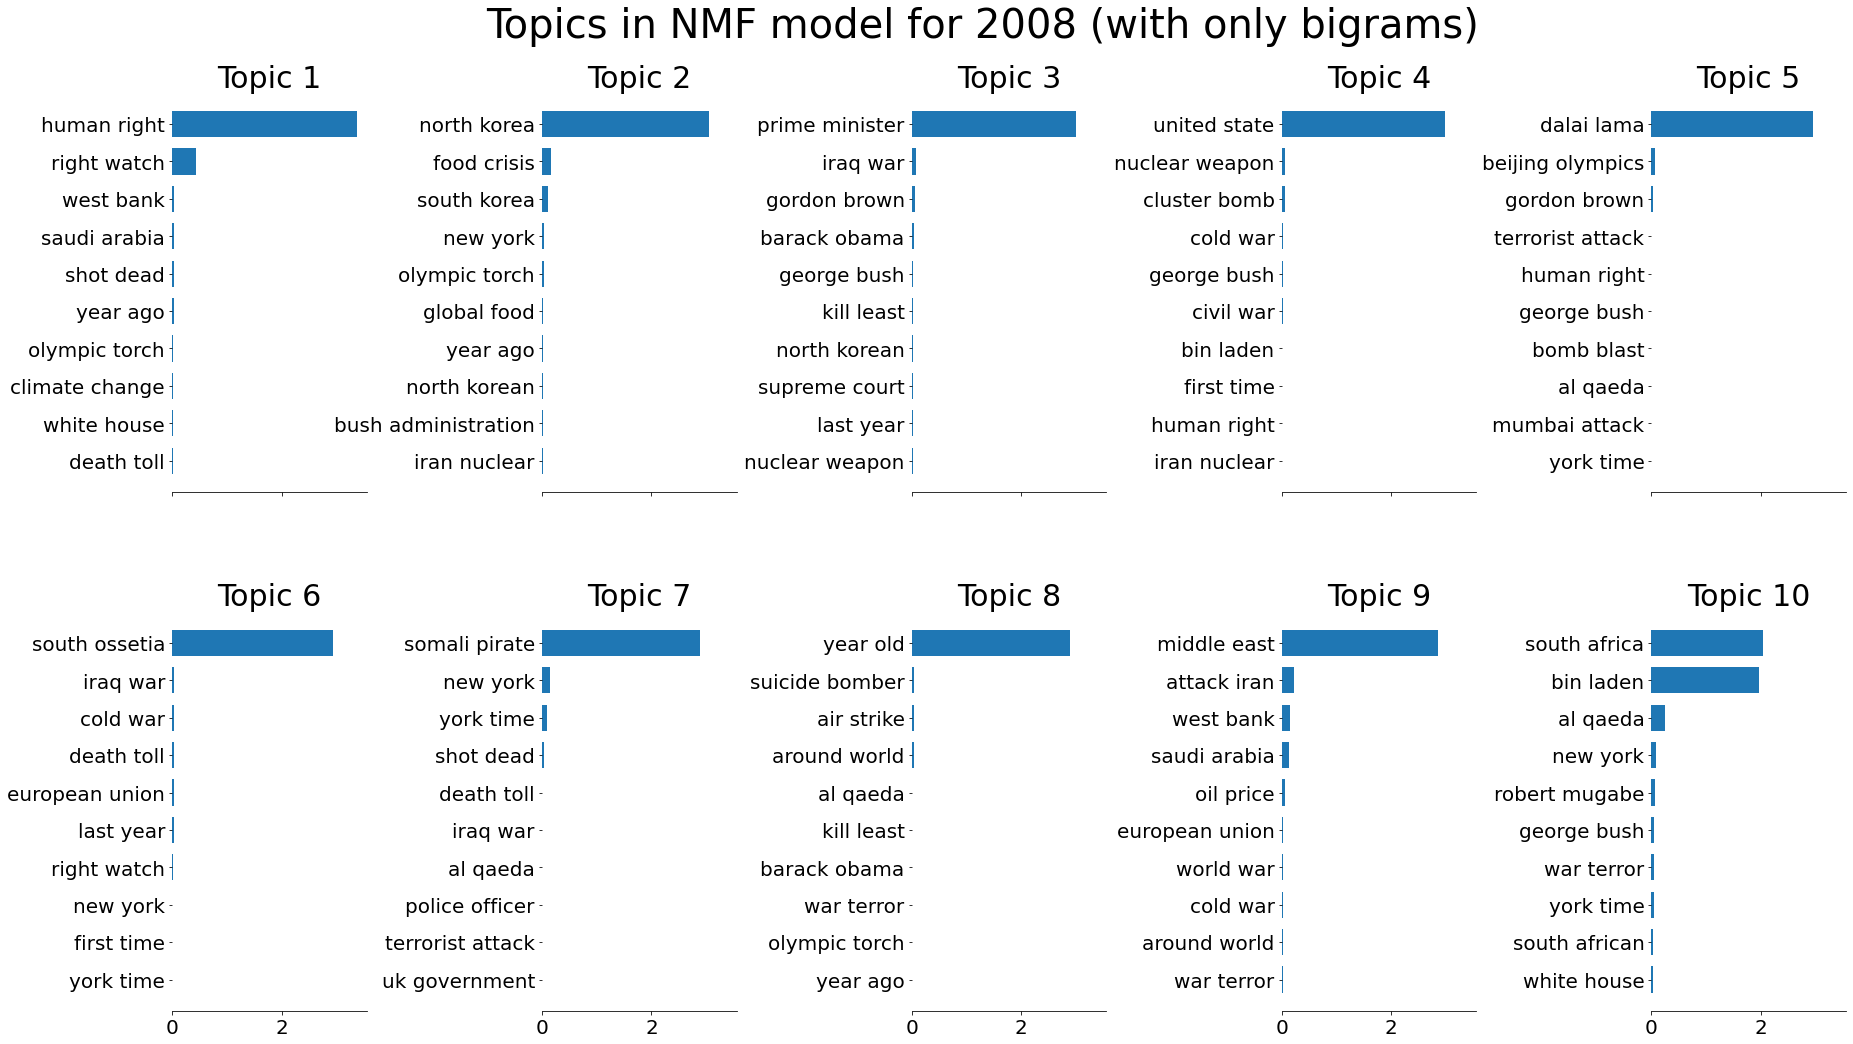

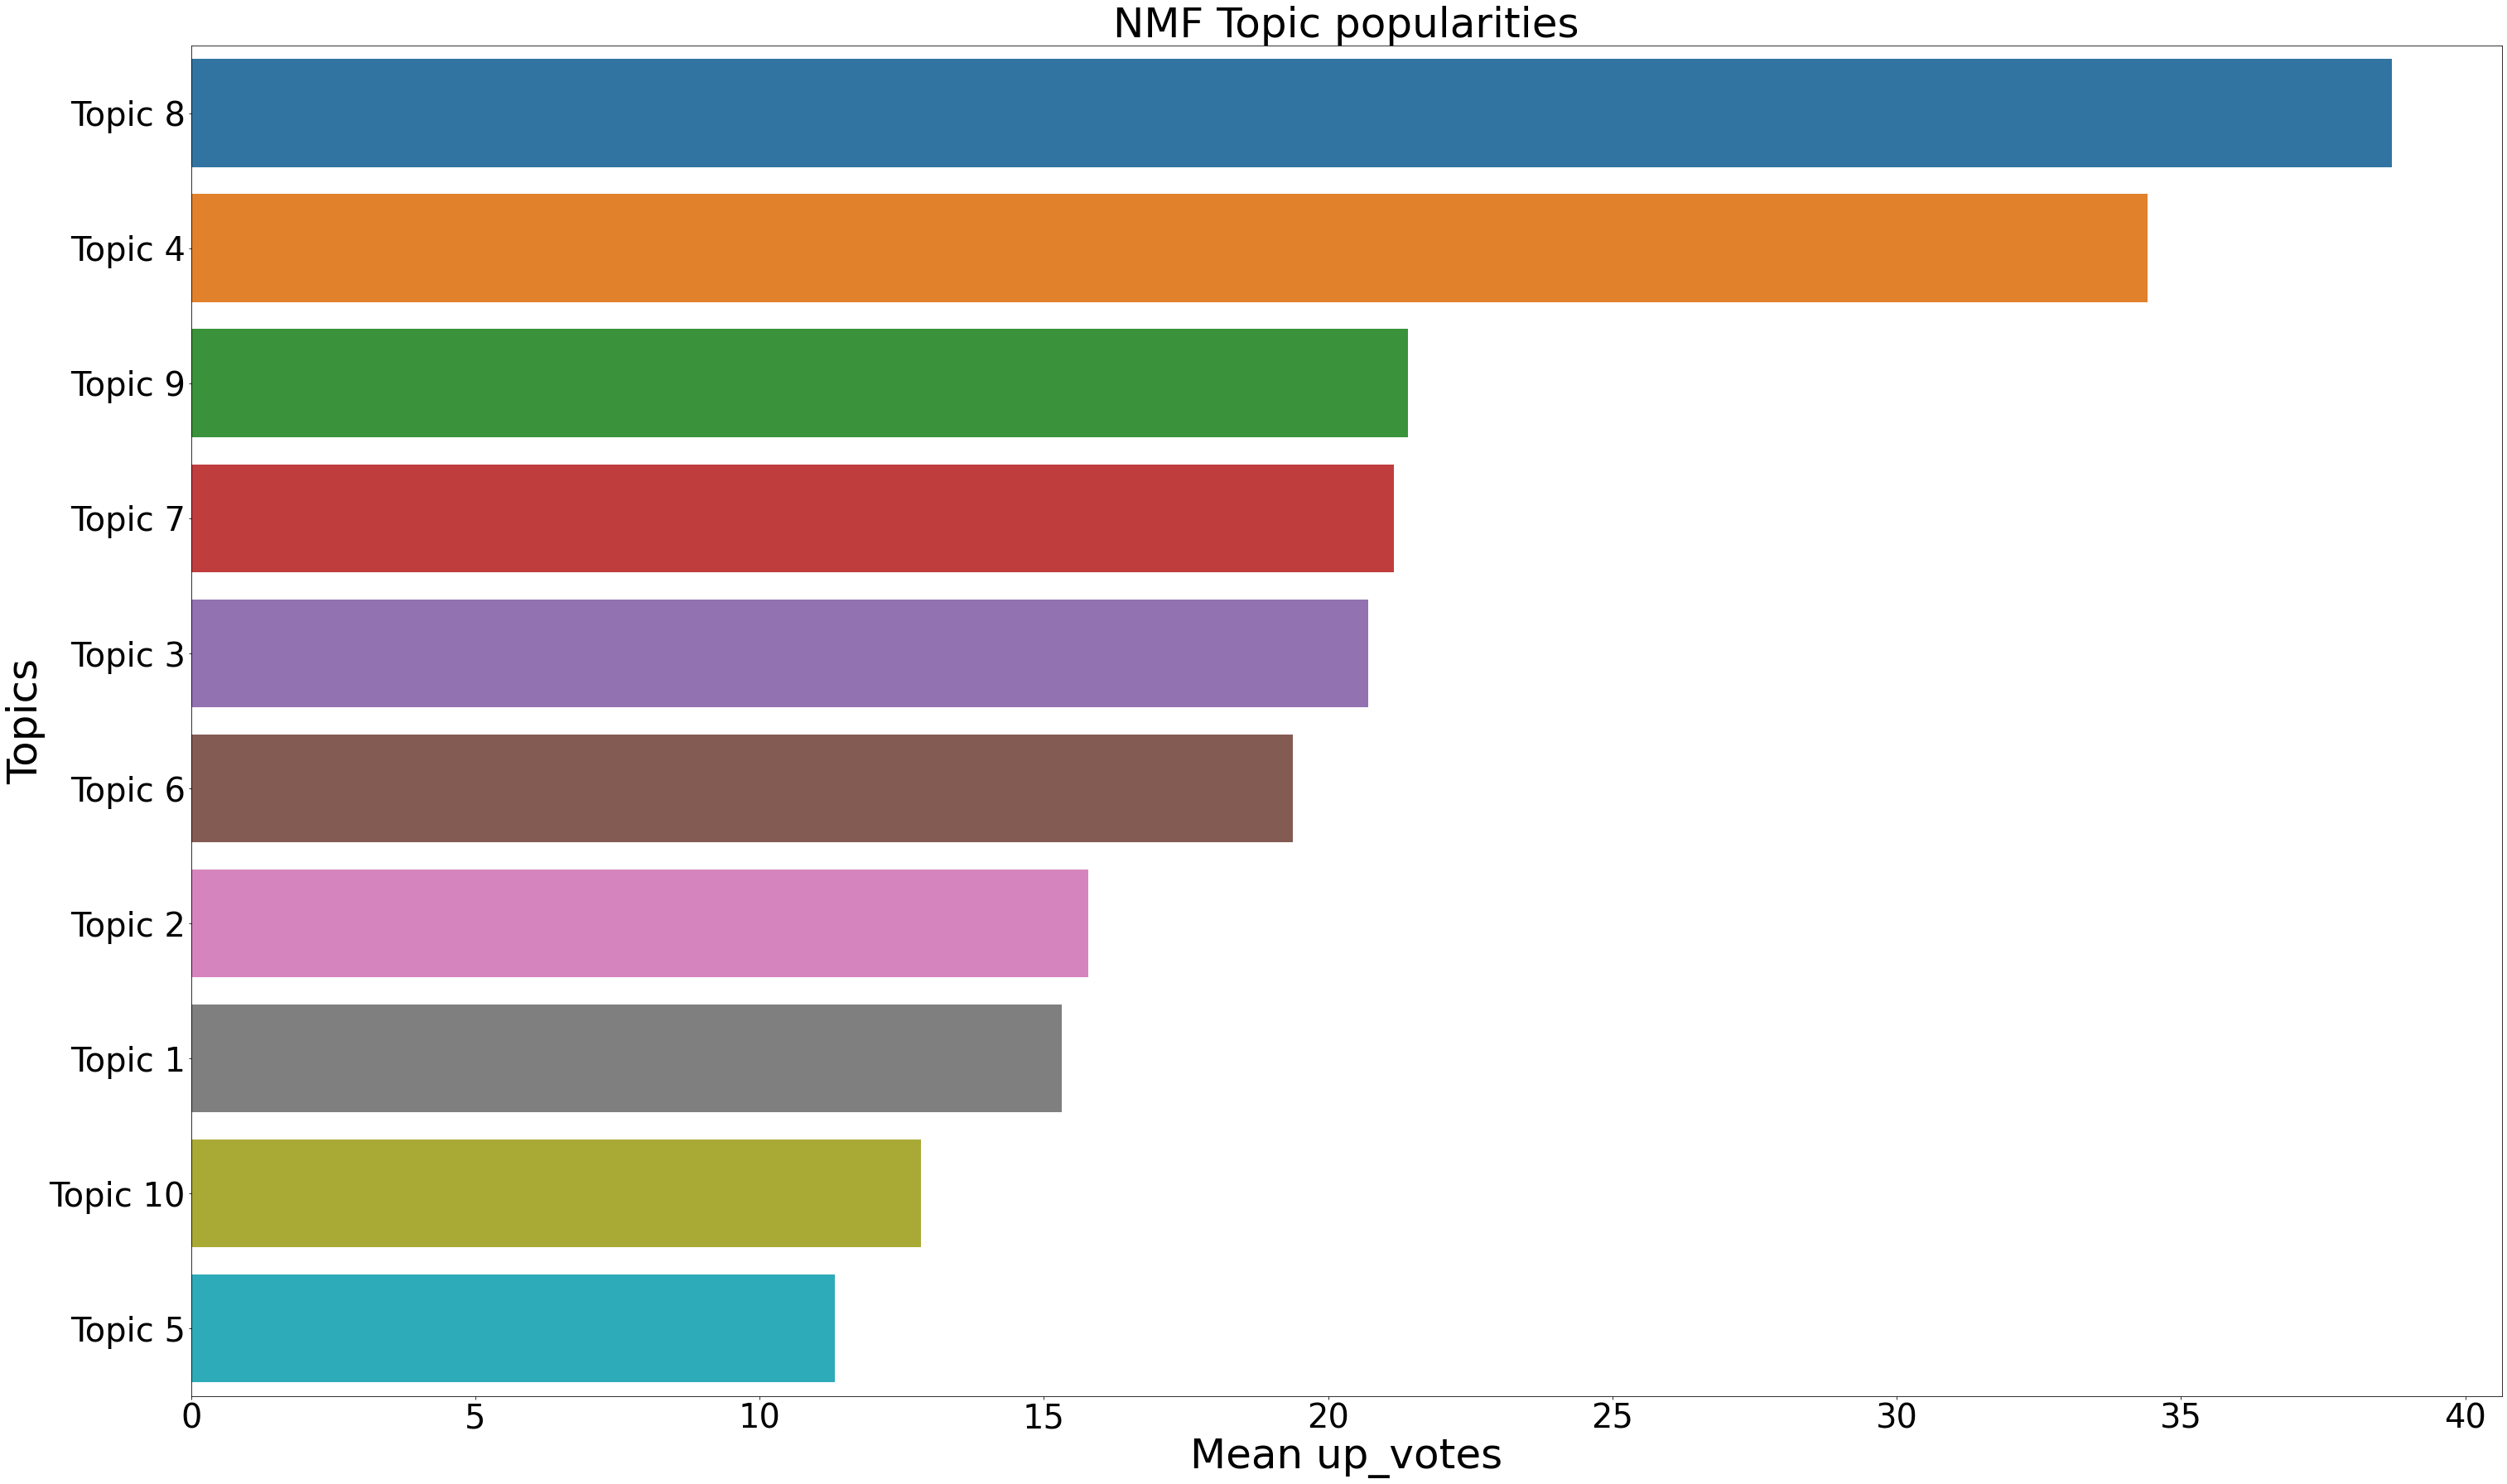

In [65]:
# Let's look at the popular bigrams only from 2008
year = 2008

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with only bigrams)', year)

The way in which this is significantly different is that there aren't that many bigrams. Hence we see the bigram weights vanish almost immediately in a topic. Also bigrams tell a lot more about the topics than the unigrams on their own. For example somali and pirate occuring together clarifies the topic further. Similarly 'middle east', 'beijing olympics'. 

**Let's look at a more recent year - 2016**

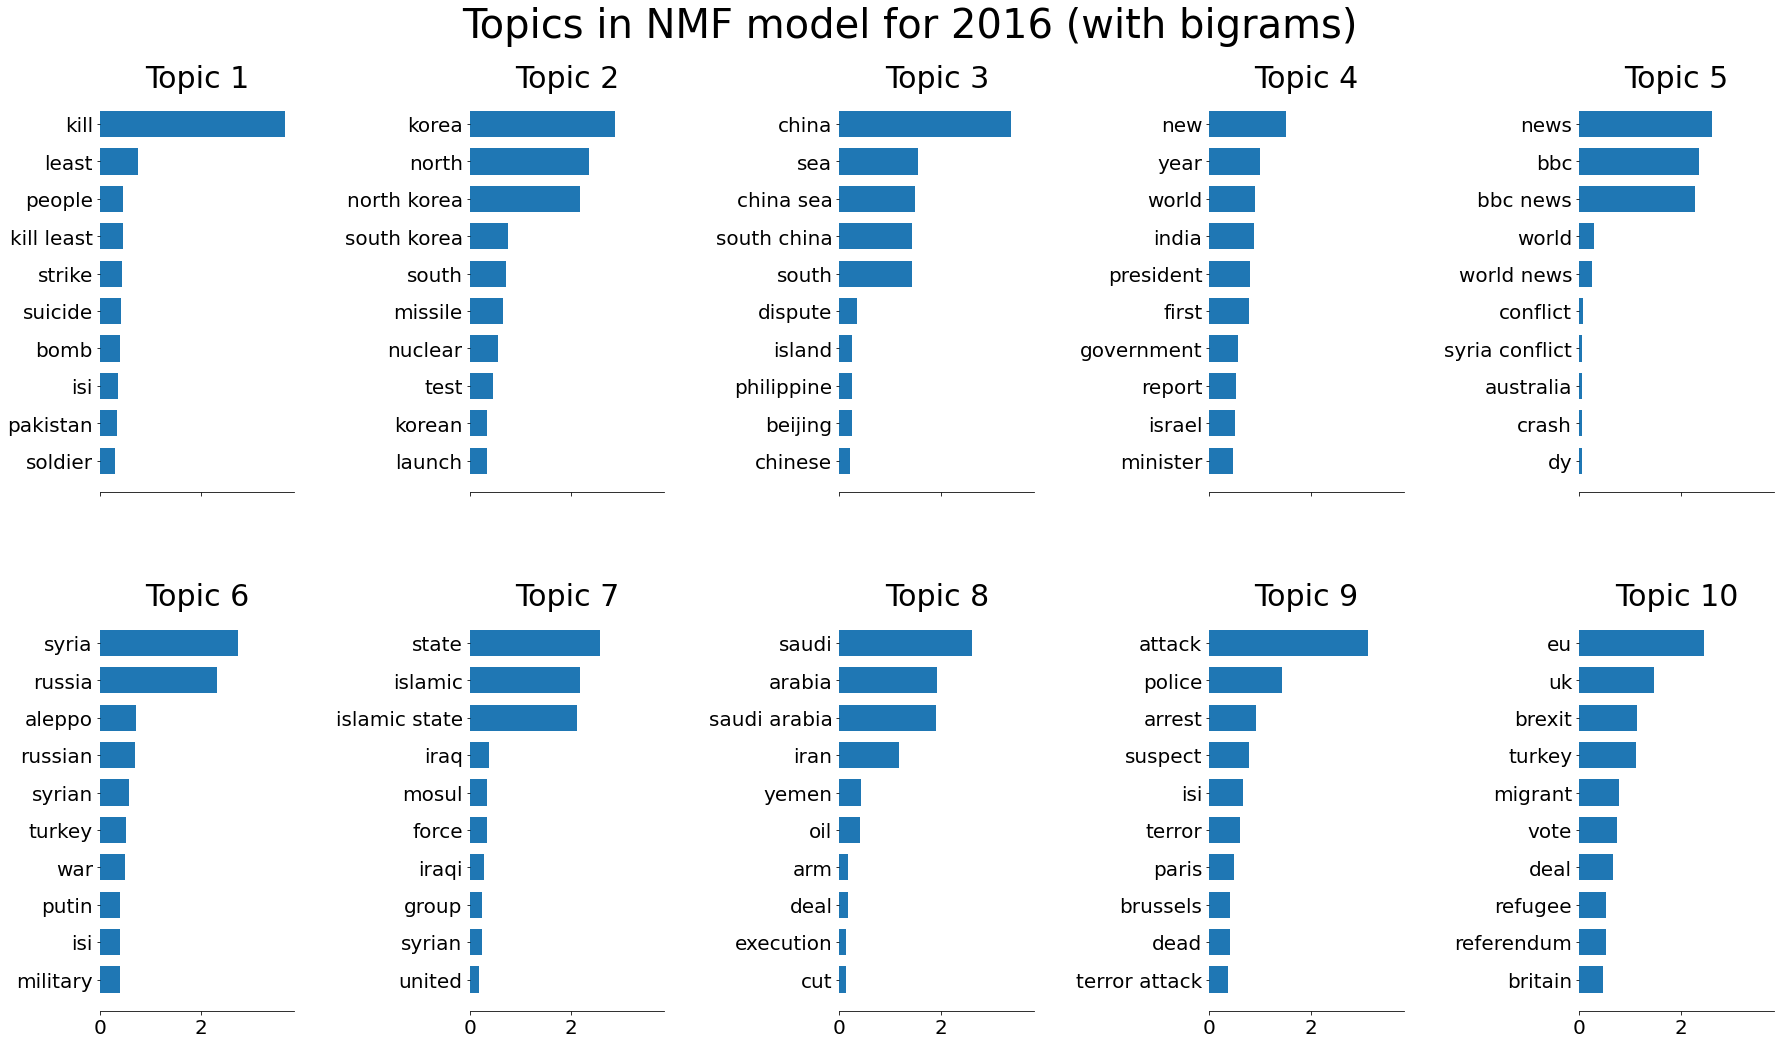

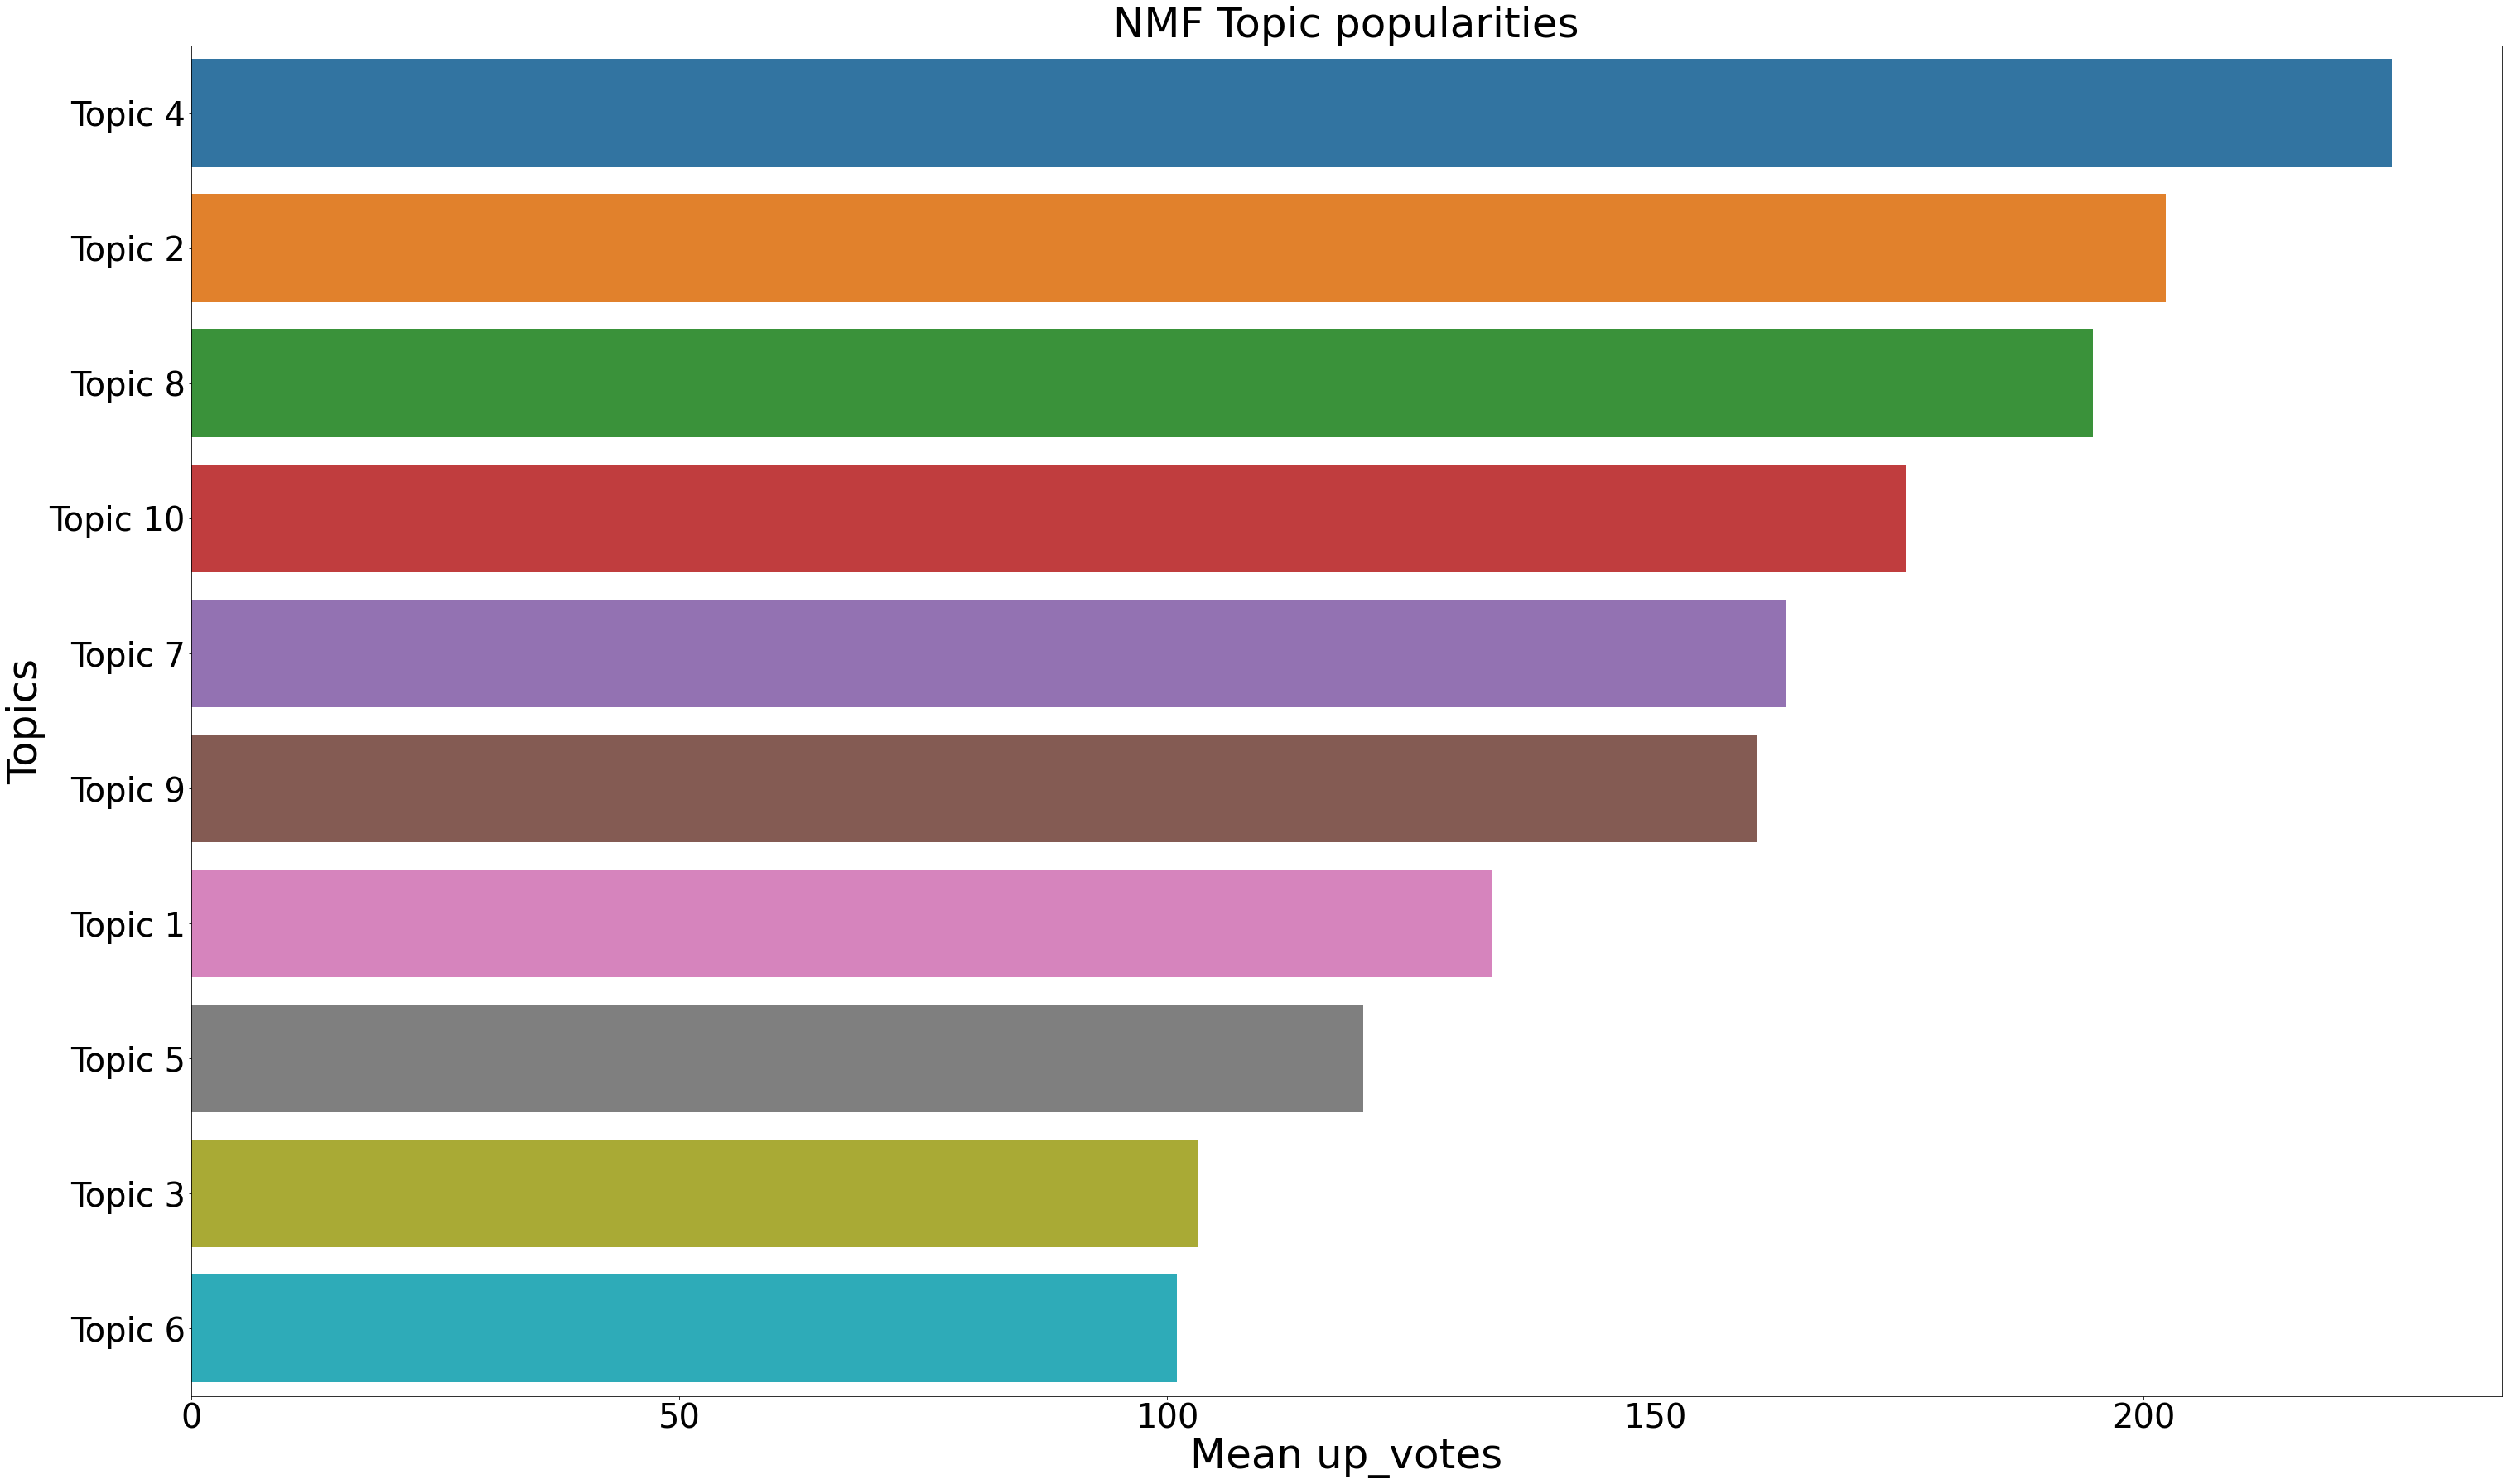

In [66]:
year = 2016

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with bigrams)', year)

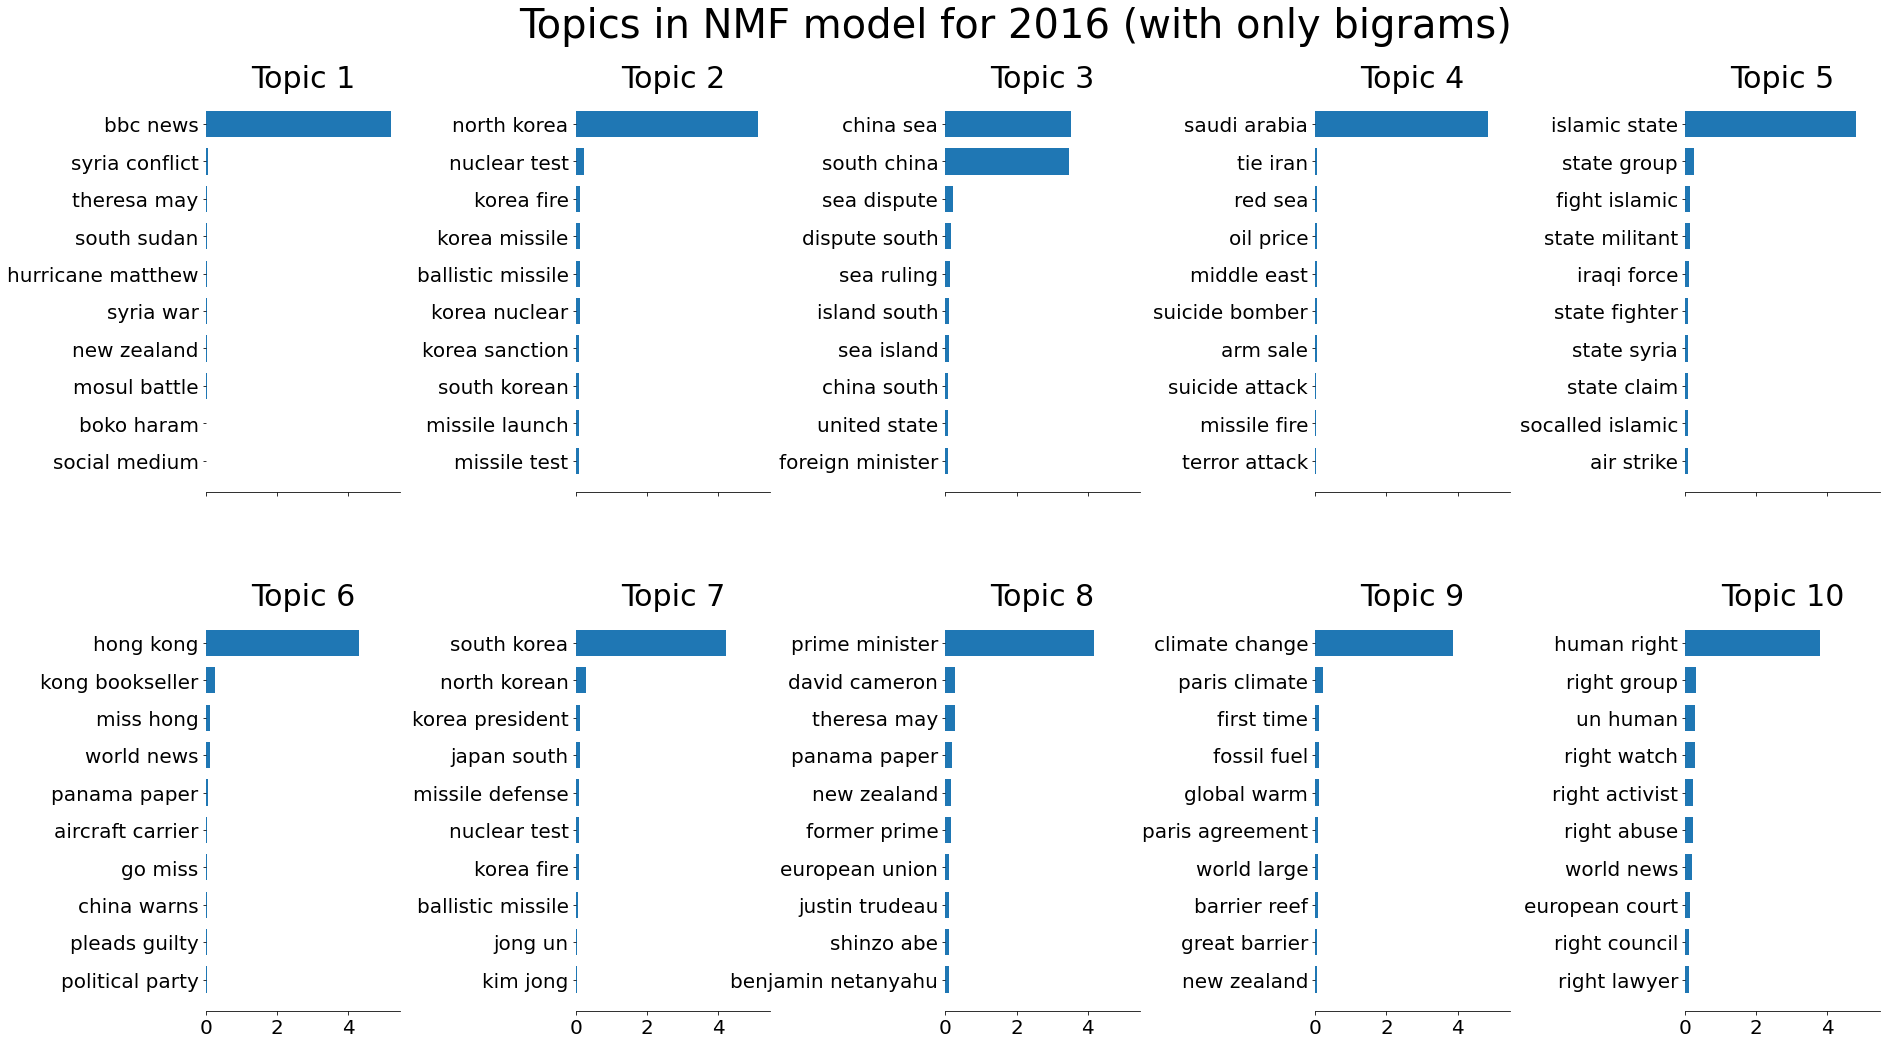

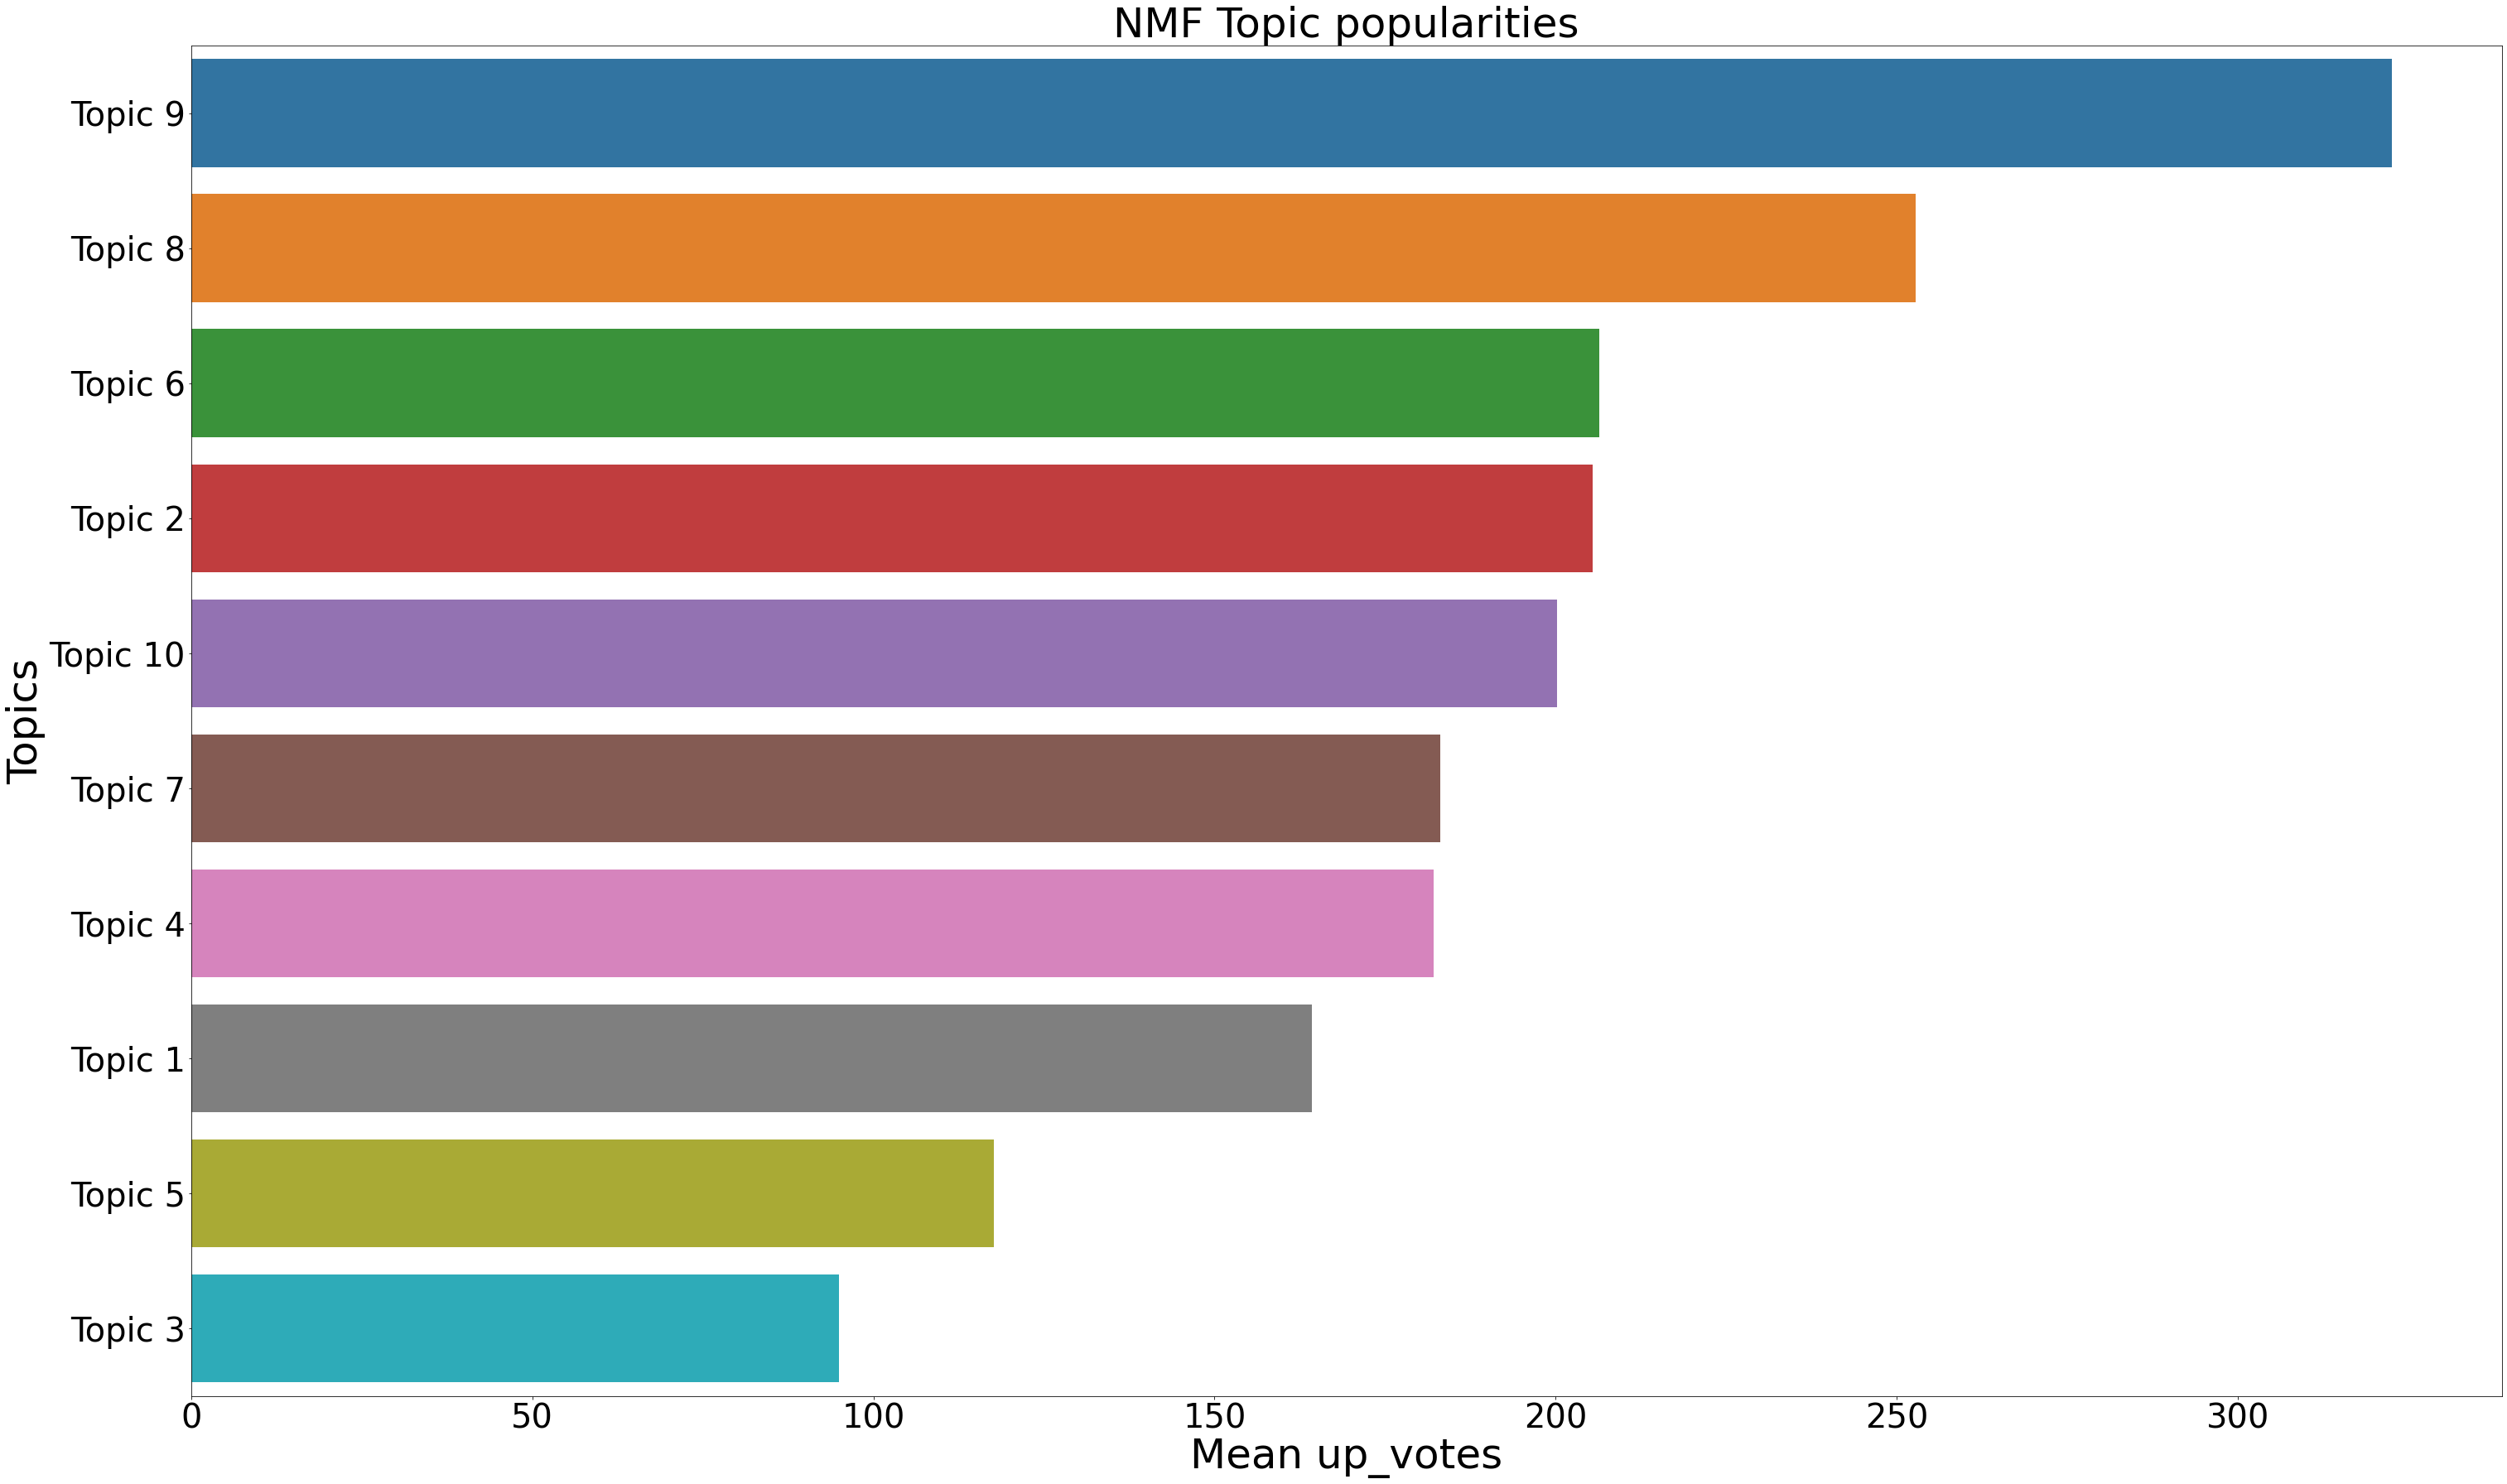

In [67]:
# Let's look at the bigrmas only
year = 2016

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with only bigrams)', year)

**This is really interesting now !** We have some new topics altogther for example the one on climate change (topic 9) and if you carefully look at the other bigrams in the topic, they are all related to the topic of climate change. And on top of that, it has the highest average upvotes which is significantly higher that any of the other topics considered in the unigrams sections. Sometimes for the unigrams, even if they end up with a high weightage, they don't necessarily convey anything meaningful instead they end up clouding some of the other important topics that can only be expressed by bigrams.

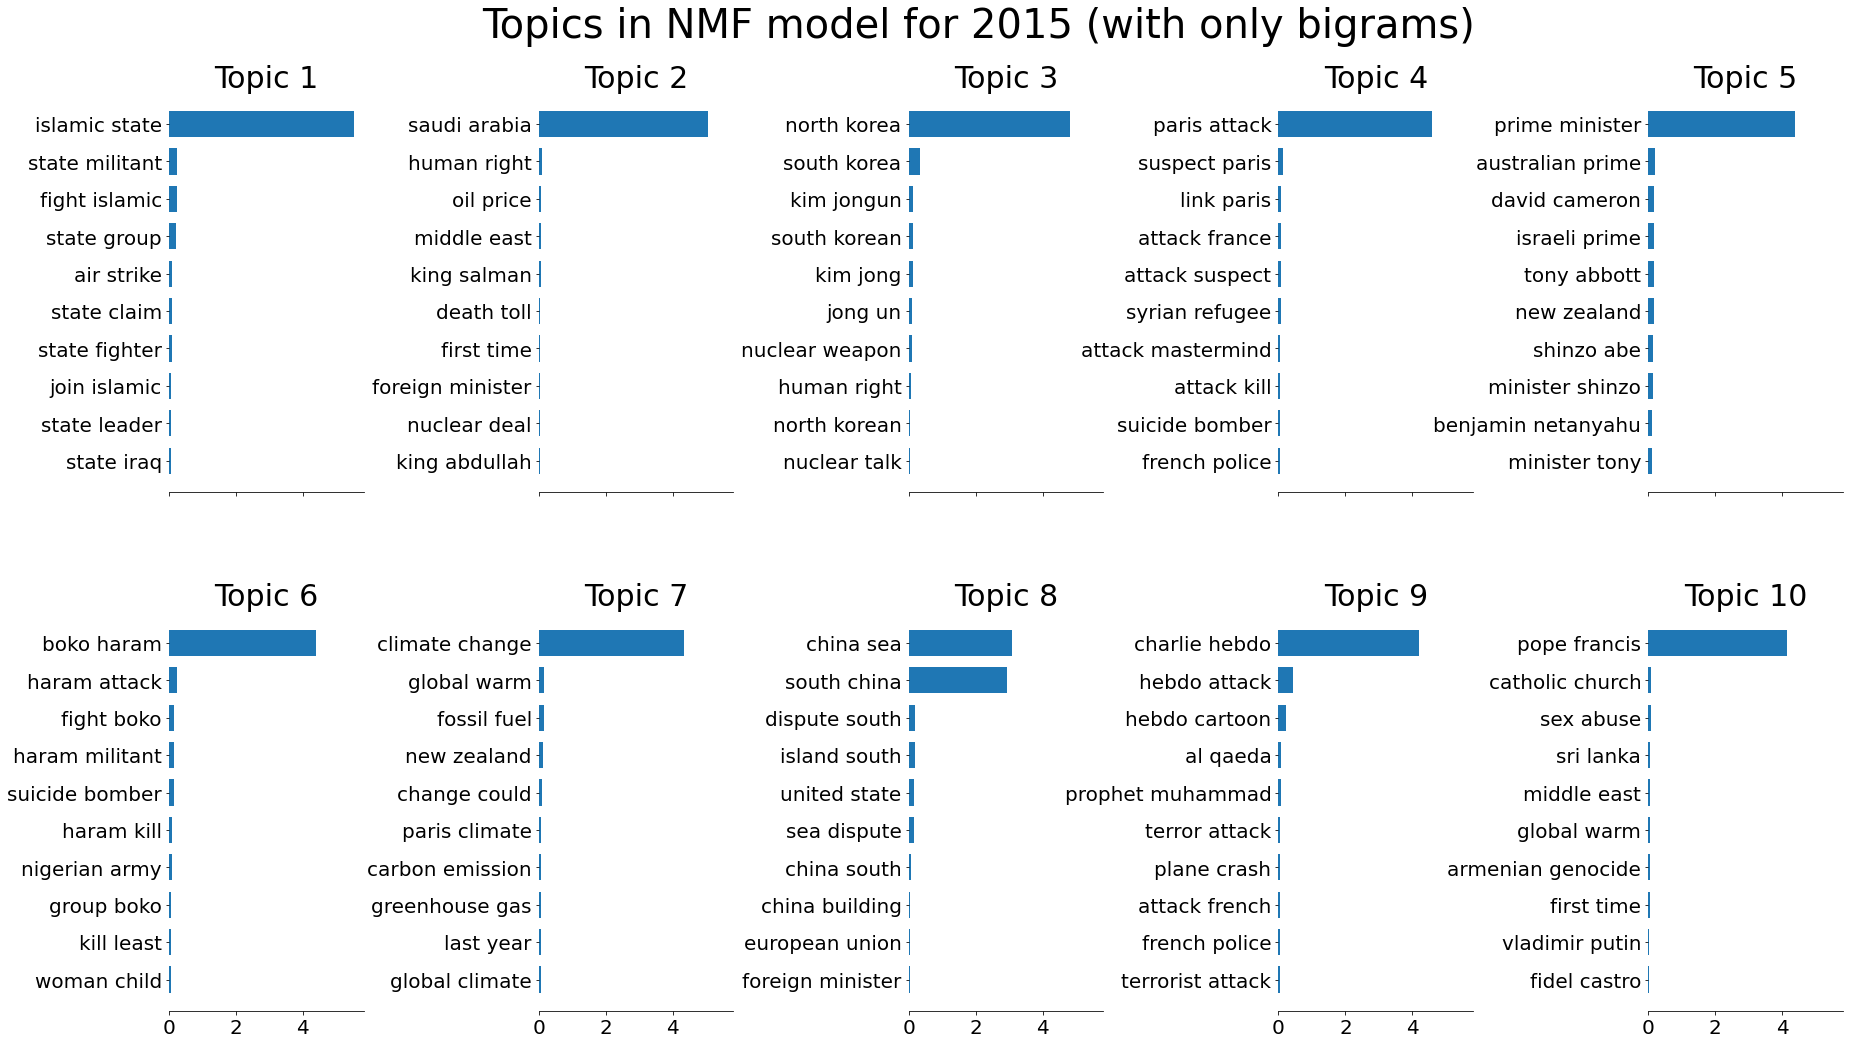

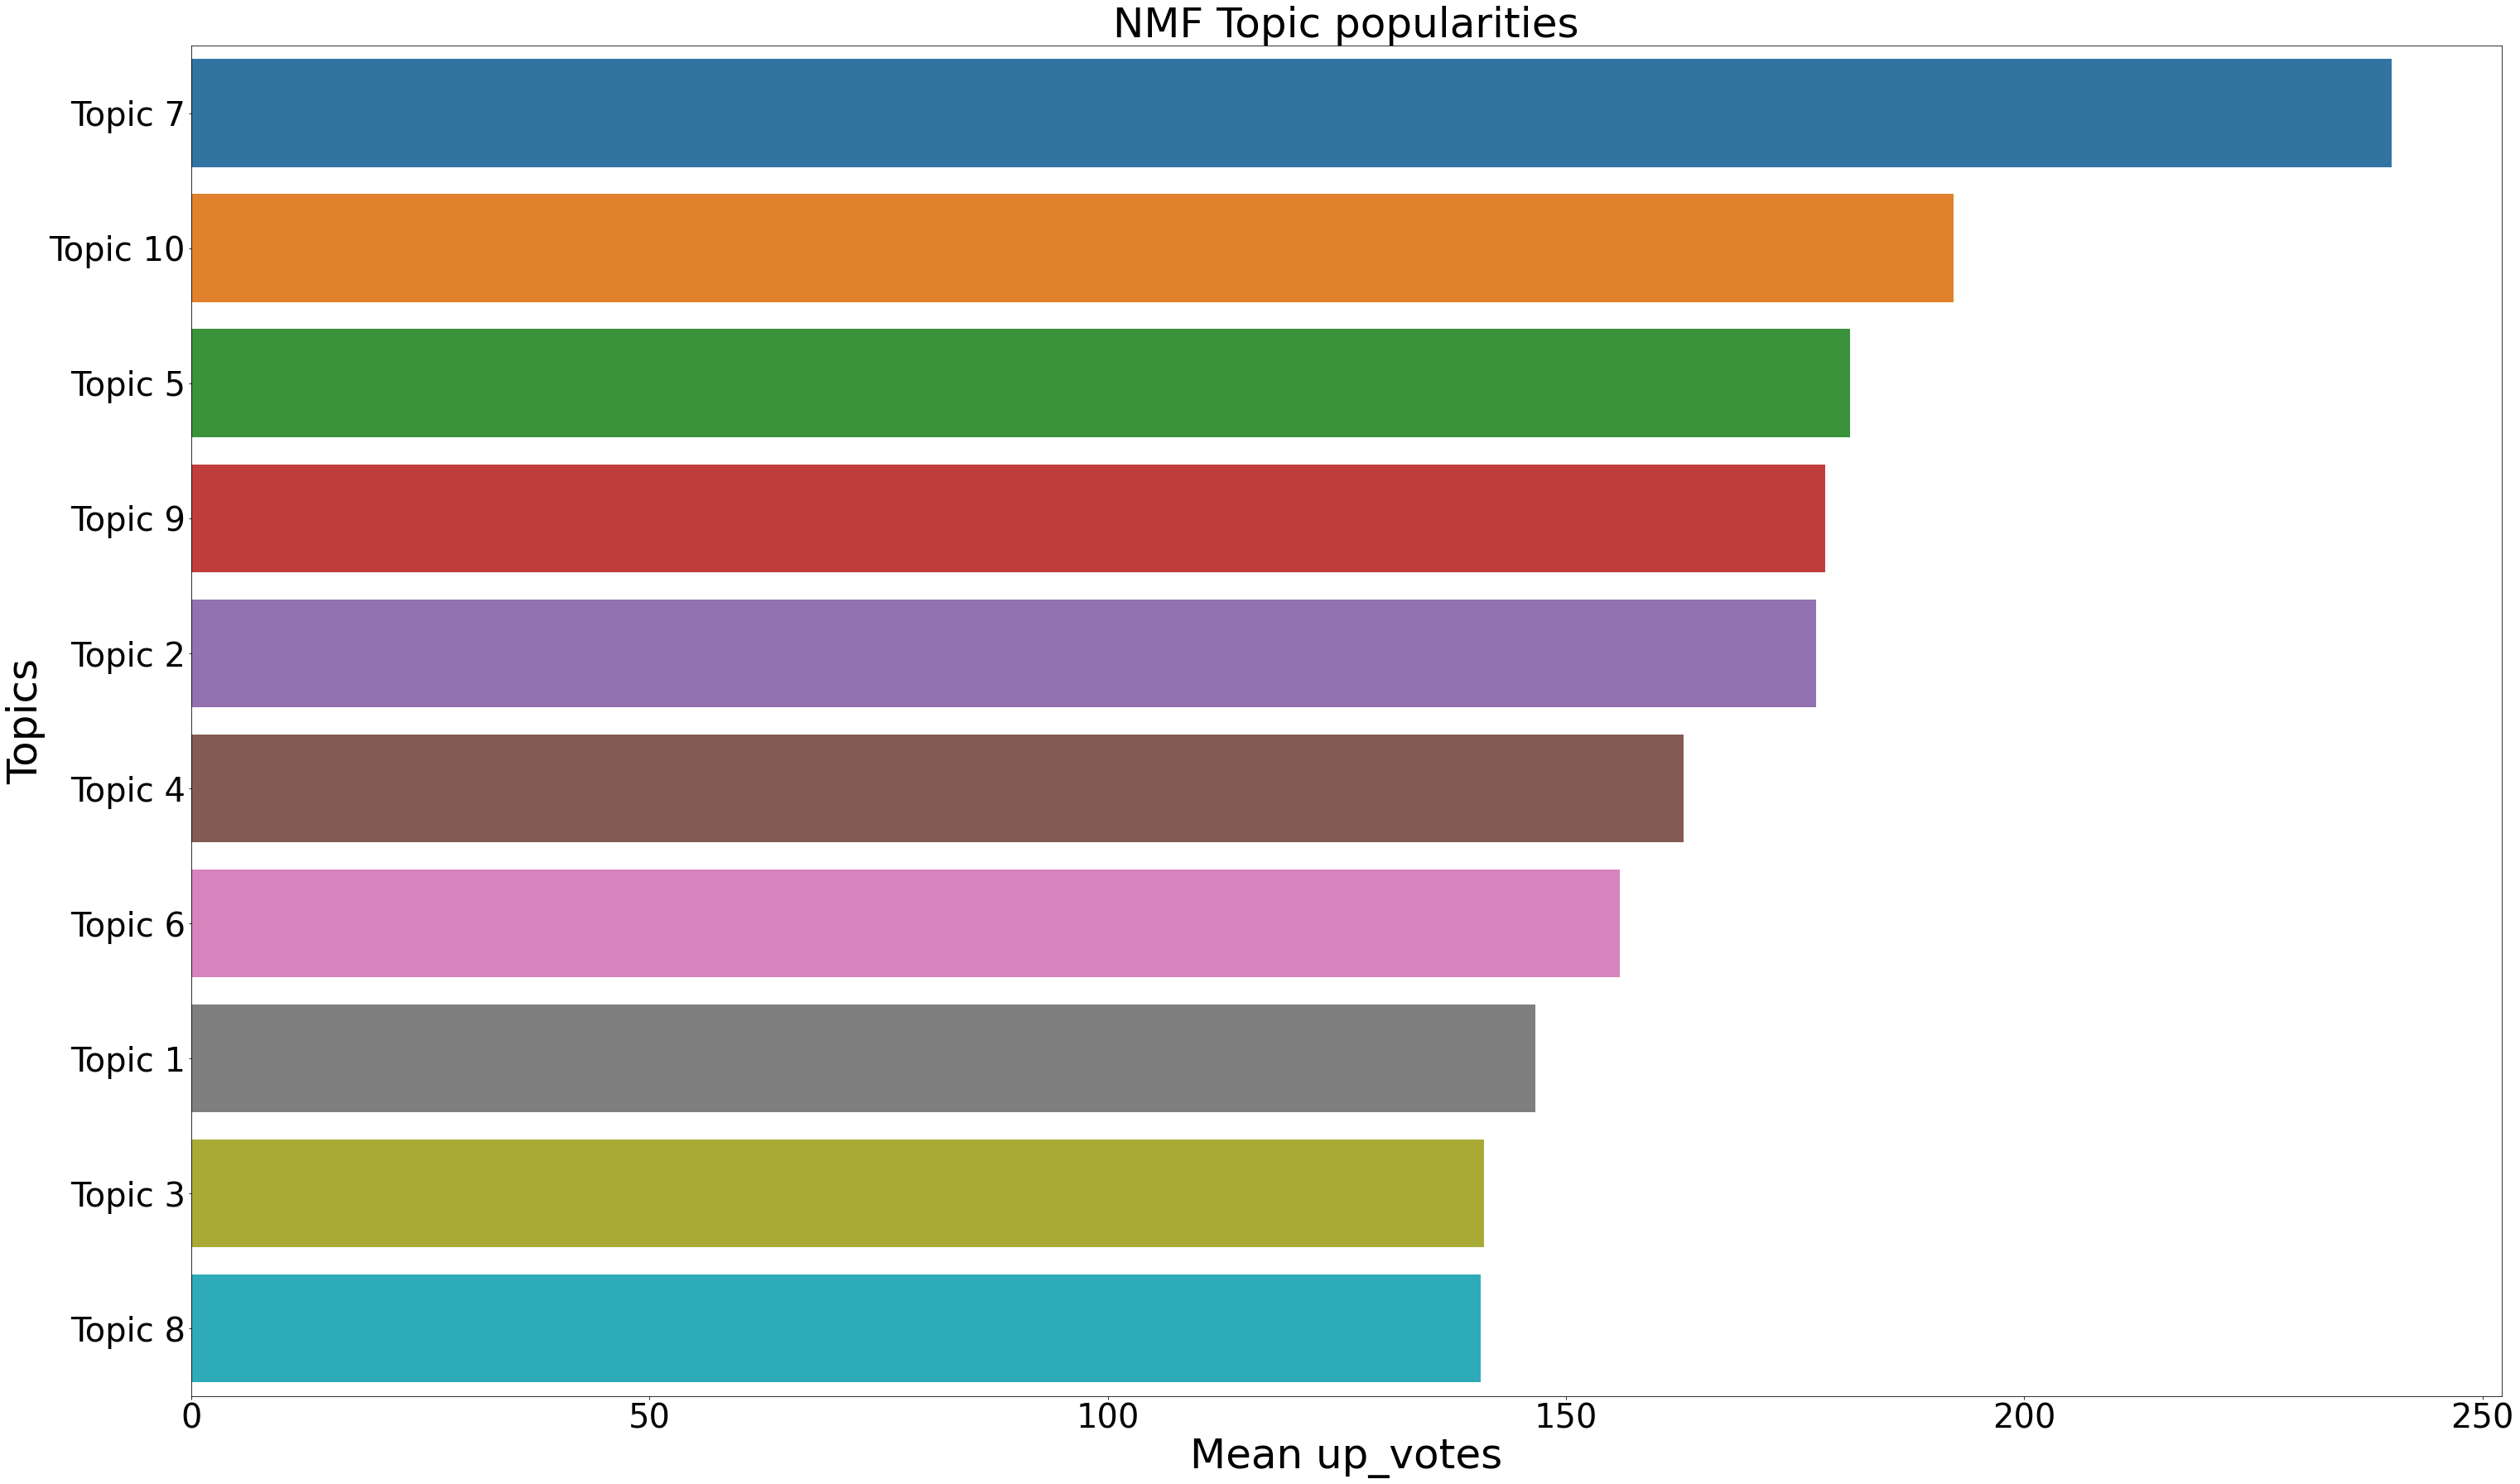

In [68]:
# Let's continue this analysis for 2015 and look at only bigrams
year = 2015

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with only bigrams)', year)

Apart from some similar news from 2016 (which is expected), we have some new ones never seen in the unigrams analysis - **boko haram** and **charlie hebdo**.  

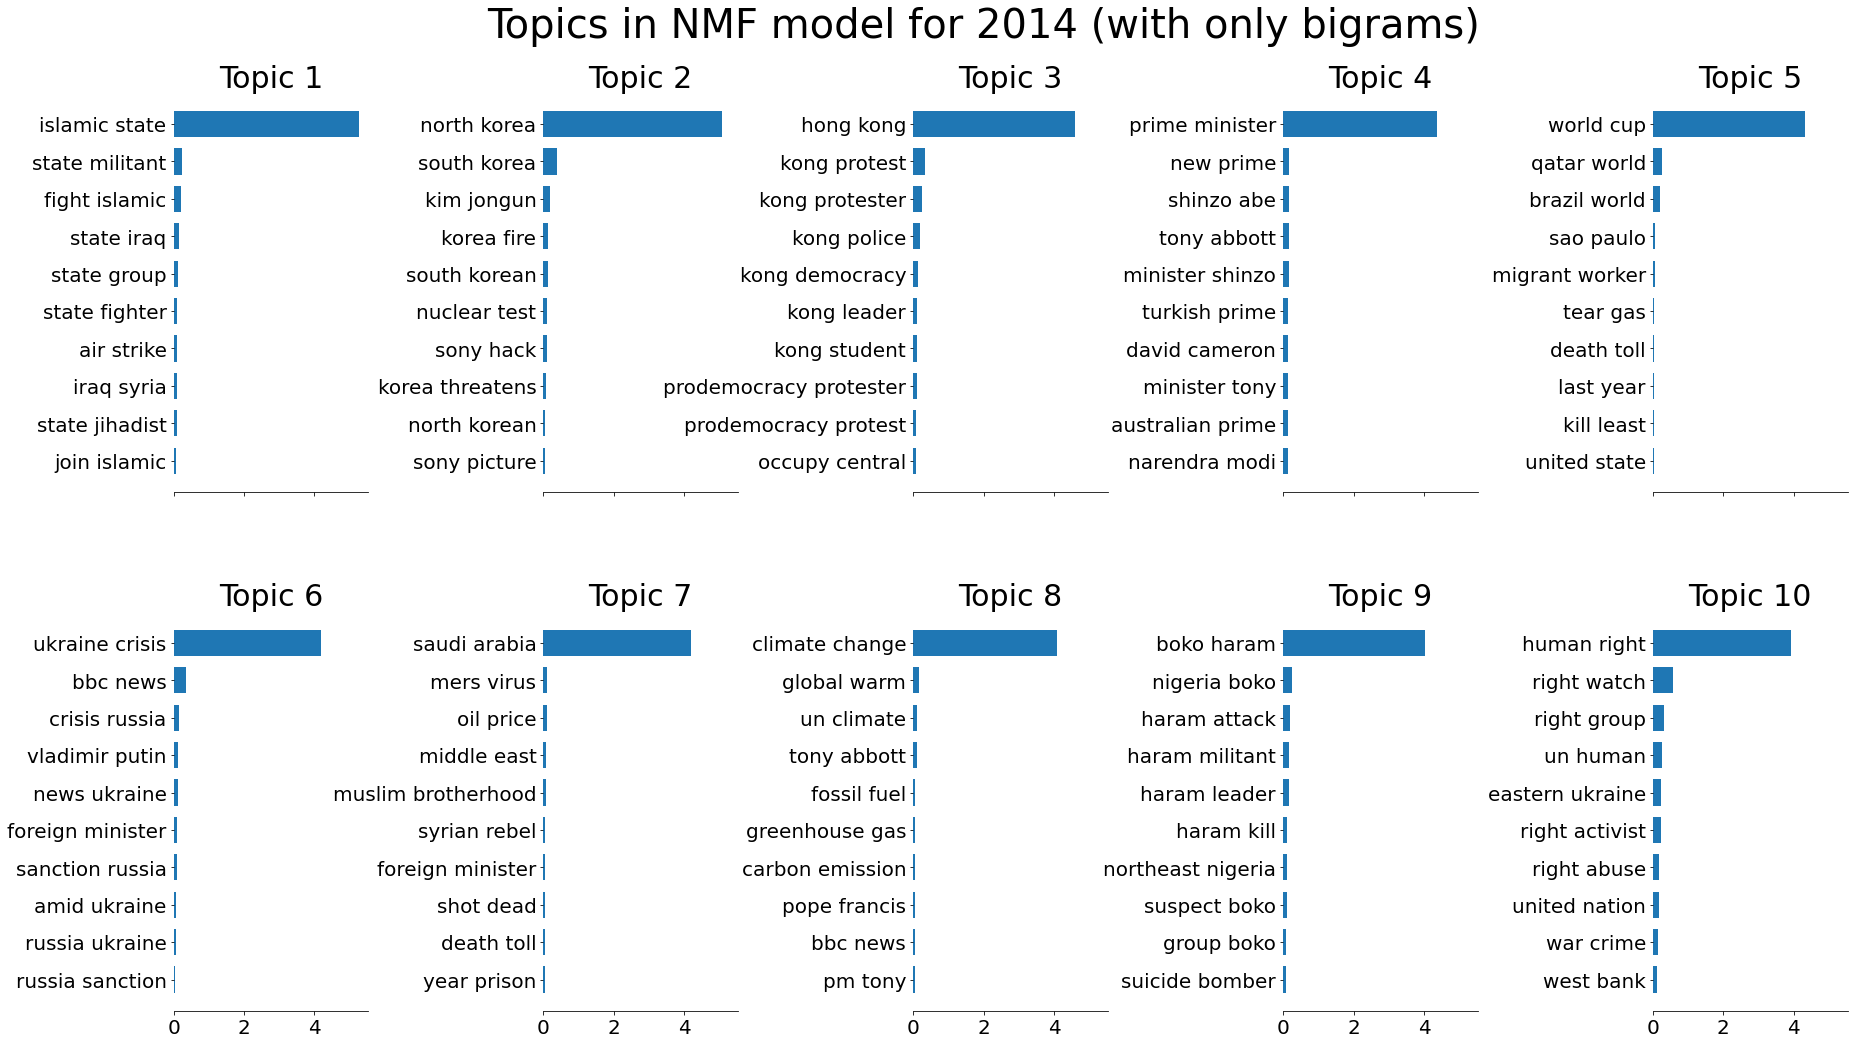

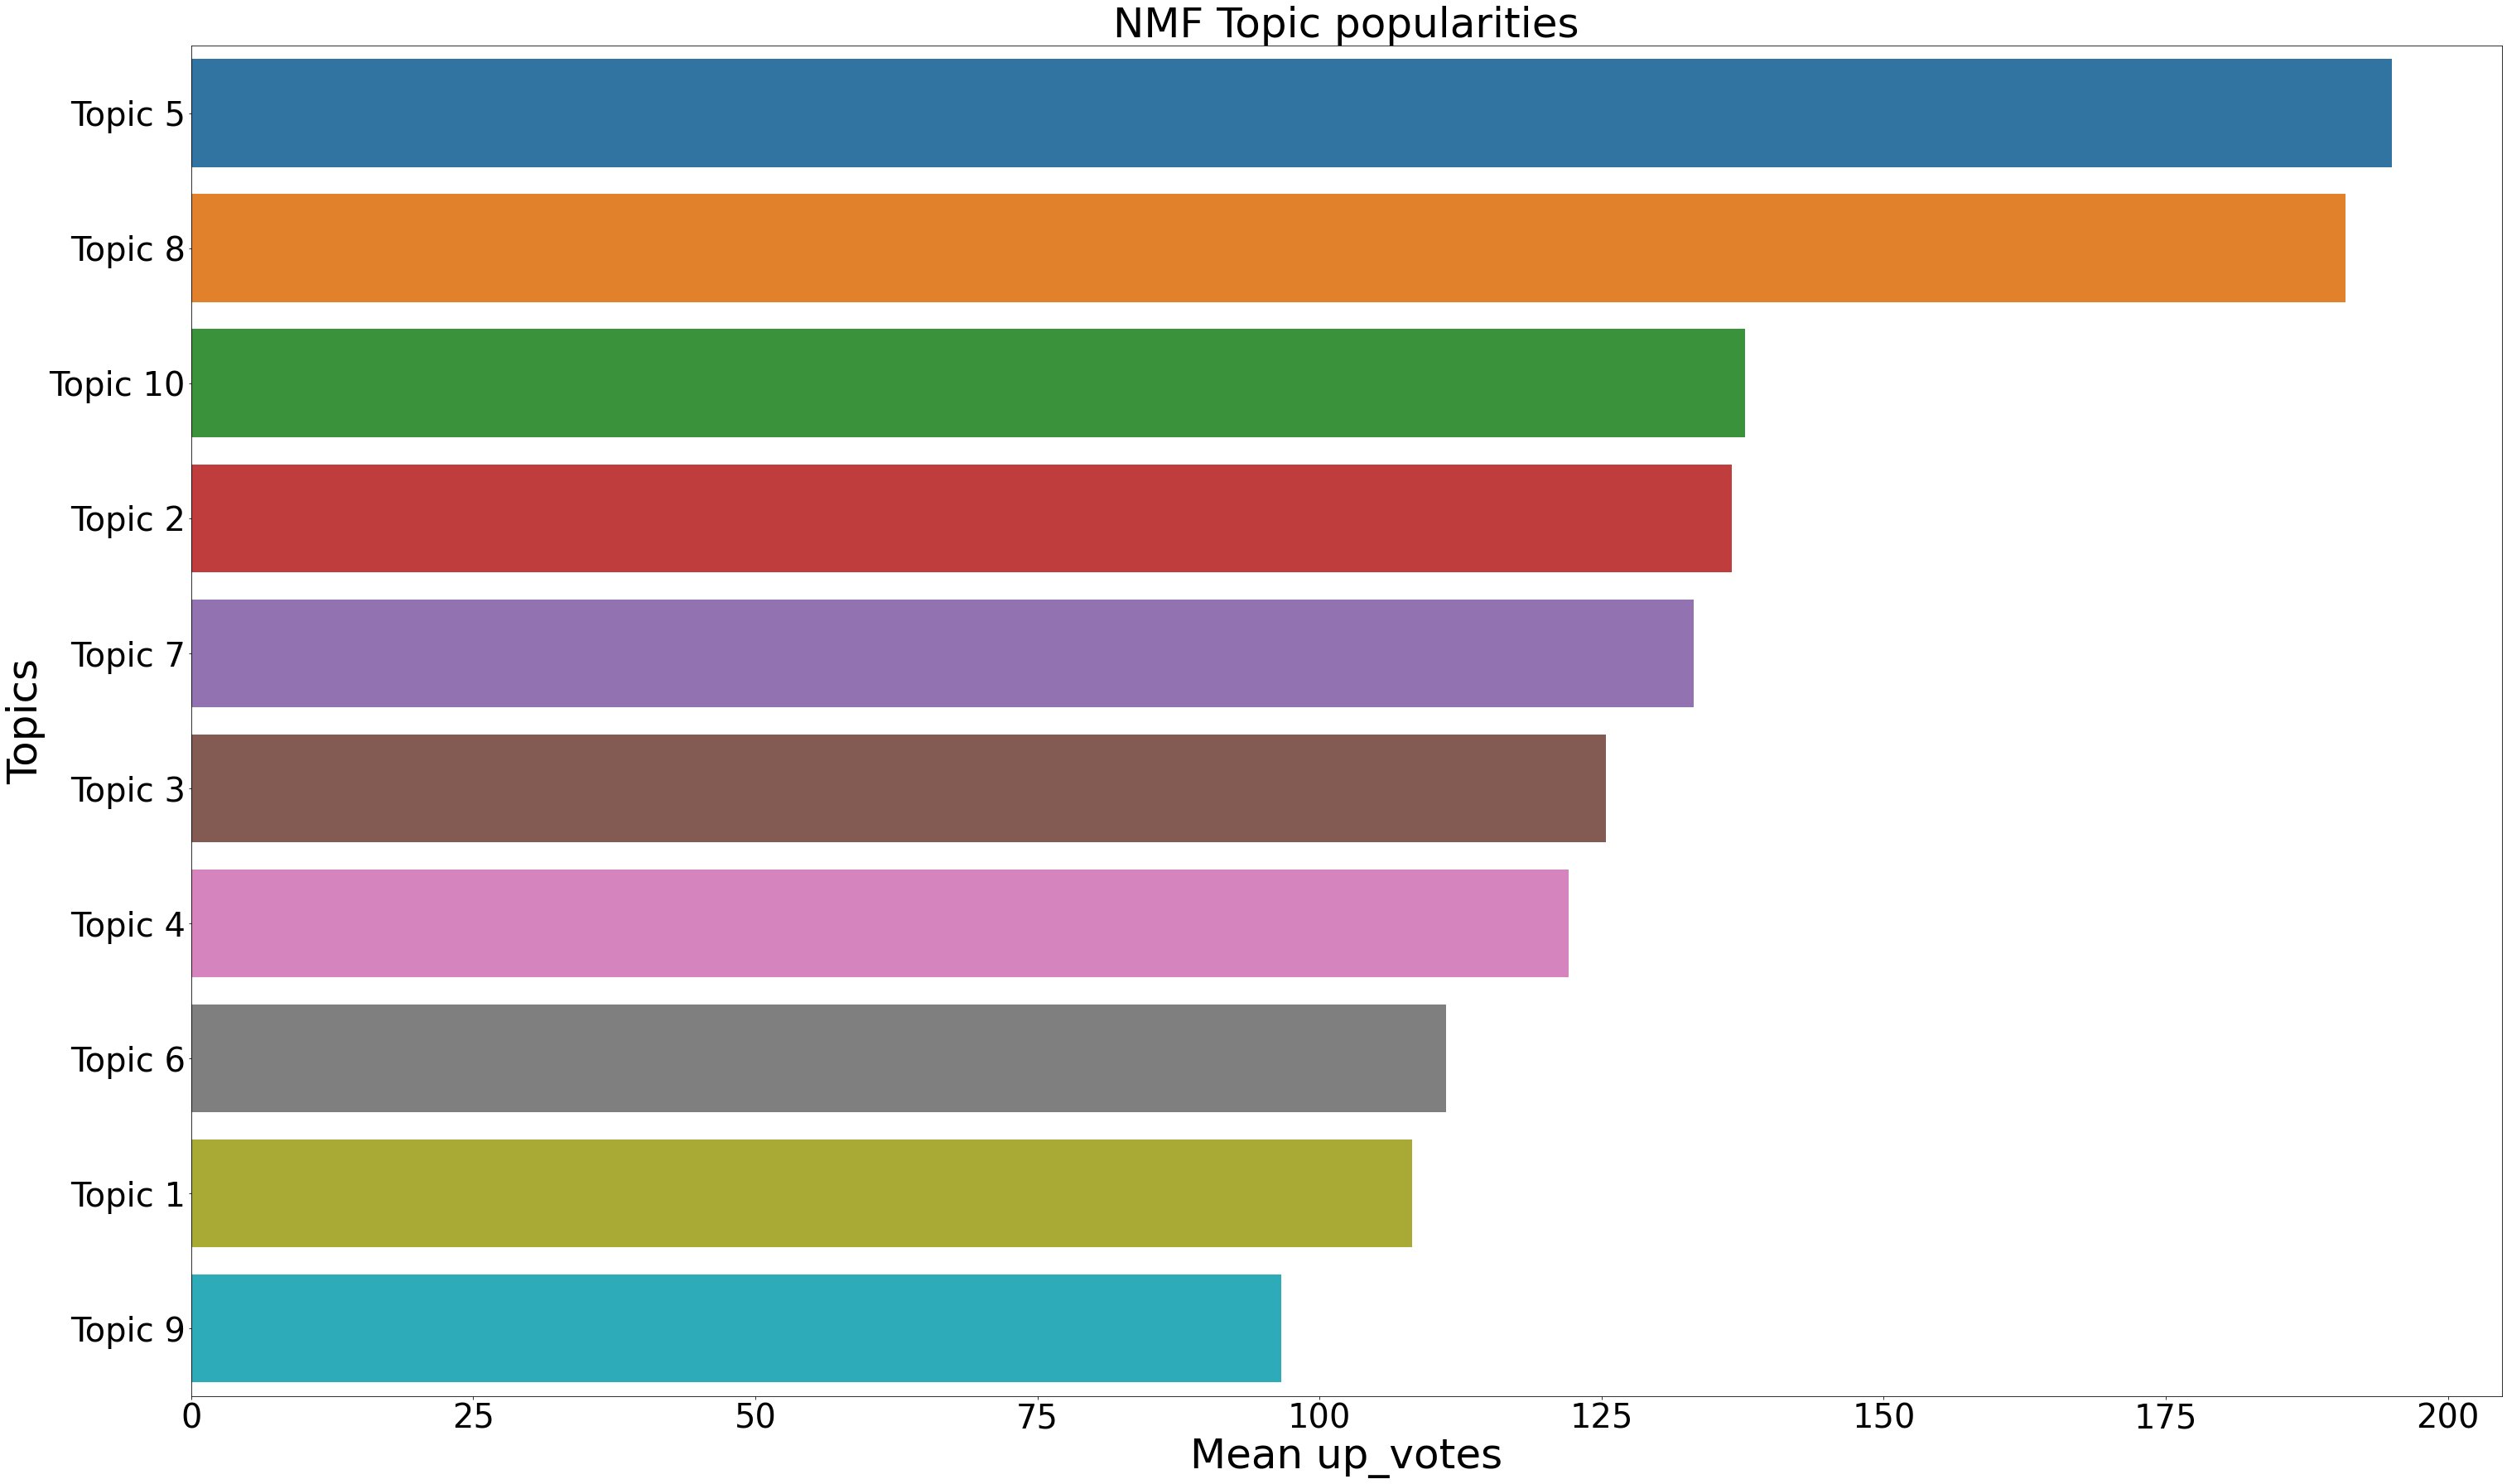

In [69]:
# 2014 men's soccer word cup in Brazil pops out with the bigram analysis
year = 2014

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with only bigrams)', year)

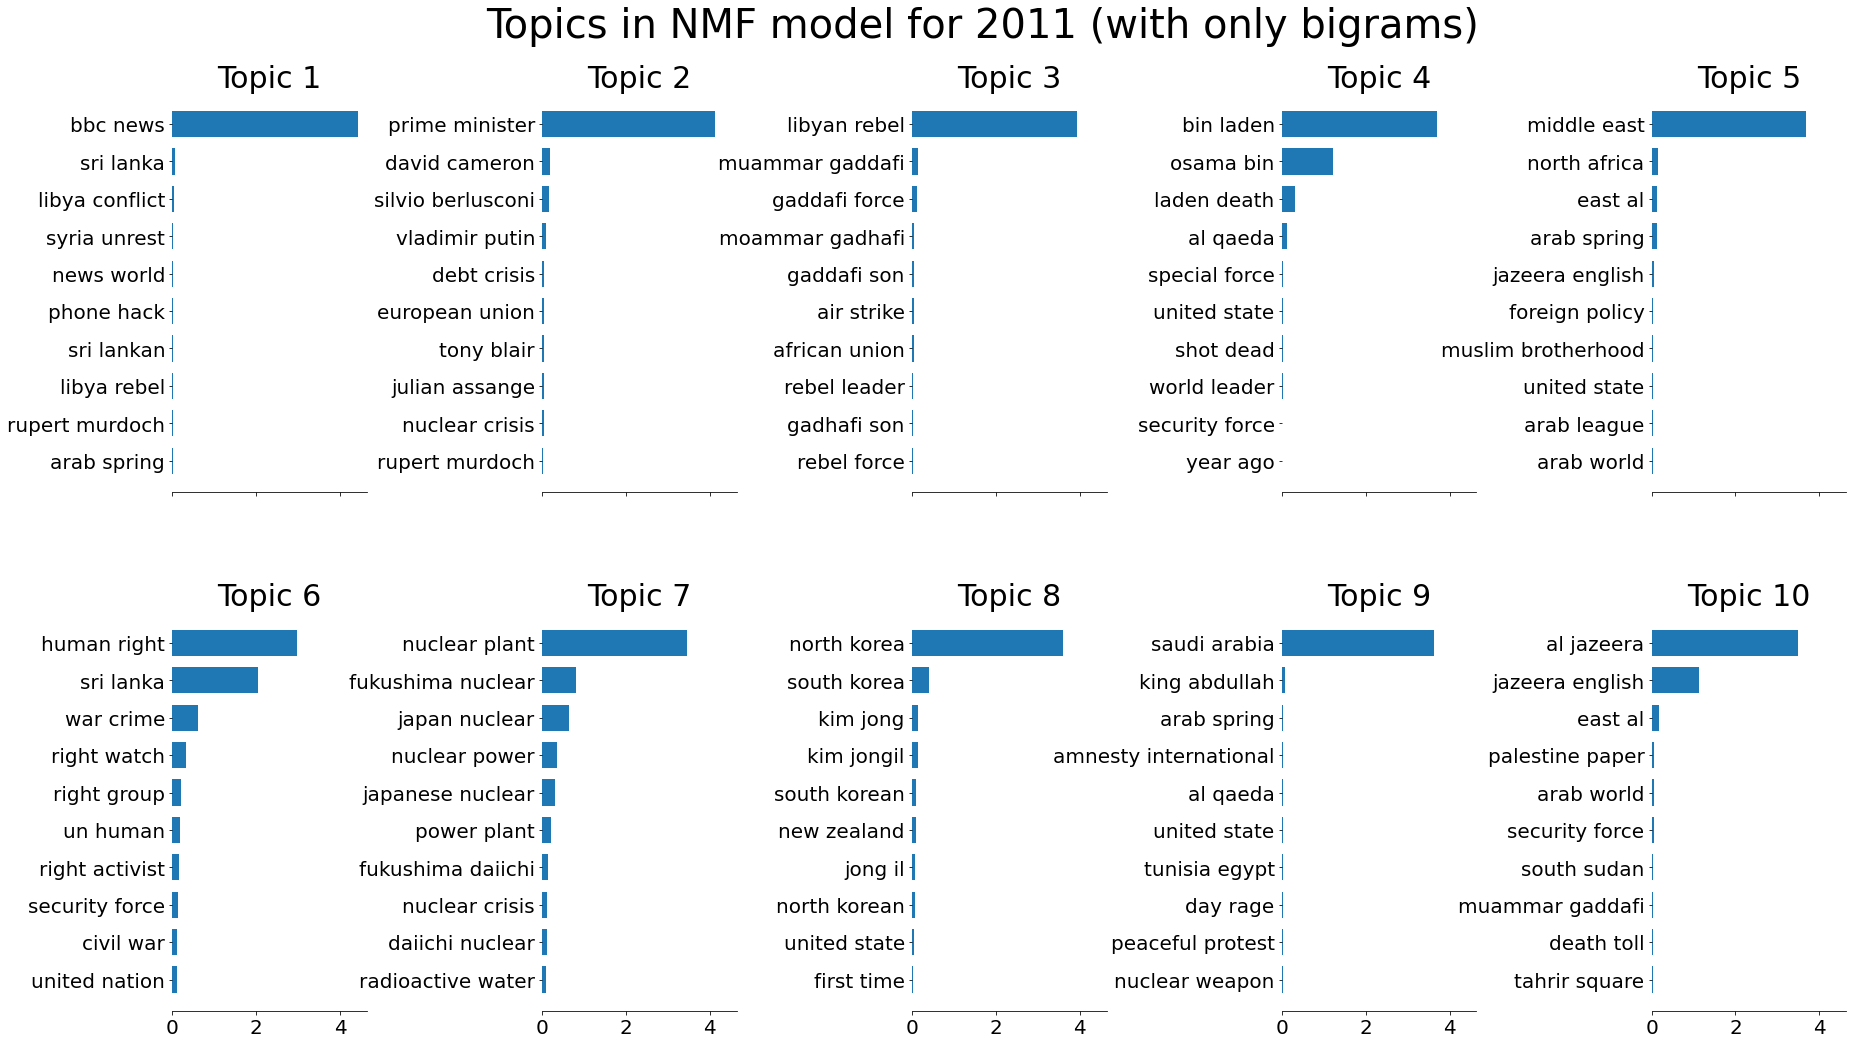

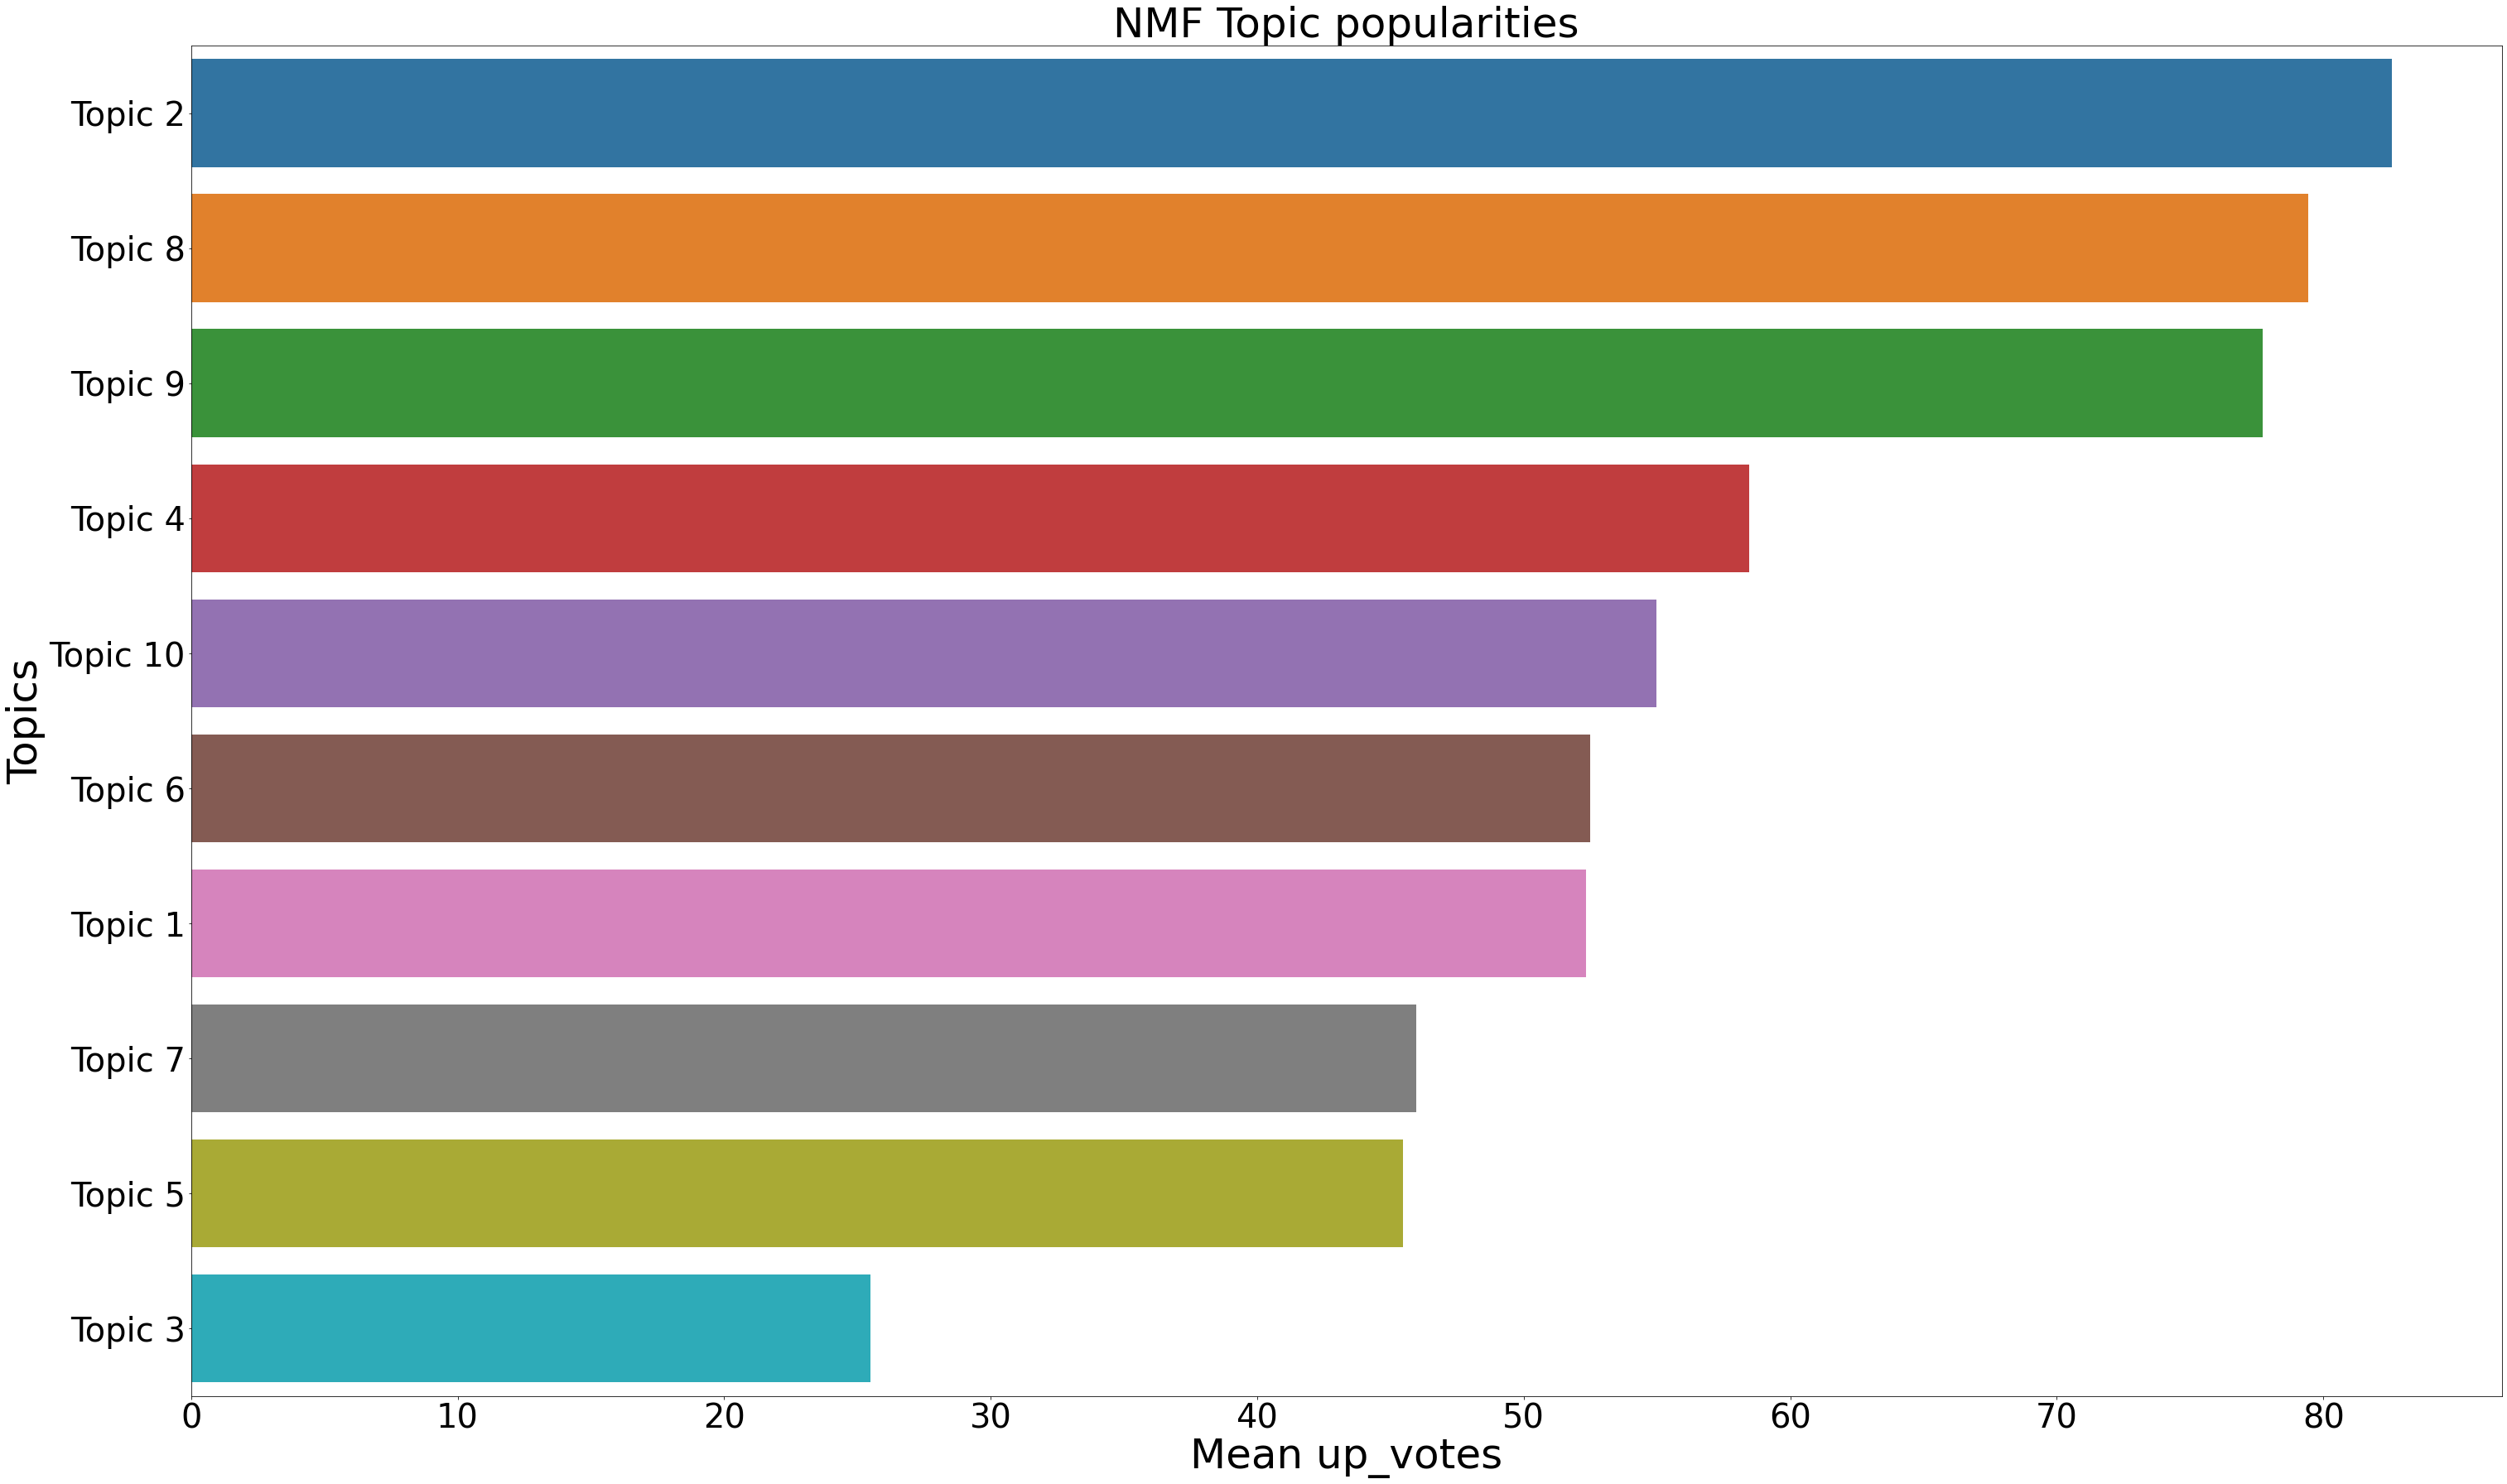

In [70]:
# Let's look at a year we haven't explored before.
# News of osama bin laden's being shot dead in 2011
year = 2011

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with only bigrams)', year)

**So the basic takeaway here is to analyize different n_grams to extract all possible and equally important information from a dataset like this.**

## How about the authors of the articles?

Now we could use the same functions to charcterize the authors by looking at the kind of news they cover.

In [71]:
def plot_popular_topics_by_author(nmf, tfidf_feature_names, n_top_words, title, author):
    
    plot_top_words(nmf, tfidf_feature_names, 10,
               title)

    df_copy = df.loc[df['author']==author,:].reset_index()
    nmf_topic_values = nmf.transform(tfidf)
    df_copy['nmf_topics'] = nmf_topic_values.argmax(axis=1)

    nmf_remap = {0: 'Topic 1', 1: 'Topic 2', 2: 'Topic 3', 3: 'Topic 4', 
                 4: 'Topic 5', 5: 'Topic 6', 6: 'Topic 7', 7: 'Topic 8', 
                 8: 'Topic 9', 9: 'Topic 10'}
    df_copy['nmf_topics'] = df_copy['nmf_topics'].map(nmf_remap)

    nmf_x = df_copy.groupby('nmf_topics')['up_votes'].mean().sort_values(ascending=False)
    nmf_y = list(nmf_x.index)
    plt.figure(figsize=(50,30))
    sns.barplot(x = nmf_x, y = nmf_y)
    plt.title("NMF Topic popularities", fontsize=50)
    plt.ylabel('Topics', fontsize=50)
    plt.yticks(fontsize=40)
    plt.xlabel('Mean up_votes', fontsize=50)
    plt.xticks(fontsize=40)
    plt.show()

In [72]:
df.author.value_counts()[:10]

davidreiss666    8897
anutensil        5730
DoremusJessup    5037
maxwellhill      4023
igeldard         4013
readerseven      3170
twolf1           2923
madam1           2658
nimobo           2564
madazzahatter    2503
Name: author, dtype: int64

**Let's explore only the top two authors here. The same function can be used for the other authors.**

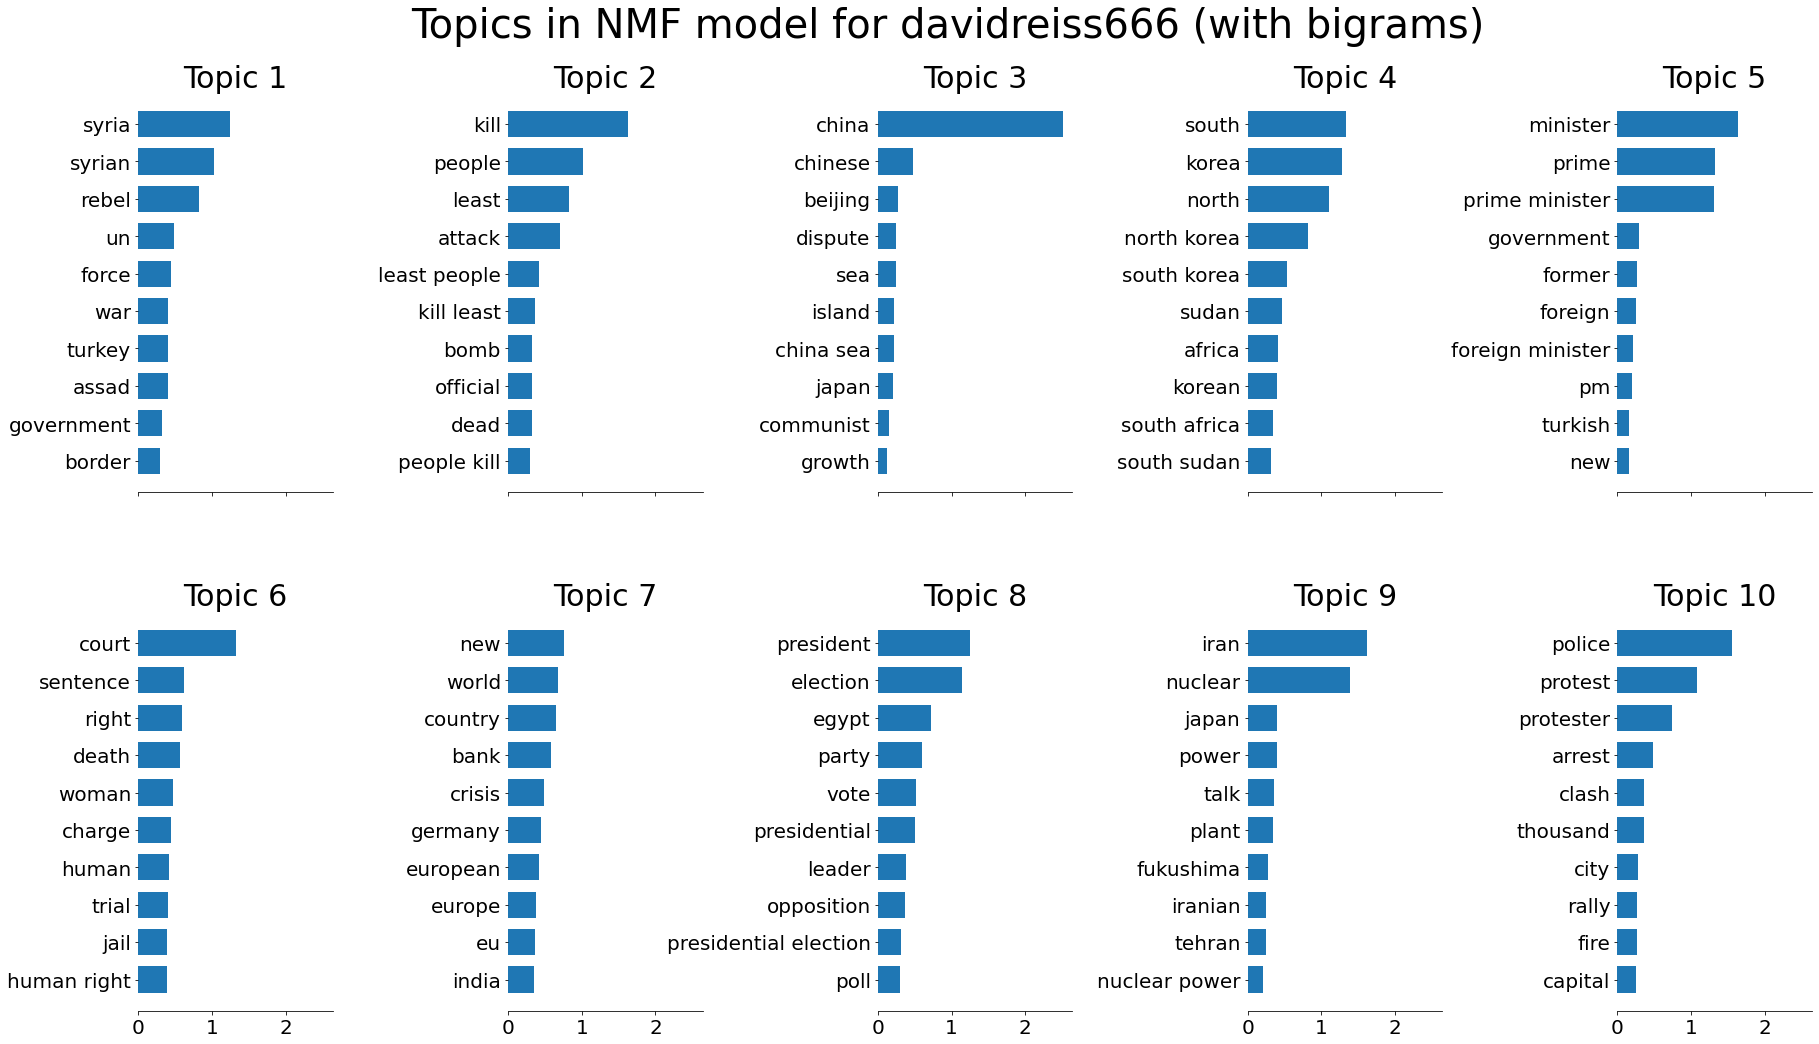

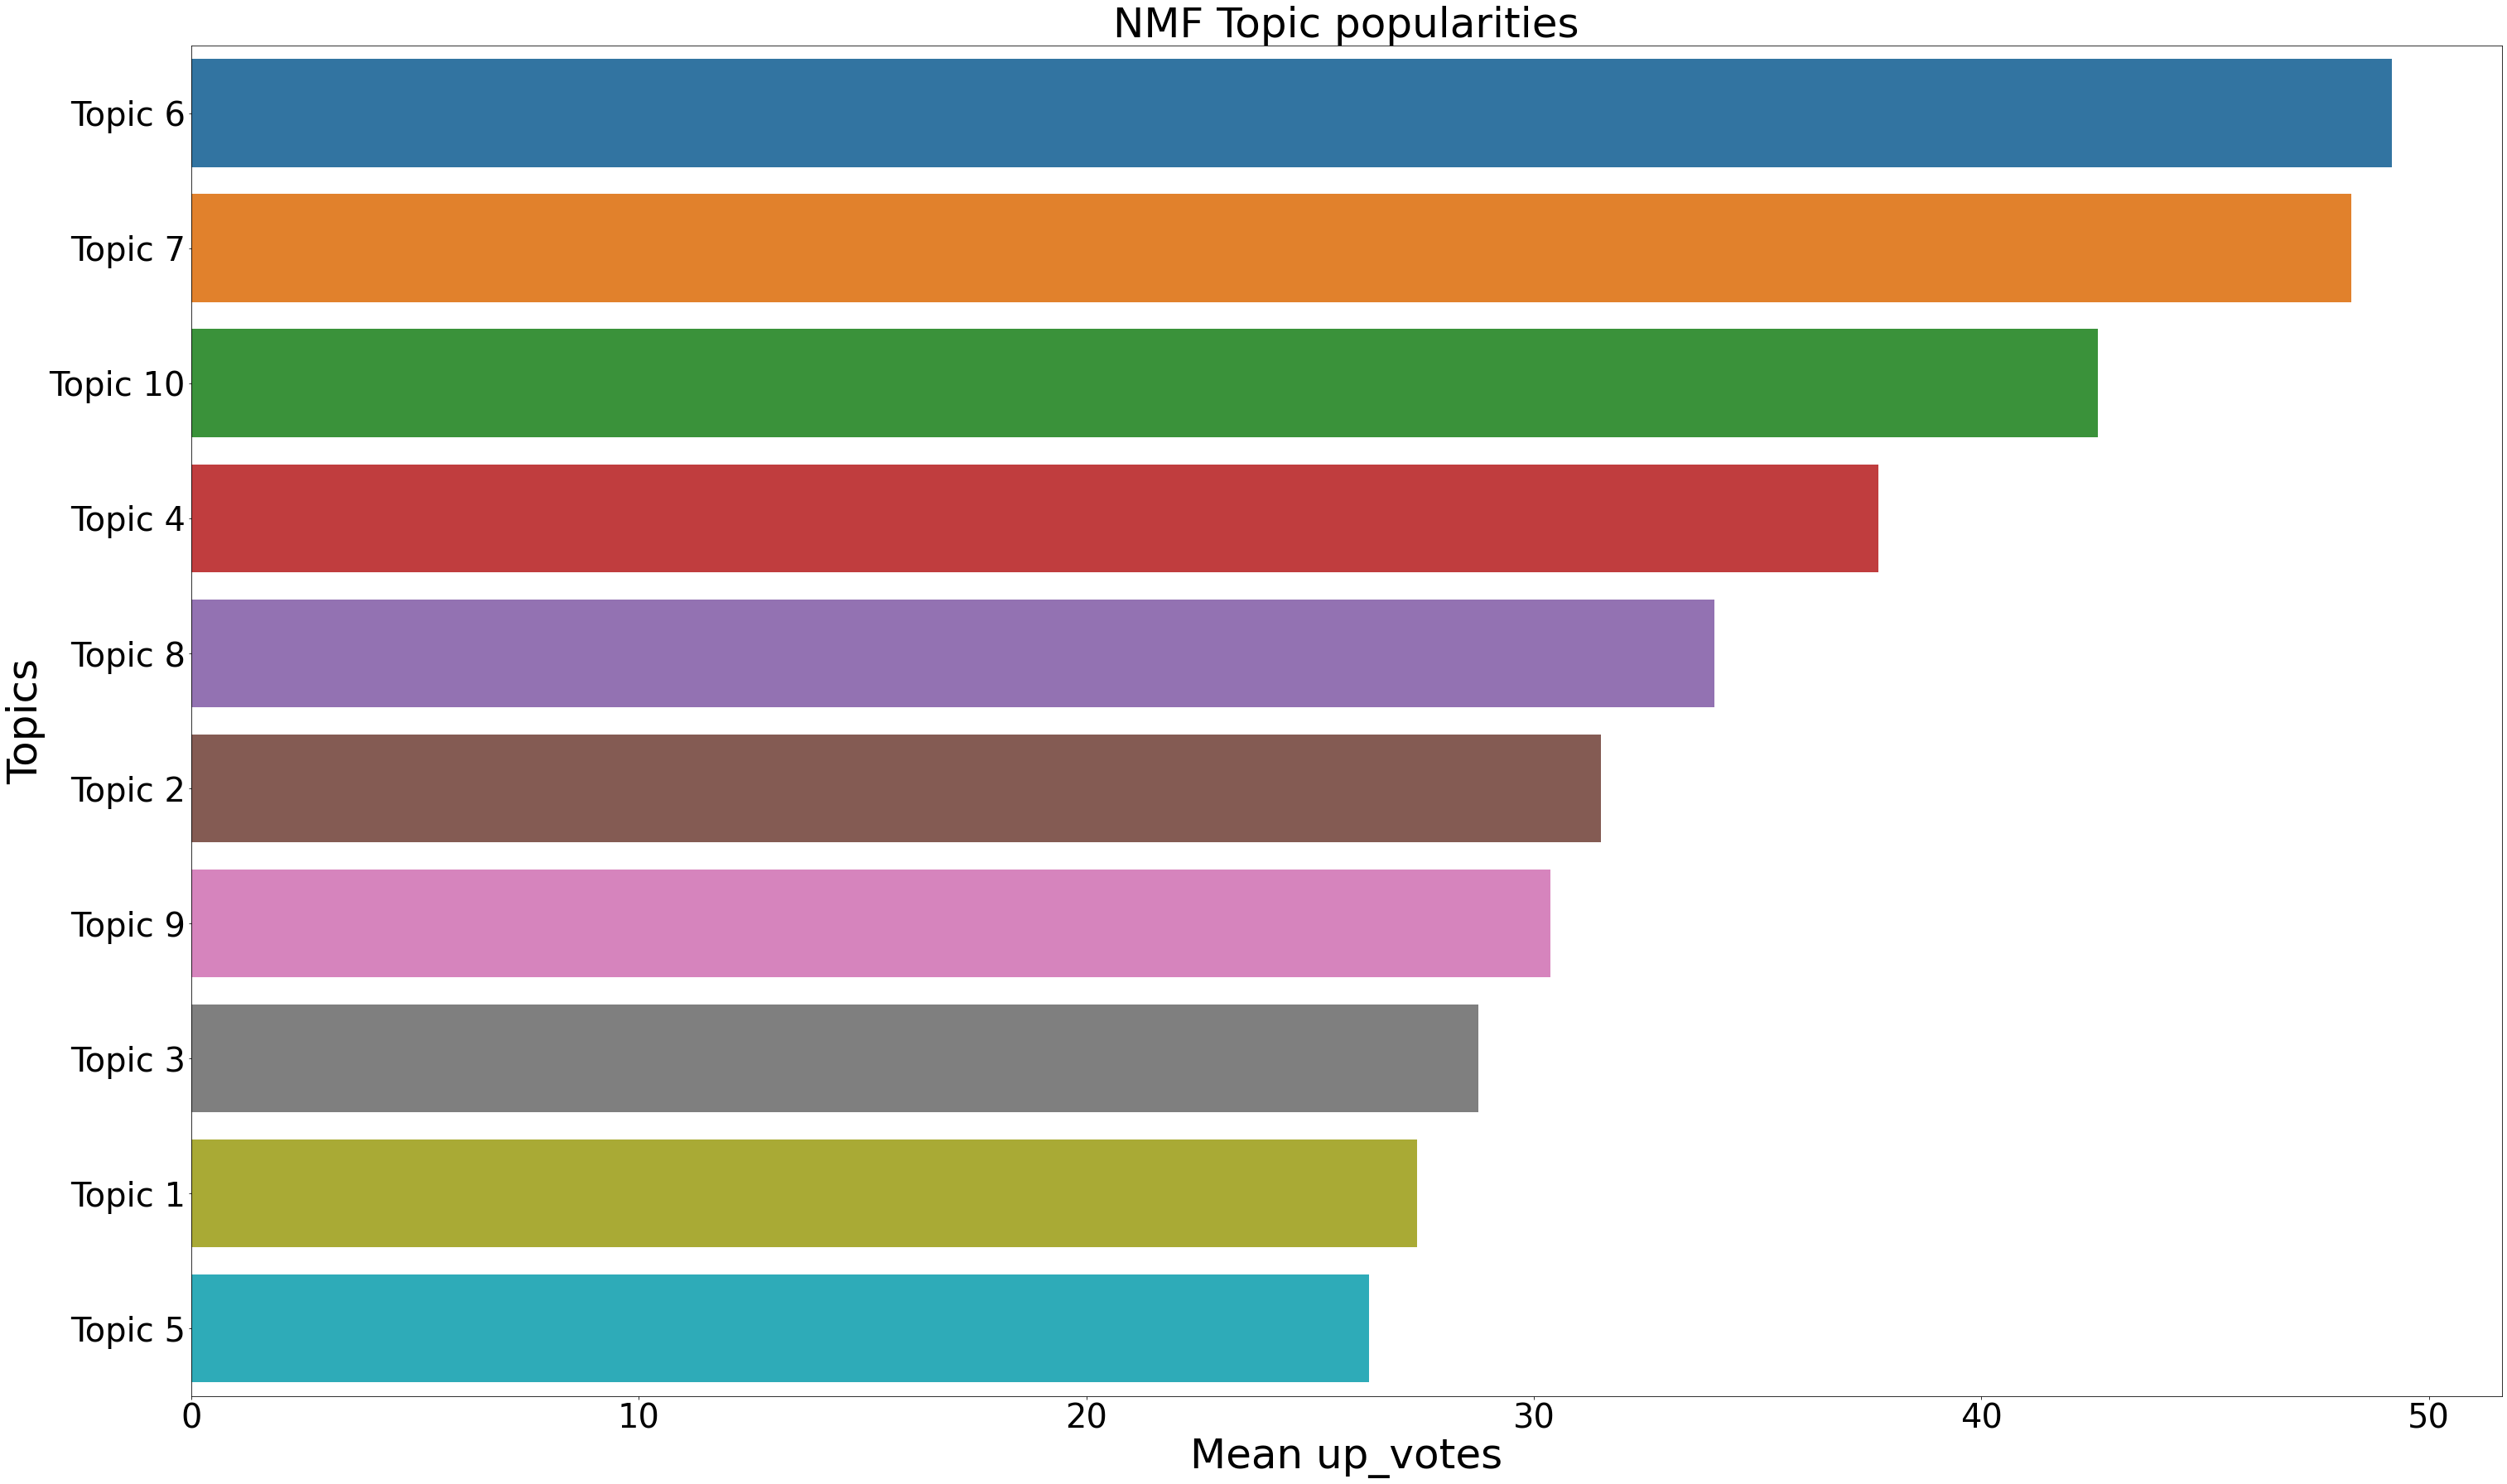

In [73]:
author = 'davidreiss666'

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['author']==author,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics_by_author(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {author} (with bigrams)', author)

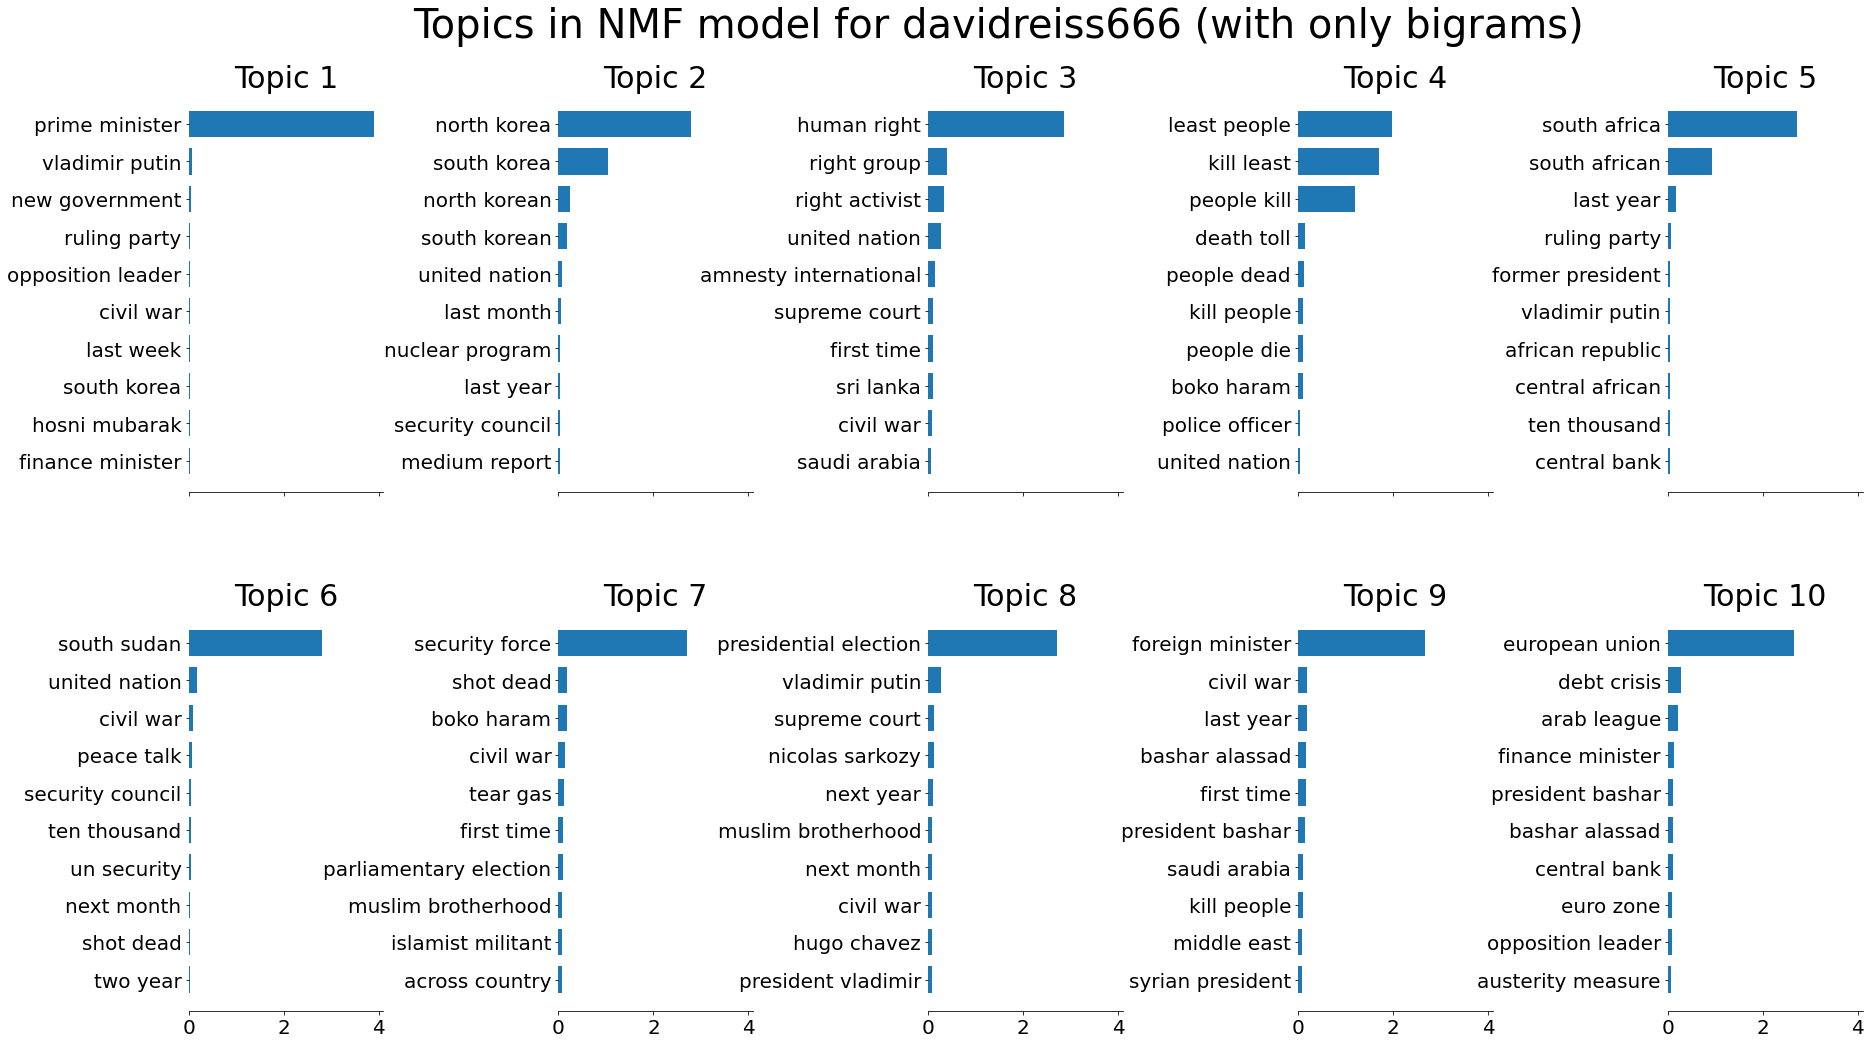

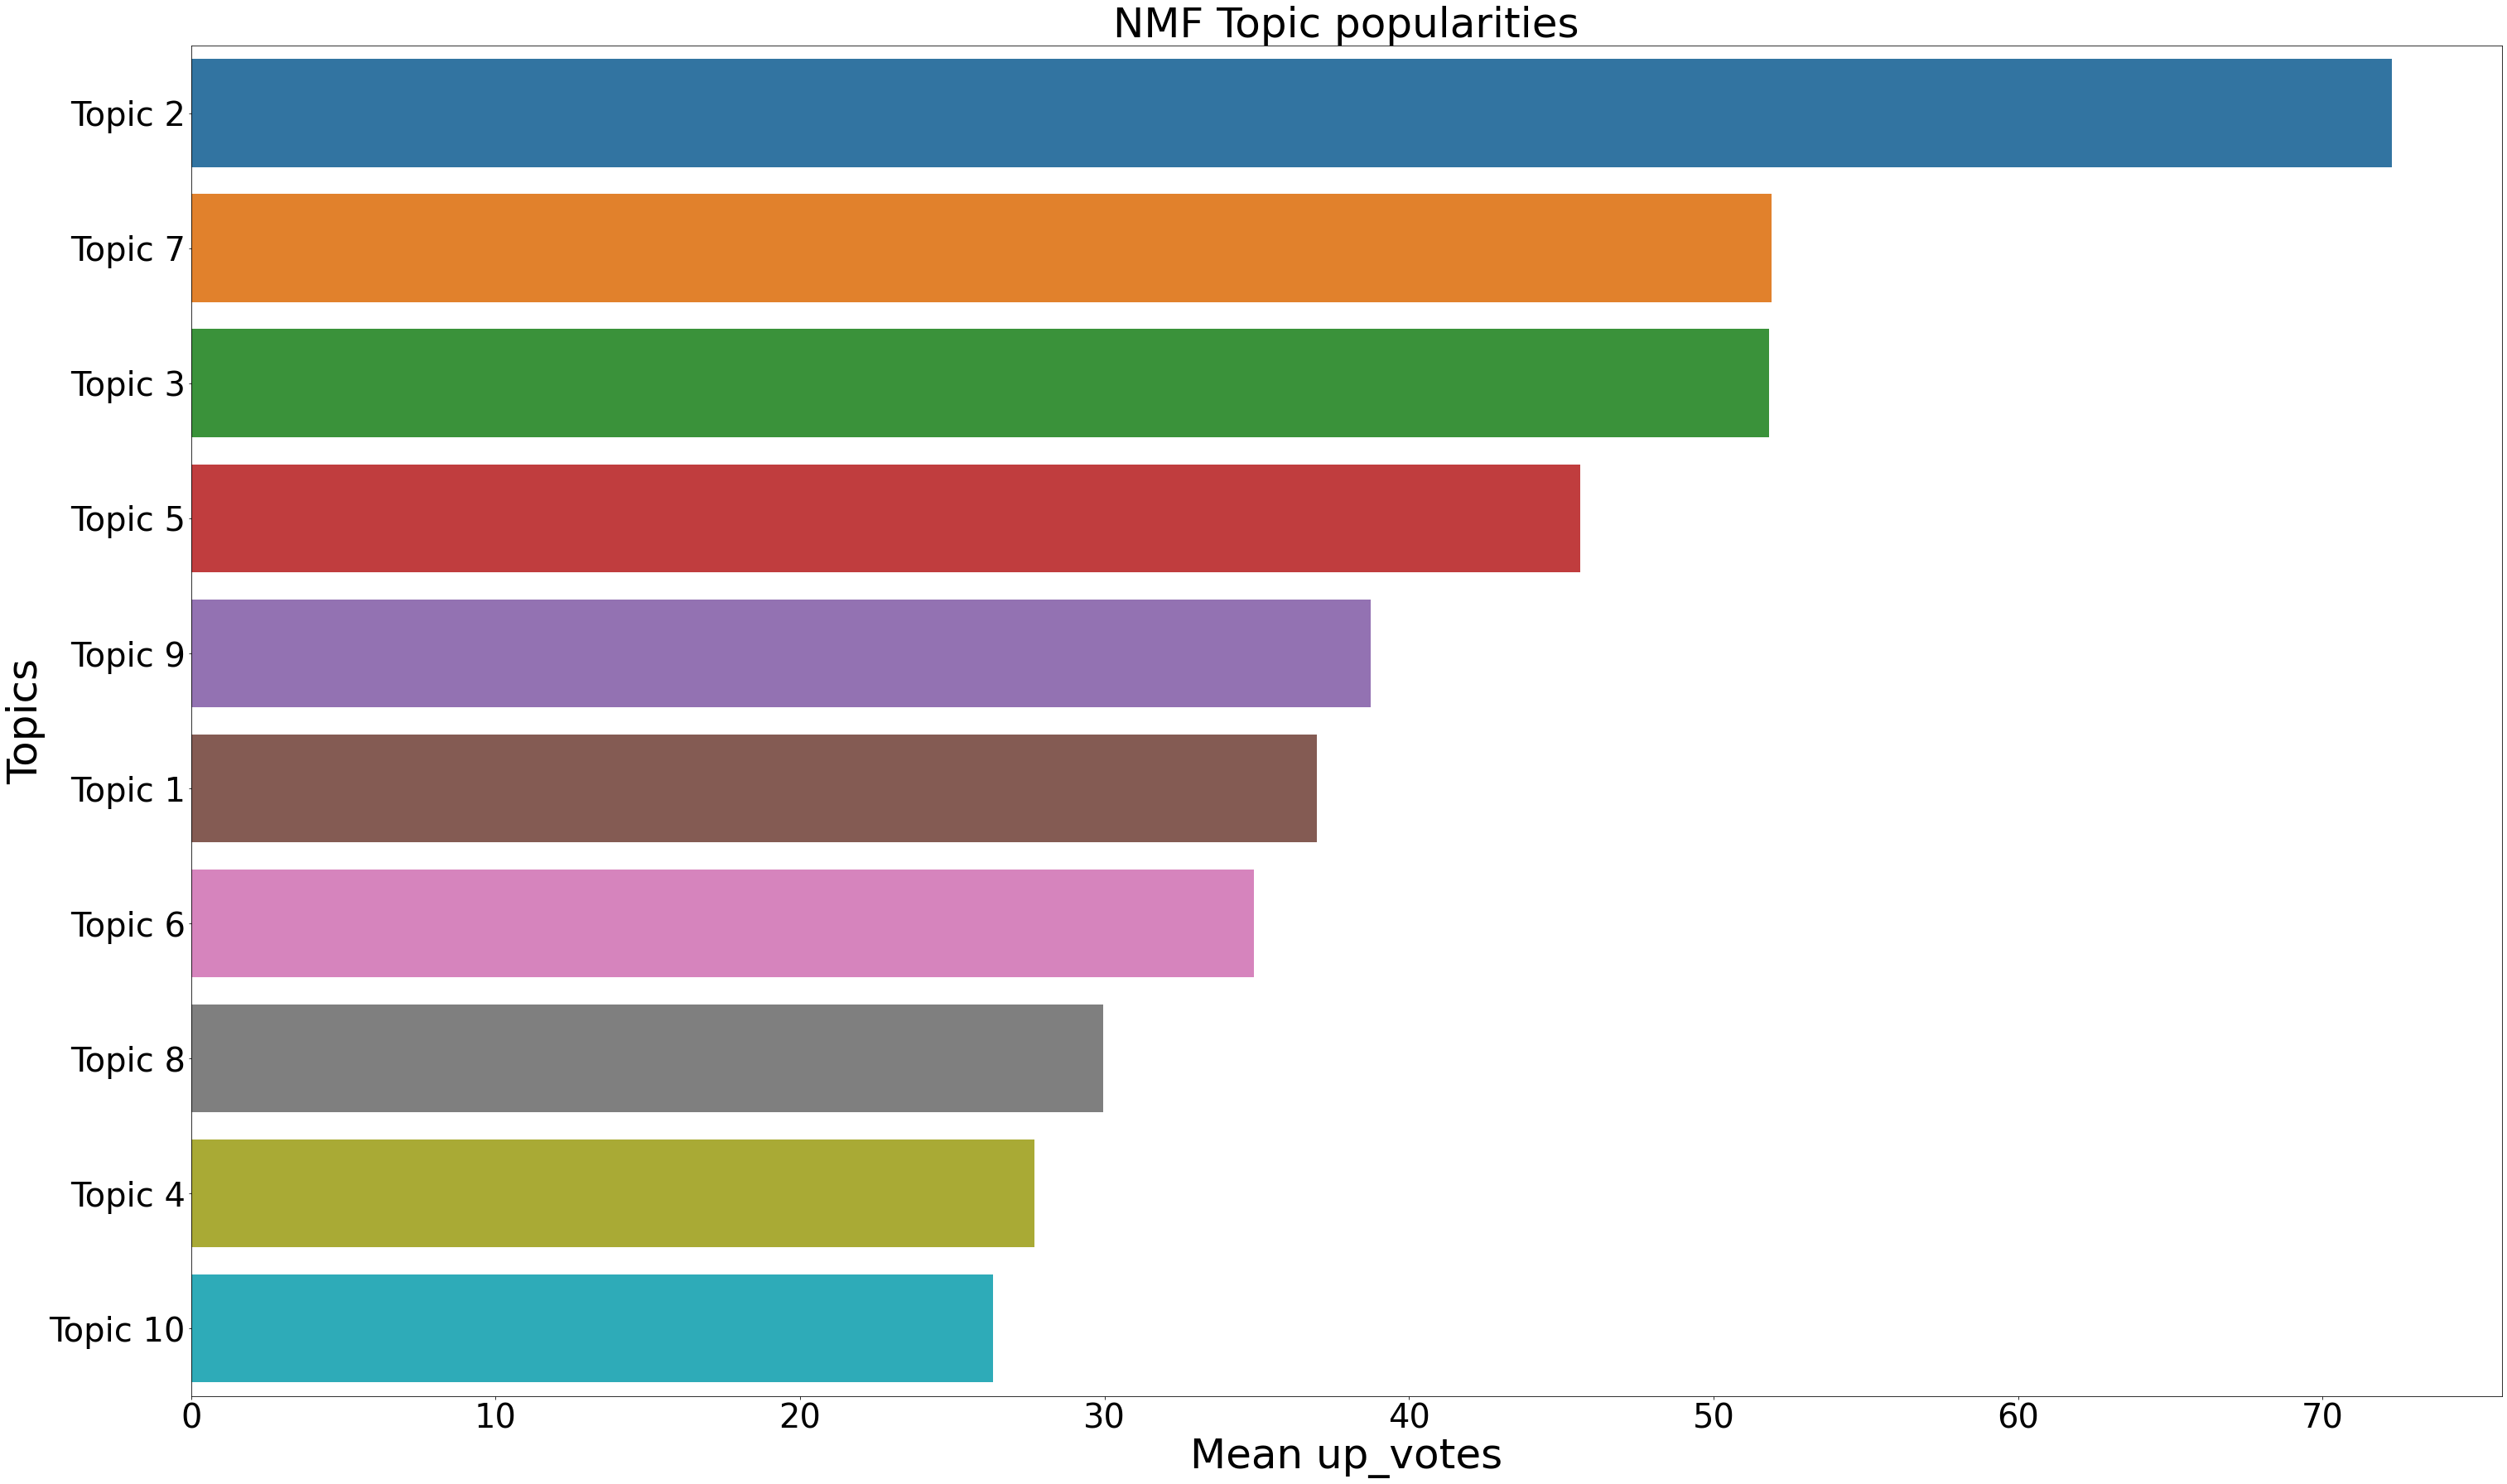

In [74]:
author = 'davidreiss666'

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['author']==author,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics_by_author(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {author} (with only bigrams)', author)

### 'davidreiss666' mostly covers *terrorism*, *killings*, *human rights*, etc. like north-south Korea tensions, Boko Haram.

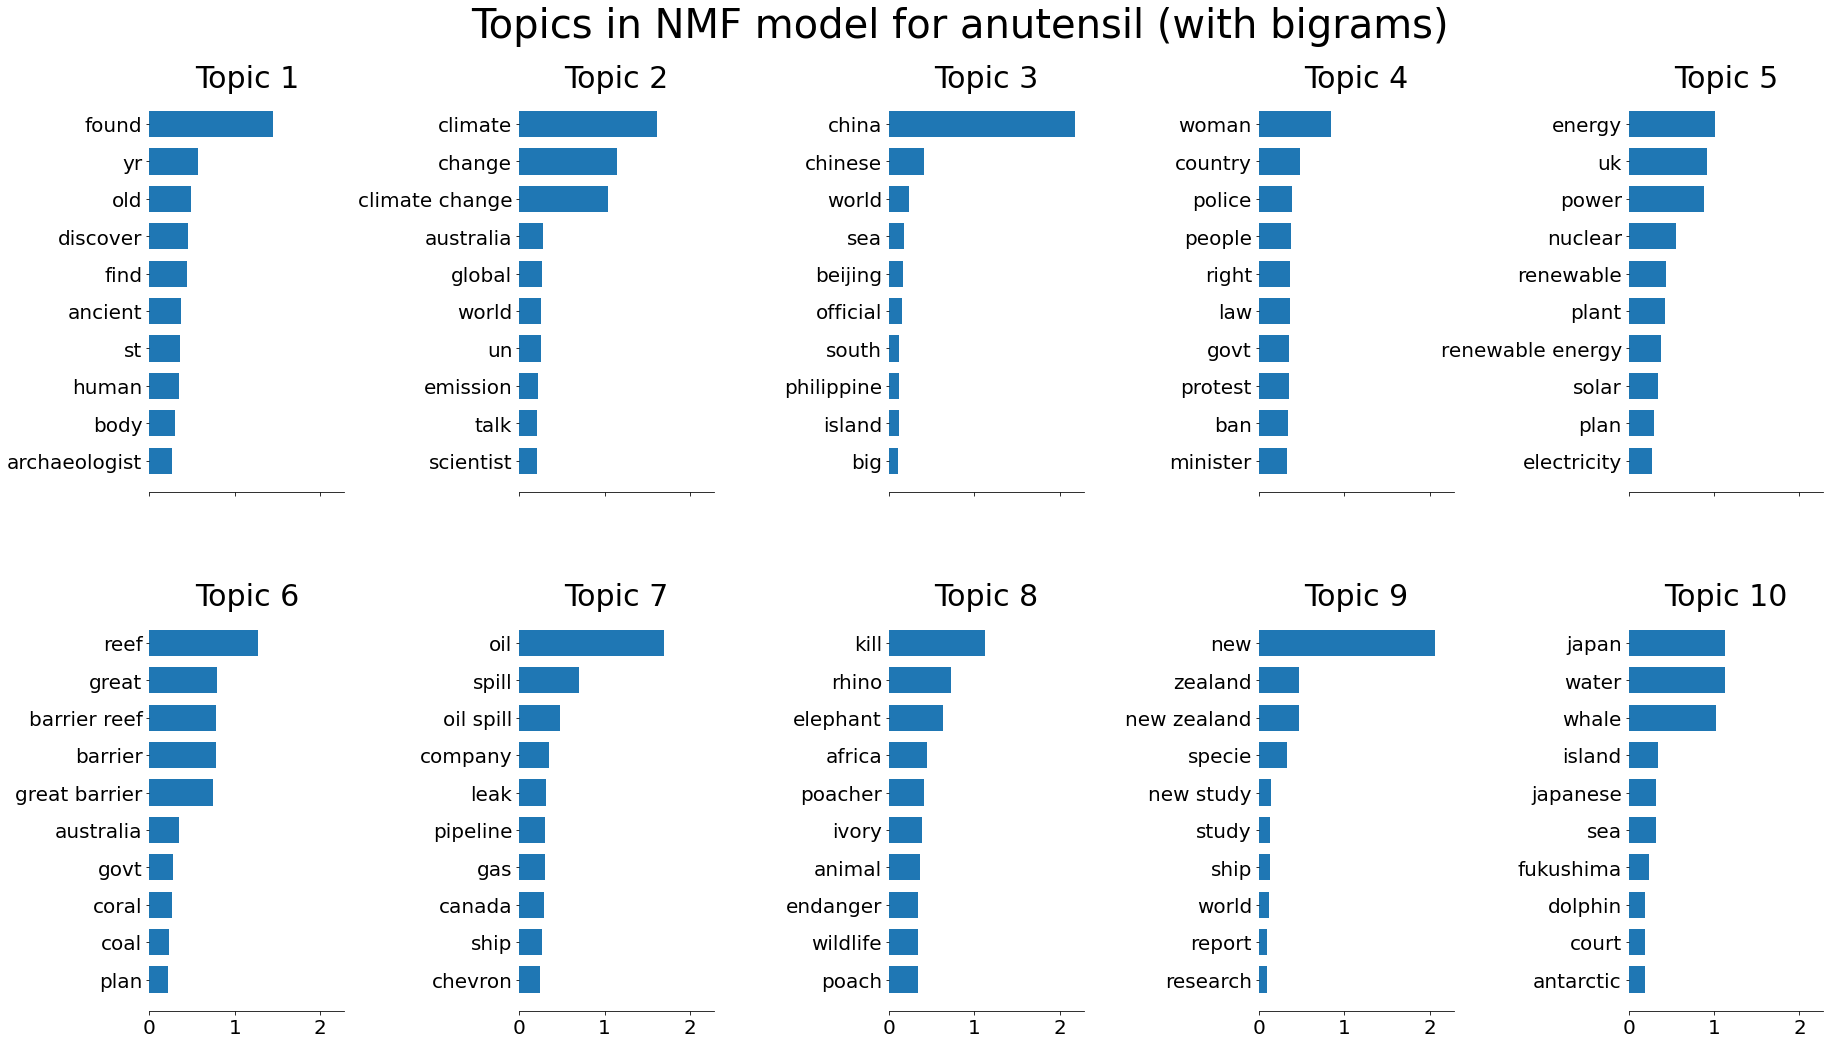

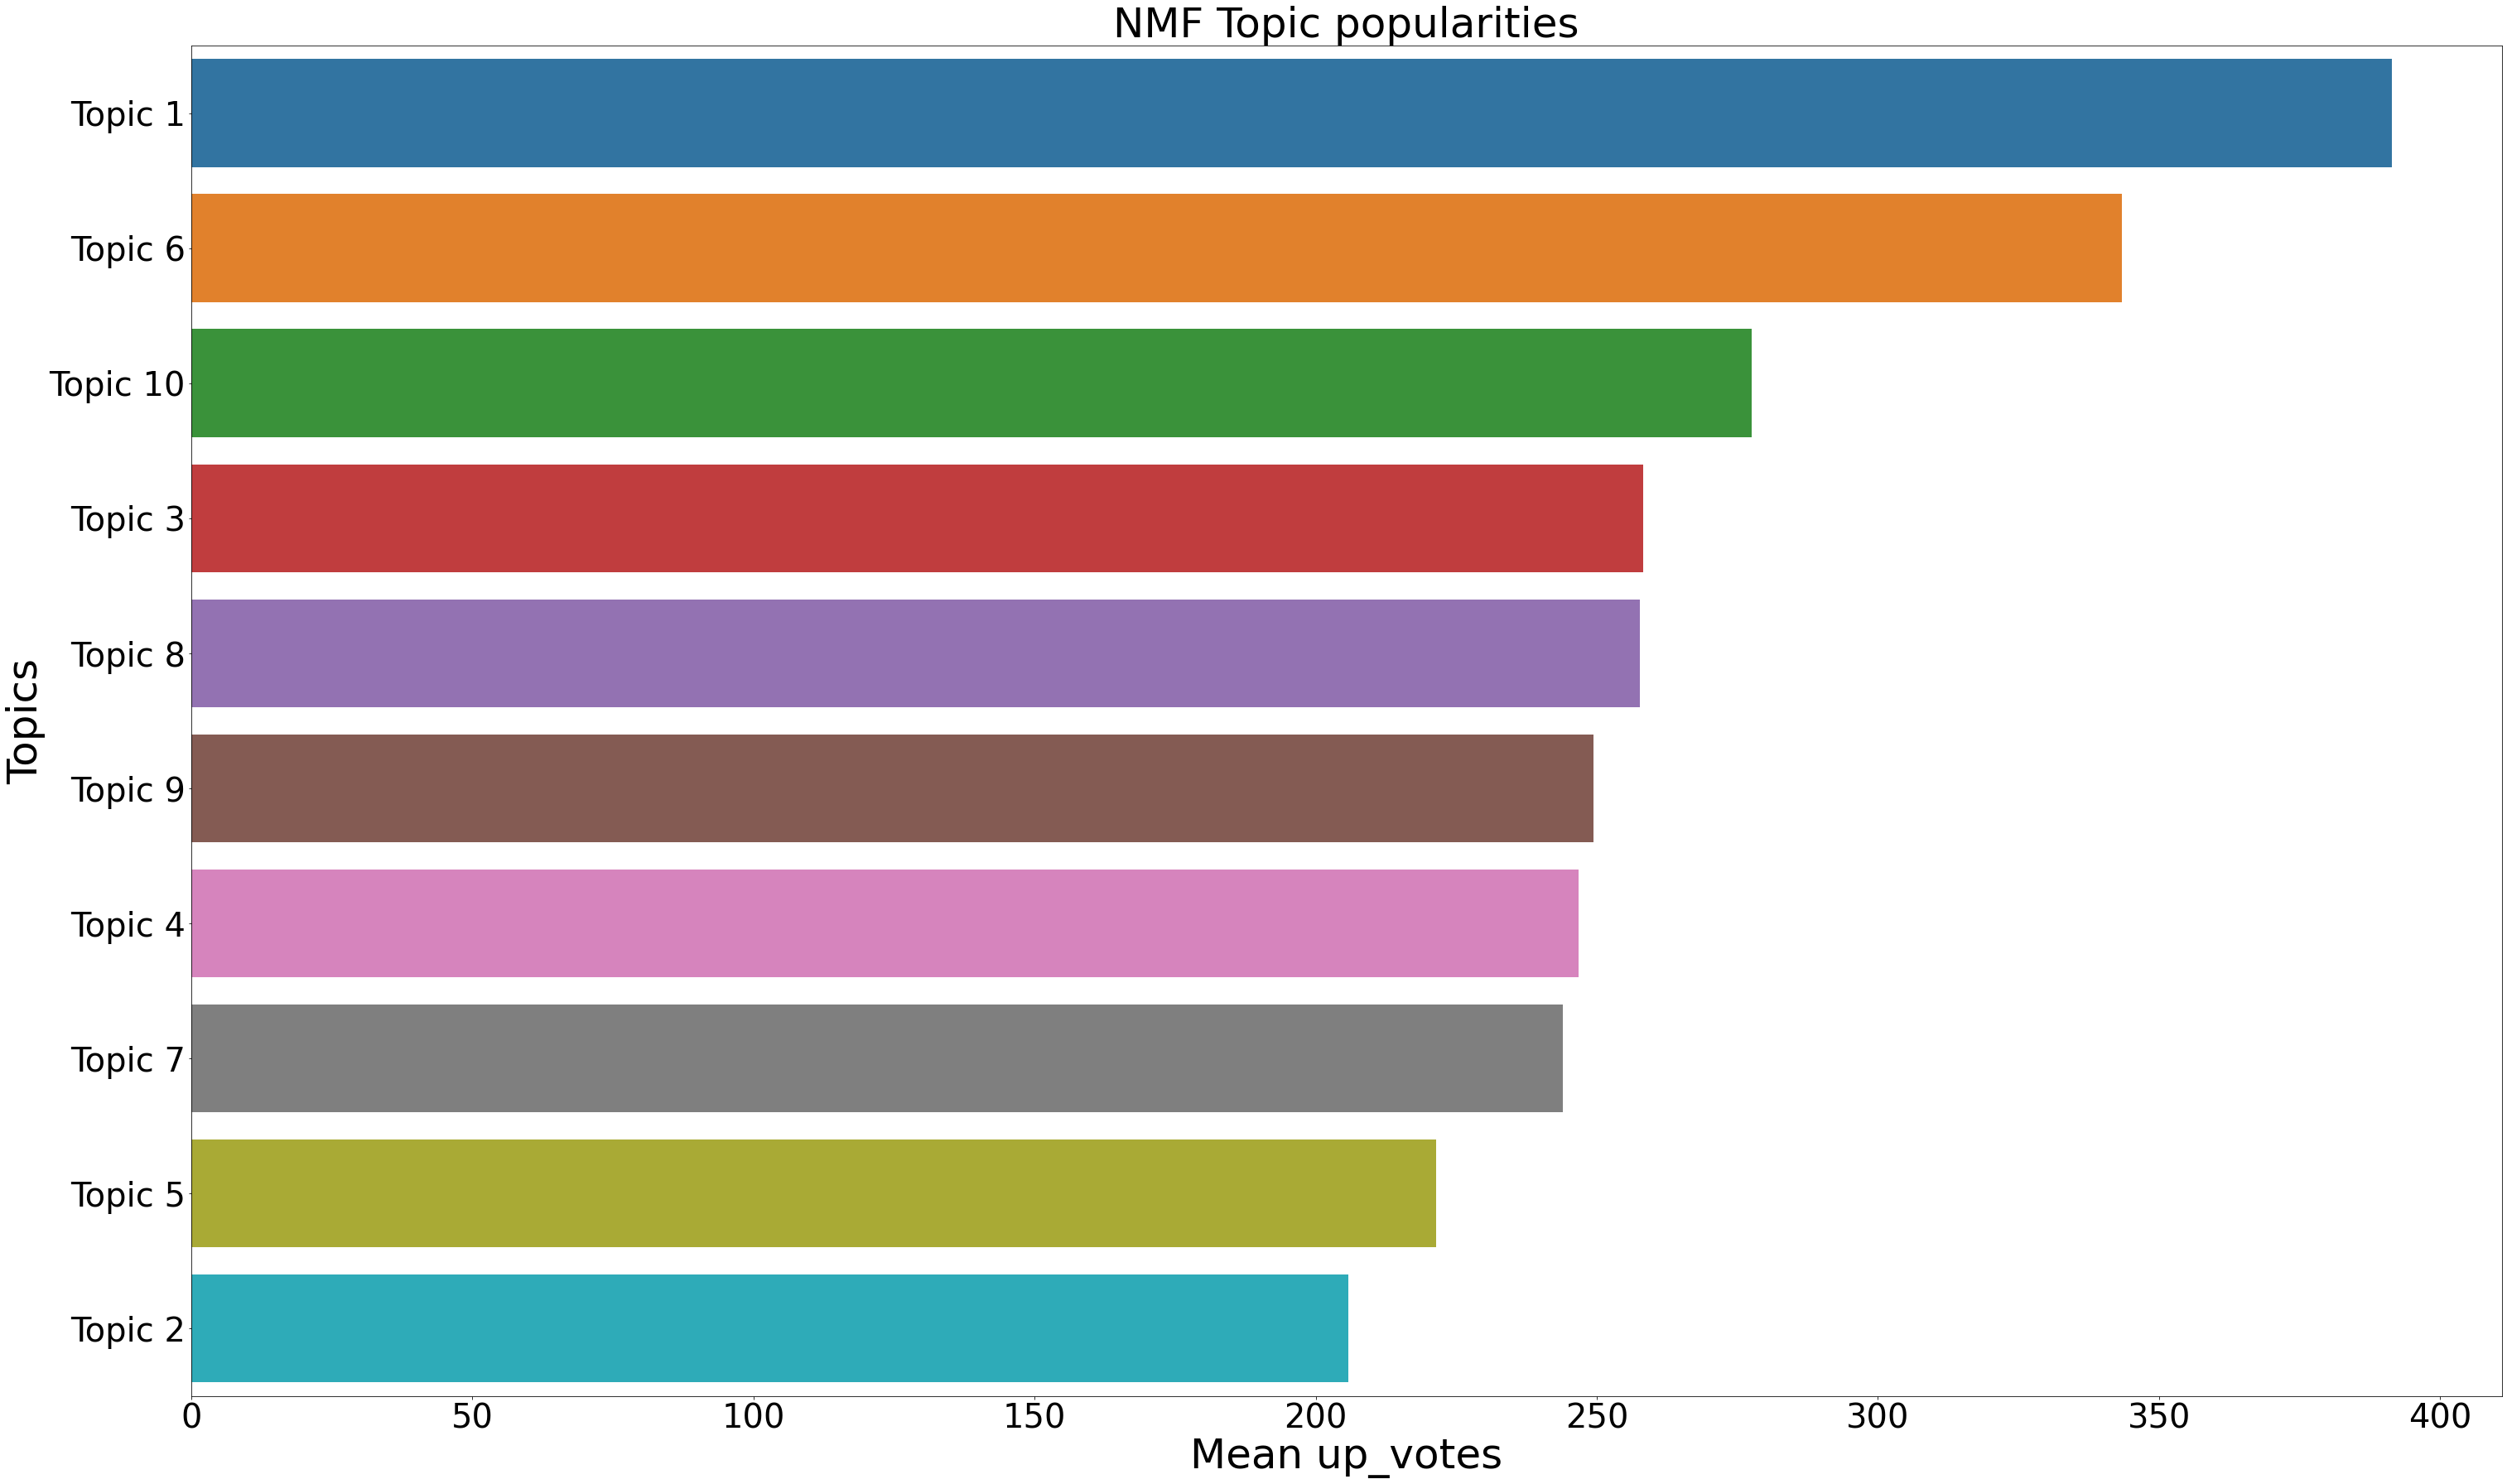

In [75]:
author = 'anutensil'

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['author']==author,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics_by_author(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {author} (with bigrams)', author)

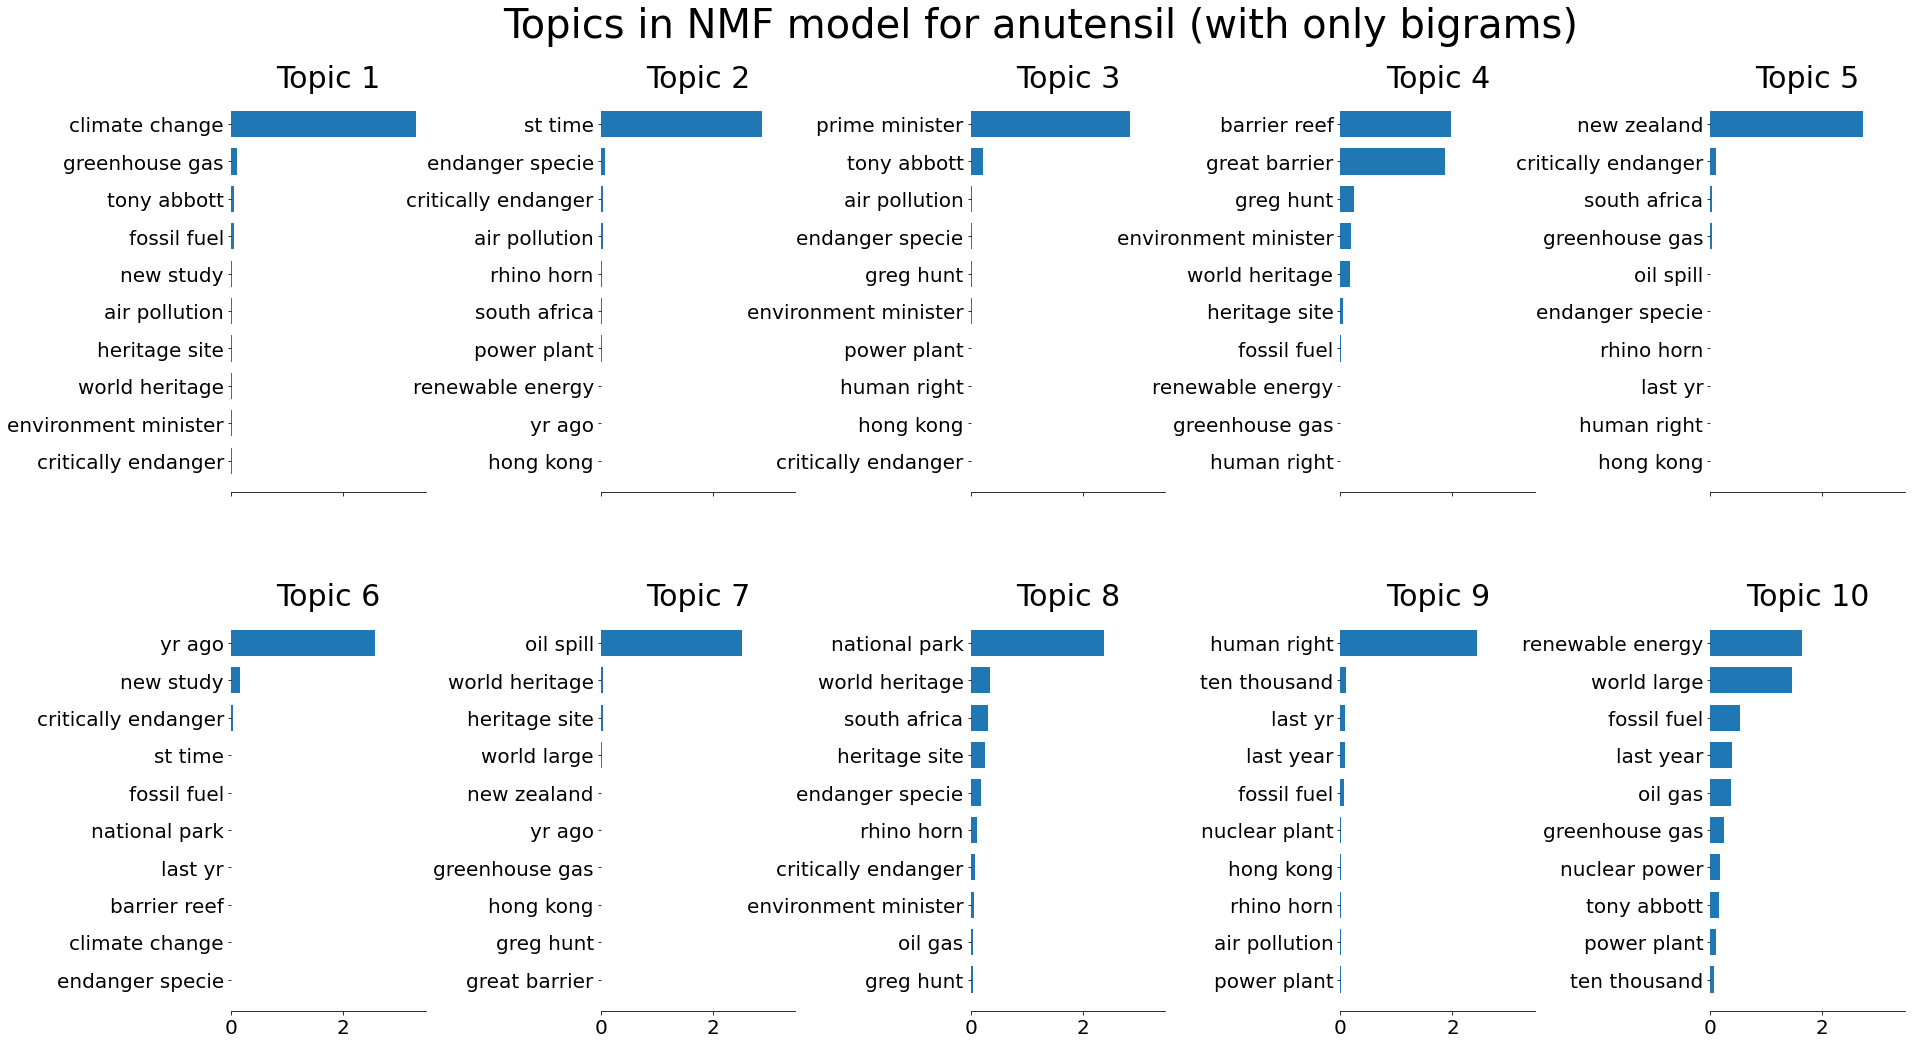

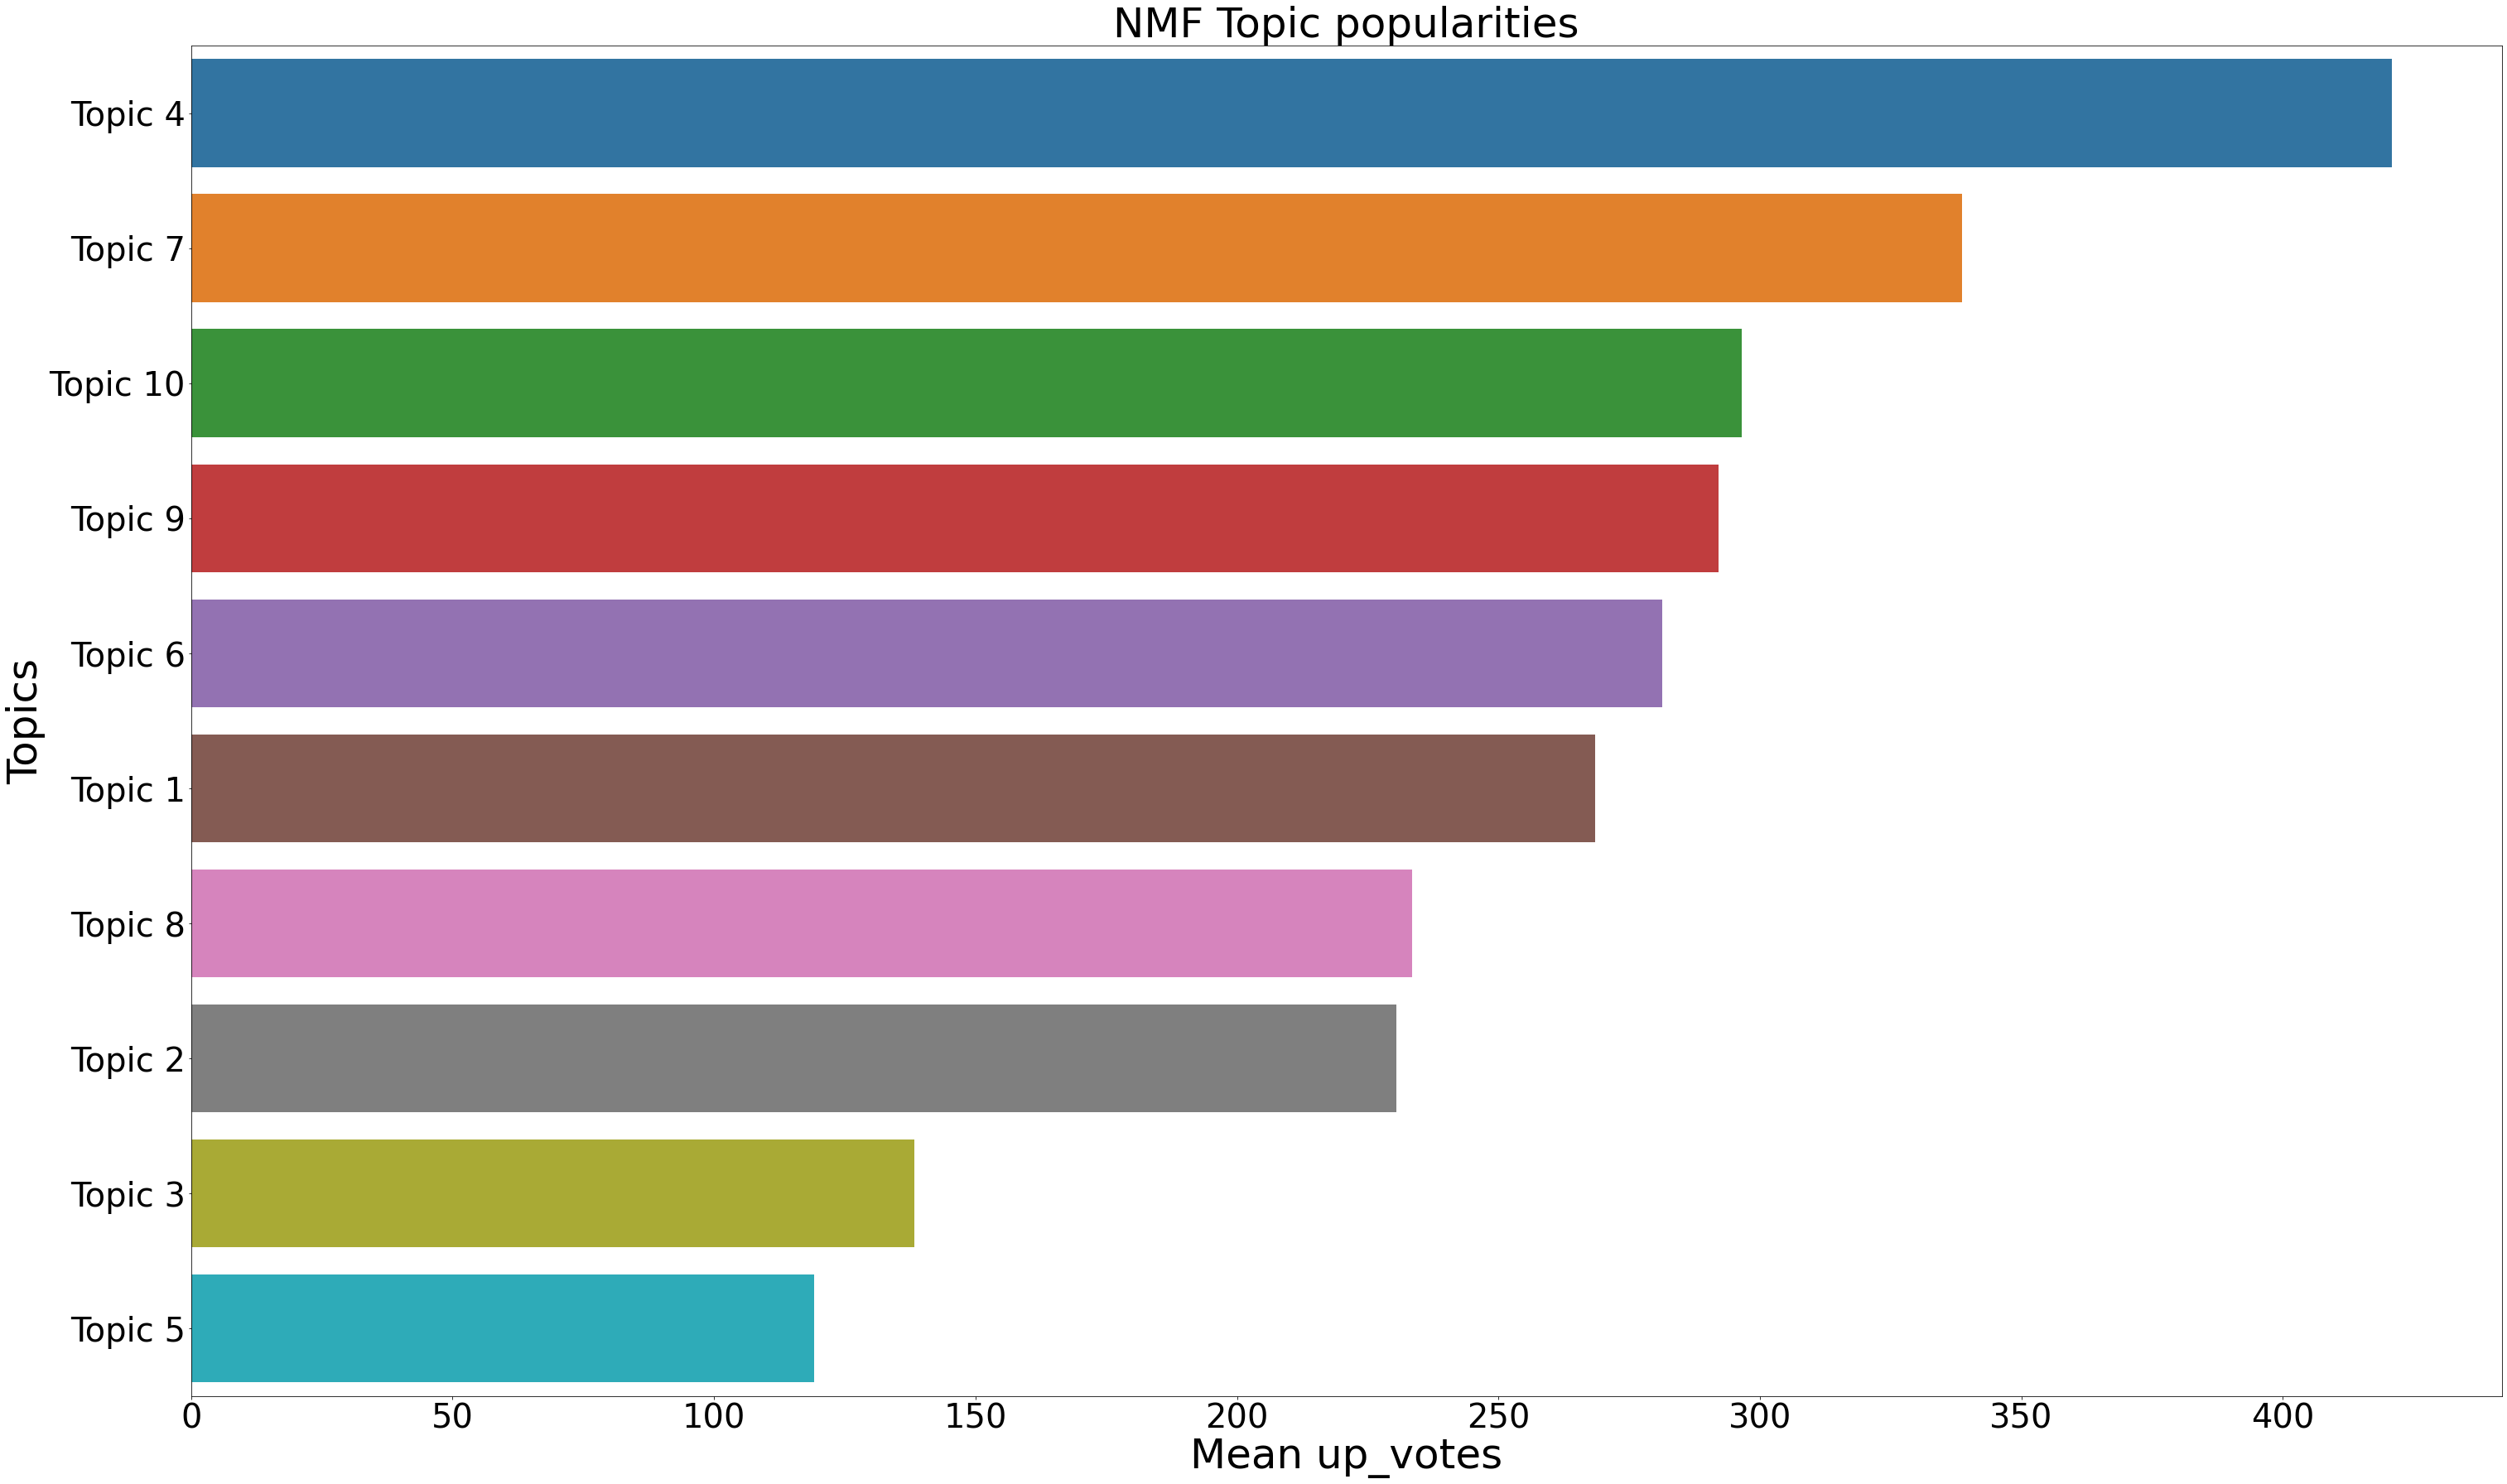

In [76]:
author = 'anutensil'

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['author']==author,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics_by_author(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {author} (with only bigrams)', author)

### 'anutensil' mostly covers 'conservation' related topics like *climate change*, *renewables*, *endangered species* etc. 